# Forcasting Time Series

In [43]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
import matplotlib.dates as mdates

from statsmodels.tsa.arima.model import ARIMA
import scipy.stats as spyst
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Coisas por fazer:

    Fazer so arima;

# Perguntas ao stor:

    Como escolhemos os delays;

    Como fazemos MLP com 3 ts;

    Como fazemos no ES?

# Ler dados

In [44]:
df1 = pd.read_csv("EDP.csv", sep=",")
df2 = pd.read_csv("new_crude.csv", sep=",")
df3 = pd.read_csv("EDPr.csv", sep=";")

merged_data = pd.merge(df1, df2, on='Date', how='inner')
merged_data = pd.merge(merged_data, df3[["Date","Close"]], on='Date', how='inner')

new_df1 = merged_data[['Date', 'Close_x']].rename(columns={'Close_edp': 'Close'})
new_df2 = merged_data[['Date', 'Price']].rename(columns={'Close_crude': 'Close'})
new_df3 = merged_data[['Date', 'Close_y']].rename(columns={'Close_edpr': 'Close'})

merged_data.rename(columns={'Close_x': 'Close_edp'}, inplace=True)
merged_data.rename(columns={'Close_y': 'Close_edpr'}, inplace=True)
merged_data.rename(columns={'Price': 'Close_crude'}, inplace=True)
#print(new_df1.head()) # EDP
#print(new_df2.head()) # crude
#print(new_df3.head()) # edpr

merged_data["time_int"] = np.arange(len(merged_data))
merged_data

Date  Close_edp  Close_crude  time_int  Close_edpr
0    19/10/2021      4.773        85.02         0      22.280
1    20/10/2021      4.894        85.76         1      23.020
2    21/10/2021      4.858        84.58         2      23.420
3    22/10/2021      4.927        85.43         3      23.840
4    25/10/2021      4.895        84.85         4      23.780
..          ...        ...          ...       ...         ...
433  02/10/2023      3.821        91.21       433      15.100
434  03/10/2023      3.622        94.46       434      13.885
435  04/10/2023      3.612        89.83       435      13.980
436  05/10/2023      3.662        88.28       436      14.240
437  06/10/2023      3.636        87.86       437      14.220

[438 rows x 5 columns]

<Axes: title={'center': 'EDP Close Price'}>

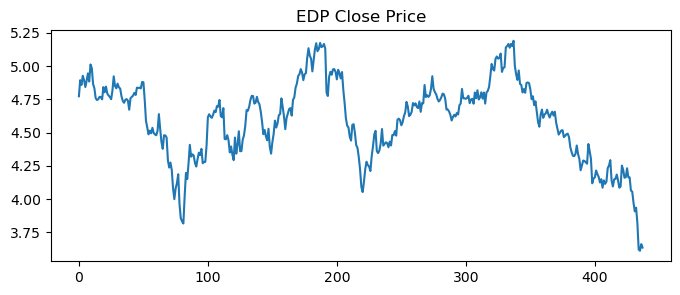

In [45]:
merged_data["Close_edp"].plot(x="Date", y=["time_int"], kind="line", figsize=(8, 3), title="EDP Close Price")

## BOX-Jenkis forecasting

70    4.237
71    4.275
72    4.218
73    4.082
74    4.000
Name: Out-of-sample data, dtype: float64


Text(42.597222222222214, 0.5, 'Autocorrelation')

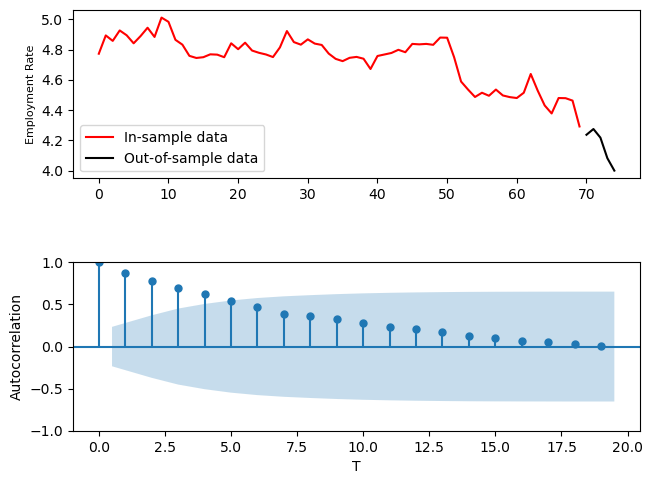

In [63]:
#%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

unTS = merged_data["Close_edp"]

#Create a Series for training (In-sample data)
unTSTrain=unTS[0:70]
unTSTrain.name="In-sample data"

#Create a Series for testing (out-of-sample data)
unTSVal=unTS[70:75]
unTSVal.name="Out-of-sample data"
print(unTSVal)

#Plot TS
fig, axs=plt.subplots(2)
fig.tight_layout()
# Adjust the space between subplots
plt.subplots_adjust(hspace=0.5)  # You can adjust the value as needed

unTSTrain.plot(ax=axs[0],legend=True,color='r')
unTSVal.plot(ax=axs[0],legend=True,color='k')
axs[0].set_ylabel('Employment Rate',fontdict={'fontsize':8})
axs[0].set_xlabel('',fontdict={'fontsize':8})

#Plot ACS
plot_acf(unTSTrain,ax=axs[1],title="")
plt.xlabel("T")
plt.ylabel("Autocorrelation")

Text(42.597222222222214, 0.5, 'Autocorrelation')

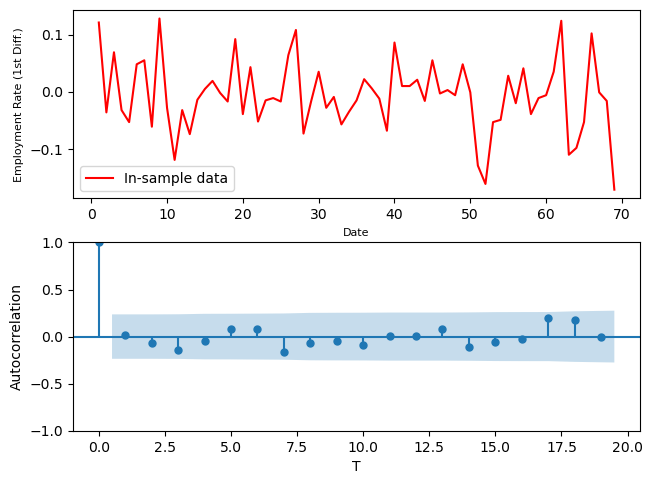

In [64]:
#Simple first-order differencing & remove NaN
unTSTraind1=unTSTrain.diff().dropna()

#Plot differenced TS & its ACS
fig, axs=plt.subplots(2)
fig.tight_layout()
unTSTraind1.plot(ax=axs[0],legend=True,color='r')
axs[0].set_ylabel('Employment Rate (1st Diff.)',fontdict={'fontsize':8})
axs[0].set_xlabel('Date',fontdict={'fontsize':8})
plot_acf(unTSTraind1,ax=axs[1],title="")
plt.xlabel("T")
plt.ylabel("Autocorrelation")


In [65]:
import statsmodels.tsa.stattools as st

#Perform ADF test to confirm stationarity
result=st.adfuller(unTSTraind1)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))



ADF Statistic: -5.498454
p-value: 0.000002
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591


Text(42.597222222222214, 0.5, 'Partial Autocorrelation')

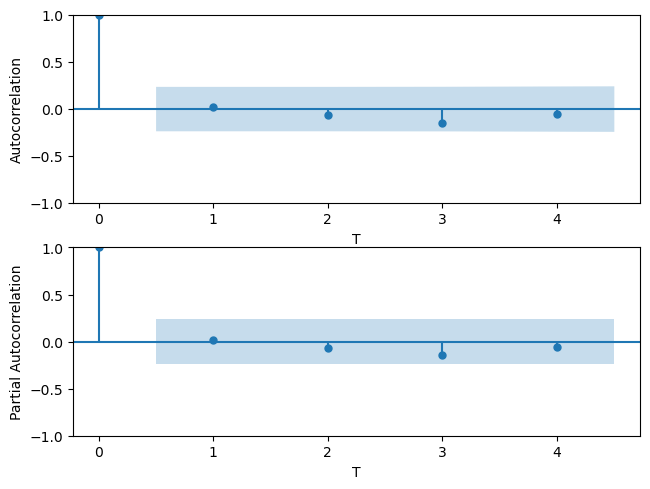

In [66]:
#Plot just the first 11 values of ACS and PACS to try to have a clue about p and q.

fig, axs=plt.subplots(2)
fig.tight_layout()

plot_acf(unTSTraind1,ax=axs[0],title="",lags=4)
axs[0].set_xlabel("T")
axs[0].set_ylabel("Autocorrelation")

plot_pacf(unTSTraind1,ax=axs[1],title="",lags=4)
axs[1].set_xlabel("T")
axs[1].set_ylabel("Partial Autocorrelation")



Text(42.597222222222214, 0.5, 'Partial Autocorrelation')

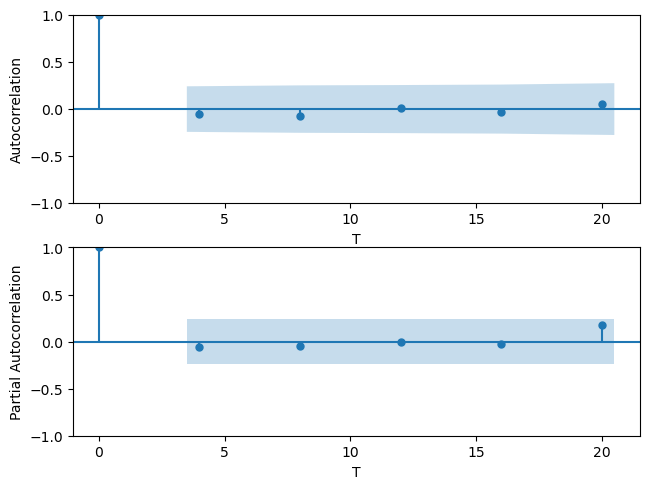

In [67]:
#Resample ACS and PACS at S=12 to try to have a clue about P and Q.
fig, axs=plt.subplots(2)
fig.tight_layout()

plot_acf(unTSTraind1,ax=axs[0],title="",lags=np.arange(0,24,4))
axs[0].set_xlabel("T")
axs[0].set_ylabel("Autocorrelation")

plot_pacf(unTSTraind1,ax=axs[1],title="",lags=np.arange(0,24,4))
axs[1].set_xlabel("T")
axs[1].set_ylabel("Partial Autocorrelation")



    ARIMA

Fitted model AIC=-185.21718580521843


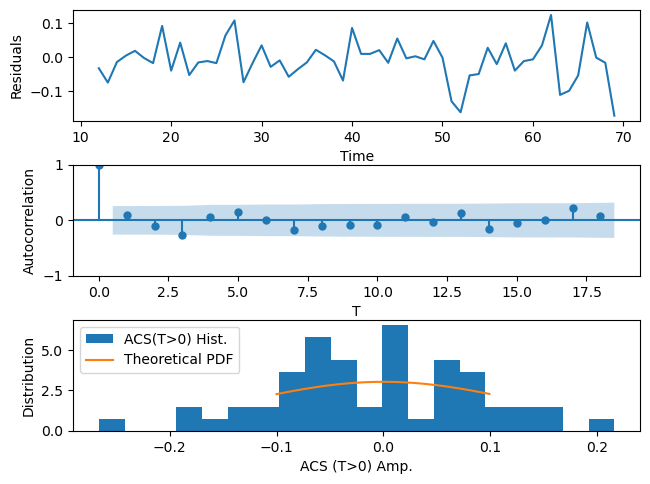

In [68]:
from statsmodels.tsa.arima.model import ARIMA
import scipy.stats as spyst
from statsmodels.tsa.stattools import acf

#Defina a SARIMA structure     p d  q                   P  D. Q.  S
model=ARIMA(unTSTrain, order=(0, 1, 0))
#Fit model
fit = model.fit()

#Get residuals
res=fit.resid[12:]
#Get fitting performance (AIC)
print("Fitted model AIC="+str(fit.aic))

#Evaluate fitting quality by inspecting residuals at three levels: Time plot, ACS and ACS distribution
fig, axs=plt.subplots(3)
fig.tight_layout()
res.plot(ax=axs[0])
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Residuals')
plot_acf(res,ax=axs[1],title="")
axs[1].set_xlabel("T")
axs[1].set_ylabel("Autocorrelation")

ac=acf(res,nlags=500,fft=False)

axs[2].hist(ac[1:],bins=20,density=True,label='ACS(T>0) Hist.')

N=res.size
rg=np.arange(-0.1,0.1,0.001)
pdf = spyst.norm.pdf(rg,0,1/np.sqrt(N))
plt.plot(rg,pdf,label='Theoretical PDF')
plt.xlabel("ACS (T>0) Amp.")
plt.ylabel("Distribution")
plt.legend()


Forecast RMSE=0.16622514851850775


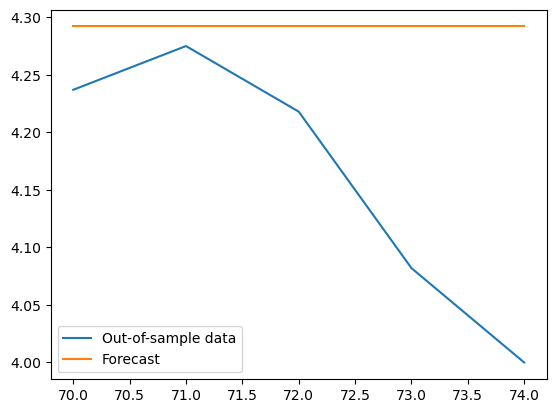

In [69]:
plt.figure()
unTSVal.plot(legend=True)
forecast=fit.forecast(5)
forecast.name="Forecast"
forecast.plot(legend=True)

print("Forecast RMSE="+str(np.sqrt(np.sum((unTSVal-forecast)**2)/forecast.size)))

In [70]:
rp=range(0,5)
rq=range(0,5)
rP=range(0,5)
rQ=range(0,5)

aicV=np.zeros((len(rp),len(rq),len(rP),len(rQ)))
i=0
for p in rp:
    j=0
    for q in rq:
        k=0

            
        model=ARIMA(unTSTrain, order=(p, 1, q))
        fit = model.fit()
        aicV[i][j][k]=fit.aic
        print("Evaluating p="+str(p)+" q="+str(q)+" AIC="+str(fit.aic))

        j=j+1
    i=i+1
                
ixs=np.where(aicV==np.min(aicV))
print("Best: p="+str(rp[ixs[0][0]])+", q="+str(rp[ixs[1][0]])+" AIC="+str(aicV[ixs[0][0]][ixs[1][0]][ixs[2][0]][ixs[3][0]]))

Evaluating p=0 q=0 AIC=-185.21718580521843
Evaluating p=0 q=1 AIC=-183.28970498094267
Evaluating p=0 q=2 AIC=-181.48839555278573
Evaluating p=0 q=3 AIC=-180.49372585786932
Evaluating p=0 q=4 AIC=-179.1115806780084
Evaluating p=1 q=0 AIC=-183.281182485175
Evaluating p=1 q=1 AIC=-181.67662827524254
Evaluating p=1 q=2 AIC=-180.2319093079821
Evaluating p=1 q=3 AIC=-178.7119886235072
Evaluating p=1 q=4 AIC=-177.1965354436234
Evaluating p=2 q=0 AIC=-181.52647261377686
Evaluating p=2 q=1 AIC=-180.29959438435532


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Evaluating p=2 q=2 AIC=-182.27867395963963
Evaluating p=2 q=3 AIC=-179.49206715540984


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxim

Evaluating p=2 q=4 AIC=-179.7933505363607
Evaluating p=3 q=0 AIC=-180.83787119703172
Evaluating p=3 q=1 AIC=-178.87396465235284


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxim

Evaluating p=3 q=2 AIC=-180.05693347306232
Evaluating p=3 q=3 AIC=-179.83745105422176


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=4 AIC=-177.83218332557803
Evaluating p=4 q=0 AIC=-178.9244040598459
Evaluating p=4 q=1 AIC=-176.9972803275756


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=2 AIC=-178.99897700115326
Evaluating p=4 q=3 AIC=-177.2905724491157
Evaluating p=4 q=4 AIC=-175.67813919300303
Best: p=0, q=0 AIC=-185.21718580521843


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [71]:
ixs=np.where(aicV==np.min(aicV))
print("Best: p="+str(rp[ixs[0][0]])+", q="+str(rp[ixs[1][0]])+" AIC="+str(aicV[ixs[0][0]][ixs[1][0]][ixs[2][0]][ixs[3][0]]))

Best: p=0, q=0 AIC=-185.21718580521843


Fitted model AIC=-185.21718580521843
Forecast RMSE=0.16622514851850775


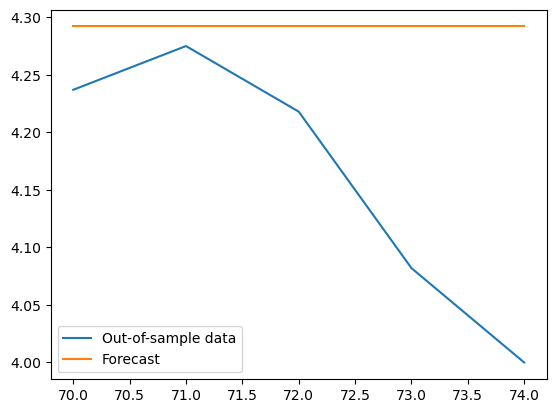

In [72]:
#Define a SARIMA structure with the best p, q, P and Q from grid-search.
model=ARIMA(unTSTrain, order=(0, 1, 0))
#model=ARIMA(unTSTrain, order=(3, 1, 5), seasonal_order=(2, 1, 2, 40))
fit = model.fit()
res=fit.resid[1:]
print("Fitted model AIC="+str(fit.aic))

#Compare graphically forecasts with the true TS values
plt.figure()
unTSVal.plot(legend=True)
forecast=fit.forecast(5)
forecast.name="Forecast"
forecast.plot(legend=True)

#Compute RMSE
print("Forecast RMSE="+str(np.sqrt(np.sum((unTSVal-forecast)**2)/forecast.size)))

    Avaliar ARIMA

In [73]:
import statistics
import numpy as np

unTS = merged_data["Close_edp"]

list_RMSE = []
list_MAFE = []
list_U2 = []
model=ARIMA(unTSTrain, order=(3, 1, 0))
fit = model.fit()
for i in range(0, len(unTS) - 75,5):
    

    unTSTrain=unTS[0+i:70+i]
    unTSTrain.name="In-sample data"

    unTSVal=unTS[70+i:75+i]
    unTSVal.name="Out-of-sample data"
    
    
    fit = fit.apply(unTSTrain)
    res=fit.resid[1:]
    print("Fitted model AIC="+str(fit.aic))

    forecast=fit.forecast(5)

    RMSE = np.sqrt(np.sum((unTSVal-forecast)**2)/forecast.size)
    print("Forecast RMSE="+str(RMSE))

    MAFE = np.mean(np.abs((unTSVal - forecast) / unTSVal))
    print("Forecast MAFE="+str(MAFE))

    U2 = np.sqrt(np.sum((unTSVal - forecast)**2) / np.sum((unTSVal - np.mean(unTSVal))**2))
    print("Forecast U2="+str(U2))

    list_RMSE.append(RMSE)
    list_MAFE.append(MAFE)
    list_U2.append(U2)

print("Em média o RMSE deste modelo é: ",statistics.mean(list_RMSE))
print("Em média o MAFE deste modelo é: ",statistics.mean(list_MAFE))
print("Em média o U2 deste modelo é: ",statistics.mean(list_U2))


Fitted model AIC=-180.83787119703172
Forecast RMSE=0.19025533455016744
Forecast MAFE=0.03716341817648648
Forecast U2=1.8278039010736618
Fitted model AIC=-178.0752596169335
Forecast RMSE=0.11993238975080983
Forecast MAFE=0.02772393783790375
Forecast U2=1.016355746469966
Fitted model AIC=-169.64231850851453
Forecast RMSE=0.18021728259688263
Forecast MAFE=0.036462248111277136
Forecast U2=1.1468474134336613
Fitted model AIC=-157.27825125635334
Forecast RMSE=0.23860743727011471
Forecast MAFE=0.05361496393299371
Forecast U2=5.313682876262738
Fitted model AIC=-143.90292995124656
Forecast RMSE=0.05488546042359368
Forecast MAFE=0.010220938615776417
Forecast U2=1.4436345832423123
Fitted model AIC=-142.7537703830921
Forecast RMSE=0.056293181143103055
Forecast MAFE=0.012218882139405054
Forecast U2=0.9747886791680404
Fitted model AIC=-141.75645293659045
Forecast RMSE=0.23297056415808515
Forecast MAFE=0.05029178827509597
Forecast U2=22.87104823526624
Fitted model AIC=-131.3495907805503
Forecast RMSE

    SARIMA

    apartir dos graficos testar o p,q,P,Q

Fitted model AIC=-199.3722156232987


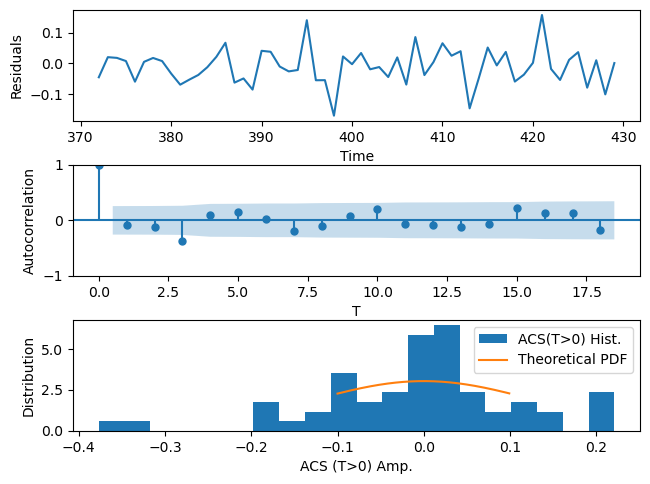

In [74]:
from statsmodels.tsa.arima.model import ARIMA
import scipy.stats as spyst
from statsmodels.tsa.stattools import acf

#Defina a SARIMA structure     p d  q                   P  D. Q.  S
model=ARIMA(unTSTrain, order=(0, 1, 0), seasonal_order=(0, 0, 1, 12))
#Fit model
fit = model.fit()

#Get residuals
res=fit.resid[12:]
#Get fitting performance (AIC)
print("Fitted model AIC="+str(fit.aic))

#Evaluate fitting quality by inspecting residuals at three levels: Time plot, ACS and ACS distribution
fig, axs=plt.subplots(3)
fig.tight_layout()
res.plot(ax=axs[0])
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Residuals')
plot_acf(res,ax=axs[1],title="")
axs[1].set_xlabel("T")
axs[1].set_ylabel("Autocorrelation")

ac=acf(res,nlags=500,fft=False)

axs[2].hist(ac[1:],bins=20,density=True,label='ACS(T>0) Hist.')

N=res.size
rg=np.arange(-0.1,0.1,0.001)
pdf = spyst.norm.pdf(rg,0,1/np.sqrt(N))
plt.plot(rg,pdf,label='Theoretical PDF')
plt.xlabel("ACS (T>0) Amp.")
plt.ylabel("Distribution")
plt.legend()


Forecast RMSE=0.24011148762022416


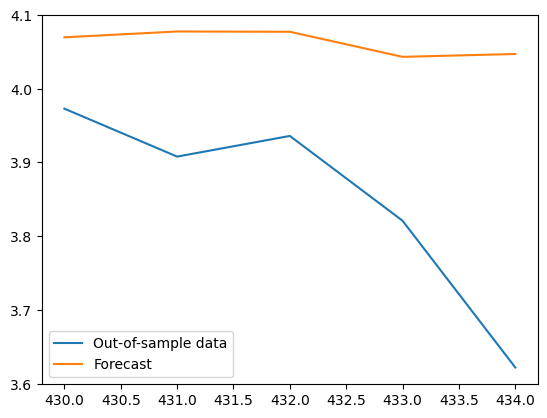

In [75]:
plt.figure()
unTSVal.plot(legend=True)
forecast=fit.forecast(5)
forecast.name="Forecast"
forecast.plot(legend=True)

print("Forecast RMSE="+str(np.sqrt(np.sum((unTSVal-forecast)**2)/forecast.size)))

    Pessimo

### Grid search

In [76]:
rp=range(0,5)
rq=range(0,5)
rP=range(0,5)
rQ=range(0,5)

aicV=np.zeros((len(rp),len(rq),len(rP),len(rQ)))
i=0
for p in rp:
    j=0
    for q in rq:
        k=0
        for P in rP:
            l=0
            for Q in rQ:
                model=ARIMA(unTSTrain, order=(p, 1, q), seasonal_order=(P, 1, Q, 12))
                fit = model.fit()
                aicV[i][j][k][l]=fit.aic
                print("Evaluating p="+str(p)+" q="+str(q)+" P="+str(P)+" Q="+str(Q)+" AIC="+str(fit.aic))
                l=l+1
            k=k+1
        j=j+1
    i=i+1
                
ixs=np.where(aicV==np.min(aicV))
print("Best: p="+str(rp[ixs[0][0]])+", q="+str(rp[ixs[1][0]])+", P="+str(rP[ixs[2][0]])+", Q="+str(rQ[ixs[3][0]])+" AIC="+str(aicV[ixs[0][0]][ixs[1][0]][ixs[2][0]][ixs[3][0]]))

Evaluating p=0 q=0 P=0 Q=0 AIC=-111.44414117543107
Evaluating p=0 q=0 P=0 Q=1 AIC=-138.8042570242652


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=0 P=0 Q=2 AIC=-139.80839322276321


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=0 P=0 Q=3 AIC=-137.84681606577556


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=0 P=0 Q=4 AIC=-136.01289125628932
Evaluating p=0 q=0 P=1 Q=0 AIC=-131.49249070056493
Evaluating p=0 q=0 P=1 Q=1 AIC=-139.5168691913489


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=0 P=1 Q=2 AIC=-136.9995050597548


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=0 P=1 Q=3 AIC=-135.84907791117897


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=0 P=1 Q=4 AIC=-134.4264822789008


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=0 P=2 Q=0 AIC=-135.57651449099498


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=0 P=2 Q=1 AIC=-137.69735583423355


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=0 P=2 Q=2 AIC=-135.6509167320582


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=0 P=2 Q=3 AIC=-134.2436053364435


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=0 P=2 Q=4 AIC=-132.53362442059546


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Evaluating p=0 q=0 P=3 Q=0 AIC=-138.38161984091263


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=0 P=3 Q=1 AIC=-136.53295149359806


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=0 P=3 Q=2 AIC=-134.53158787095606


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=0 P=3 Q=3 AIC=-132.5328908236224


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=0 P=3 Q=4 AIC=-130.53244784723998


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=0 P=4 Q=0 AIC=-136.5339256458315


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Evaluating p=0 q=0 P=4 Q=1 AIC=-134.53385464575567


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=0 P=4 Q=2 AIC=-132.5332719758601


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=0 P=4 Q=3 AIC=-130.53389461492273


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=0 P=4 Q=4 AIC=-128.53387272063497
Evaluating p=0 q=1 P=0 Q=0 AIC=-109.44593463911832
Evaluating p=0 q=1 P=0 Q=1 AIC=-136.89650505209698


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=1 P=0 Q=2 AIC=-138.03669774208154


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=1 P=0 Q=3 AIC=-136.03705083989308


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=1 P=0 Q=4 AIC=-134.1924179590626
Evaluating p=0 q=1 P=1 Q=0 AIC=-130.10435811451515
Evaluating p=0 q=1 P=1 Q=1 AIC=-137.80964583292533


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=1 P=1 Q=2 AIC=-136.0616510040926


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=1 P=1 Q=3 AIC=-134.09138279824703


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=1 P=1 Q=4 AIC=-132.58100703426325
Evaluating p=0 q=1 P=2 Q=0 AIC=-134.2373823495119
Evaluating p=0 q=1 P=2 Q=1 AIC=-135.93109509981687


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=1 P=2 Q=2 AIC=-133.83015477994076


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=1 P=2 Q=3 AIC=-132.35976557263555


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=1 P=2 Q=4 AIC=-130.64360539971142


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Evaluating p=0 q=1 P=3 Q=0 AIC=-136.50524433211982


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=1 P=3 Q=1 AIC=-134.64723206377678


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=1 P=3 Q=2 AIC=-132.54373308355915


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=1 P=3 Q=3 AIC=-130.6465042444693


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=1 P=3 Q=4 AIC=-128.60816331983307
Evaluating p=0 q=1 P=4 Q=0 AIC=-134.6474599640475


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Evaluating p=0 q=1 P=4 Q=1 AIC=-132.6474536765661


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=1 P=4 Q=2 AIC=-130.64741502688062


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=1 P=4 Q=3 AIC=-128.6470612643974


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=1 P=4 Q=4 AIC=-126.64746705877582
Evaluating p=0 q=2 P=0 Q=0 AIC=-113.85186361689165
Evaluating p=0 q=2 P=0 Q=1 AIC=-138.6756729108


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=2 P=0 Q=2 AIC=-139.193463262804


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=2 P=0 Q=3 AIC=-137.18383970574413


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=2 P=0 Q=4 AIC=-135.59992509586357
Evaluating p=0 q=2 P=1 Q=0 AIC=-134.23034956485952


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=2 P=1 Q=1 AIC=-139.12036287219303
Evaluating p=0 q=2 P=1 Q=2 AIC=-137.05116804922395


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=2 P=1 Q=3 AIC=-135.3980212799165


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=2 P=1 Q=4 AIC=-133.82224529240722
Evaluating p=0 q=2 P=2 Q=0 AIC=-135.71300975385833


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=2 P=2 Q=1 AIC=-137.13477601360228


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=2 P=2 Q=2 AIC=-135.27449447566664


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=2 P=2 Q=3 AIC=-133.36387989011544


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=2 P=2 Q=4 AIC=-131.8281996775414


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Evaluating p=0 q=2 P=3 Q=0 AIC=-137.44650444129917


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Evaluating p=0 q=2 P=3 Q=1 AIC=-135.8311069813413


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=2 P=3 Q=2 AIC=-133.834632394395


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=2 P=3 Q=3 AIC=-131.83480266444866


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=2 P=3 Q=4 AIC=-129.8349425924481


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=2 P=4 Q=0 AIC=-135.8349485338294


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Evaluating p=0 q=2 P=4 Q=1 AIC=-133.83479819435652


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=2 P=4 Q=2 AIC=-131.8339320927595


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=2 P=4 Q=3 AIC=-129.8344488276762


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=2 P=4 Q=4 AIC=-127.83501153994789
Evaluating p=0 q=3 P=0 Q=0 AIC=-126.7746406011172


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Evaluating p=0 q=3 P=0 Q=1 AIC=-145.0148432185235


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=3 P=0 Q=2 AIC=-143.89698685040696


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=3 P=0 Q=3 AIC=-141.91459615886353


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=3 P=0 Q=4 AIC=-140.1867333841534
Evaluating p=0 q=3 P=1 Q=0 AIC=-141.06989146248998


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible 

Evaluating p=0 q=3 P=1 Q=1 AIC=-143.9396524909869
Evaluating p=0 q=3 P=1 Q=2 AIC=-142.09429108218183


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=3 P=1 Q=3 AIC=-140.01632386202533


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=3 P=1 Q=4 AIC=-138.33206117253354


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=3 P=2 Q=0 AIC=-141.89580195889025


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=3 P=2 Q=1 AIC=-141.94333085837147


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=3 P=2 Q=2 AIC=-140.09848556294952


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=3 P=2 Q=3 AIC=-138.05605346346192


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=3 P=2 Q=4 AIC=-136.32409408864163


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Evaluating p=0 q=3 P=3 Q=0 AIC=-142.32601342643477


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=3 P=3 Q=1 AIC=-140.29065833268803


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=3 P=3 Q=2 AIC=-138.32583743900764


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=3 P=3 Q=3 AIC=-136.32212744823917


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=3 P=3 Q=4 AIC=-134.33956807305063


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=3 P=4 Q=0 AIC=-140.34012859073817


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=3 P=4 Q=1 AIC=-138.34068004230053


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=3 P=4 Q=2 AIC=-136.34061079237344


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=3 P=4 Q=3 AIC=-134.34007332732995


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=3 P=4 Q=4 AIC=-132.34066008324245
Evaluating p=0 q=4 P=0 Q=0 AIC=-124.84495773894821
Evaluating p=0 q=4 P=0 Q=1 AIC=-143.29166777645378


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=4 P=0 Q=2 AIC=-142.18379280246634


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=4 P=0 Q=3 AIC=-140.19426940803882


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=4 P=0 Q=4 AIC=-138.42479525361944
Evaluating p=0 q=4 P=1 Q=0 AIC=-139.38481758312358


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=4 P=1 Q=1 AIC=-142.22493637817416


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=4 P=1 Q=2 AIC=-140.34144541772383


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=4 P=1 Q=3 AIC=-138.32271401415113


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=4 P=1 Q=4 AIC=-136.60415486533657
Evaluating p=0 q=4 P=2 Q=0 AIC=-140.11716944641836


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=4 P=2 Q=1 AIC=-140.14714087434


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=4 P=2 Q=2 AIC=-138.35304606282304


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=4 P=2 Q=3 AIC=-136.31804446698135


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=4 P=2 Q=4 AIC=-134.6285039314145


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Evaluating p=0 q=4 P=3 Q=0 AIC=-140.6452781540207


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=4 P=3 Q=1 AIC=-138.58180916170573


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=4 P=3 Q=2 AIC=-136.5121608986017


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=4 P=3 Q=3 AIC=-134.64748993983466


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=4 P=3 Q=4 AIC=-132.594863681706


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=4 P=4 Q=0 AIC=-138.6471736637042


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=4 P=4 Q=1 AIC=-136.64690437017


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=4 P=4 Q=2 AIC=-134.64731310168594


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=4 P=4 Q=3 AIC=-132.64838535929357


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=4 P=4 Q=4 AIC=-130.6482525124776
Evaluating p=1 q=0 P=0 Q=0 AIC=-109.44553815130031
Evaluating p=1 q=0 P=0 Q=1 AIC=-136.86272200831252


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=0 P=0 Q=2 AIC=-137.91283541184453


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=0 P=0 Q=3 AIC=-135.96202546420233


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=0 P=0 Q=4 AIC=-134.1251145031353
Evaluating p=1 q=0 P=1 Q=0 AIC=-129.81819382505765
Evaluating p=1 q=0 P=1 Q=1 AIC=-137.68044507438907


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=0 P=1 Q=2 AIC=-135.9860625920785


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=0 P=1 Q=3 AIC=-133.9730390960985


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=0 P=1 Q=4 AIC=-132.49310140869952
Evaluating p=1 q=0 P=2 Q=0 AIC=-133.9502732173308
Evaluating p=1 q=0 P=2 Q=1 AIC=-135.85231270269915


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=0 P=2 Q=2 AIC=-133.70563089770846


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=0 P=2 Q=3 AIC=-132.24403247467237


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=0 P=2 Q=4 AIC=-130.478734229157


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Evaluating p=1 q=0 P=3 Q=0 AIC=-136.45460261658508


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Evaluating p=1 q=0 P=3 Q=1 AIC=-134.59960627653462


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=0 P=3 Q=2 AIC=-132.59967973571472


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=0 P=3 Q=3 AIC=-130.49022669042358


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=0 P=3 Q=4 AIC=-128.59874667649484


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=0 P=4 Q=0 AIC=-134.59882881905398


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Evaluating p=1 q=0 P=4 Q=1 AIC=-132.59997352755286


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=0 P=4 Q=2 AIC=-130.59992095160956


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=0 P=4 Q=3 AIC=-128.59992321363458


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=0 P=4 Q=4 AIC=-126.59995415974453
Evaluating p=1 q=1 P=0 Q=0 AIC=-107.45119962962096
Evaluating p=1 q=1 P=0 Q=1 AIC=-134.986323686602


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as s

Evaluating p=1 q=1 P=0 Q=2 AIC=-136.23656241538424


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=1 P=0 Q=3 AIC=-134.21669347409062


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=1 P=0 Q=4 AIC=-132.36955578522188
Evaluating p=1 q=1 P=1 Q=0 AIC=-128.3357643035015


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as s

Evaluating p=1 q=1 P=1 Q=1 AIC=-135.98258588781593


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=1 q=1 P=1 Q=2 AIC=-134.1807953119529


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=1 q=1 P=1 Q=3 AIC=-132.3017999142213


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=1 q=1 P=1 Q=4 AIC=-130.6928376393443


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Evaluating p=1 q=1 P=2 Q=0 AIC=-132.45248041552384


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=1 P=2 Q=1 AIC=-134.15112417398933


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=1 P=2 Q=2 AIC=-132.03928199400866


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=1 q=1 P=2 Q=3 AIC=-130.54419709566378


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=1 q=1 P=2 Q=4 AIC=-128.6873929851076


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warni

Evaluating p=1 q=1 P=3 Q=0 AIC=-134.6457389912795


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warni

Evaluating p=1 q=1 P=3 Q=1 AIC=-132.78185846318328


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=1 P=3 Q=2 AIC=-130.77858324180764


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=1 q=1 P=3 Q=3 AIC=-128.79568508709022


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=1 q=1 P=3 Q=4 AIC=-126.76895126932962


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=1 P=4 Q=0 AIC=-132.6403586310931


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warni

Evaluating p=1 q=1 P=4 Q=1 AIC=-130.71793469577347


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=1 q=1 P=4 Q=2 AIC=-128.79695079846286


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=1 q=1 P=4 Q=3 AIC=-126.79884524317373


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=1 q=1 P=4 Q=4 AIC=-124.79975200994241
Evaluating p=1 q=2 P=0 Q=0 AIC=-116.16282643001627
Evaluating p=1 q=2 P=0 Q=1 AIC=-139.88514830606007


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=2 P=0 Q=2 AIC=-139.82252566194896


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=2 P=0 Q=3 AIC=-137.82702249876945


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=2 P=0 Q=4 AIC=-136.30110041819552
Evaluating p=1 q=2 P=1 Q=0 AIC=-135.5023672164389


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=2 P=1 Q=1 AIC=-139.84305791429372


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=2 P=1 Q=2 AIC=-137.9544276360984


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=2 P=1 Q=3 AIC=-136.04157314232157


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=2 P=1 Q=4 AIC=-134.44404455605226
Evaluating p=1 q=2 P=2 Q=0 AIC=-136.83225649324825


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=2 P=2 Q=1 AIC=-136.6588028784402


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=2 P=2 Q=2 AIC=-136.05773461245232


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=2 P=2 Q=3 AIC=-134.11877240083186


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=2 P=2 Q=4 AIC=-132.46460953202745


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=2 P=3 Q=0 AIC=-138.08860142010954


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=2 P=3 Q=1 AIC=-136.46404330219147


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=2 P=3 Q=2 AIC=-134.47125740383993


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=2 P=3 Q=3 AIC=-132.47135679442687


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=2 P=3 Q=4 AIC=-130.4707280025275


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=2 P=4 Q=0 AIC=-136.2911421568486


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=2 P=4 Q=1 AIC=-134.45609193625484


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=2 P=4 Q=2 AIC=-132.46520624897192


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=2 P=4 Q=3 AIC=-130.46304925012515


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=2 P=4 Q=4 AIC=-128.45760936619726
Evaluating p=1 q=3 P=0 Q=0 AIC=-124.8194842701563


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Evaluating p=1 q=3 P=0 Q=1 AIC=-143.25064620682613


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=3 P=0 Q=2 AIC=-142.14728235686383


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=3 P=0 Q=3 AIC=-140.1543163979487


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=3 P=0 Q=4 AIC=-138.42182852515663


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Evaluating p=1 q=3 P=1 Q=0 AIC=-139.26362079975777


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for varian

Evaluating p=1 q=3 P=1 Q=1 AIC=-142.18220049920998


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=3 P=1 Q=2 AIC=-140.2866141781468


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=3 P=1 Q=3 AIC=-138.2779442410072


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=3 P=1 Q=4 AIC=-136.52497635703224


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=3 P=2 Q=0 AIC=-140.04792724352902


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=3 P=2 Q=1 AIC=-139.98155621378206


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=3 P=2 Q=2 AIC=-138.2571832283421


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=3 P=2 Q=3 AIC=-136.22039097365158


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=3 P=2 Q=4 AIC=-134.50931332937404


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=3 P=3 Q=0 AIC=-140.58978856895948


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=3 P=3 Q=1 AIC=-138.53145997250527


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=3 P=3 Q=2 AIC=-136.52222583290163


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=3 P=3 Q=3 AIC=-134.5536022009478


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=3 P=3 Q=4 AIC=-132.5450592891147


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=3 P=4 Q=0 AIC=-138.56914919318072


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=3 P=4 Q=1 AIC=-136.61894411846956


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=3 P=4 Q=2 AIC=-134.62061474802934


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=3 P=4 Q=3 AIC=-132.6218374046263


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=3 P=4 Q=4 AIC=-130.61656556888894
Evaluating p=1 q=4 P=0 Q=0 AIC=-124.22282745935513


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=4 P=0 Q=1 AIC=-141.5405330815865


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=4 P=0 Q=2 AIC=-140.24012213818247


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=4 P=0 Q=3 AIC=-138.2710955971235


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=4 P=0 Q=4 AIC=-136.4503410465908


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=4 P=1 Q=0 AIC=-139.32973523467265


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=4 P=1 Q=1 AIC=-140.28101022853306


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=4 P=1 Q=2 AIC=-138.4184951356148


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=4 P=1 Q=3 AIC=-136.39435139483004


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=4 P=1 Q=4 AIC=-134.67247171842254


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=4 P=2 Q=0 AIC=-138.25399538402075


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=4 P=2 Q=1 AIC=-138.03493489909357


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=4 P=2 Q=2 AIC=-136.31983461174


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=4 P=2 Q=3 AIC=-134.437116602925


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=4 P=2 Q=4 AIC=-132.69986195710493


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=4 P=3 Q=0 AIC=-138.691684530903


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=4 P=3 Q=1 AIC=-136.71288546469788


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=4 P=3 Q=2 AIC=-134.69886826226906


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=4 P=3 Q=3 AIC=-132.59656692523814


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=4 P=3 Q=4 AIC=-130.6983003608957


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=4 P=4 Q=0 AIC=-136.67630668625648


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=4 P=4 Q=1 AIC=-134.69316607810515


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=4 P=4 Q=2 AIC=-132.6939931633149


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=4 P=4 Q=3 AIC=-130.69073688065328


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=4 P=4 Q=4 AIC=-128.69358917380816
Evaluating p=2 q=0 P=0 Q=0 AIC=-108.20152585878532
Evaluating p=2 q=0 P=0 Q=1 AIC=-137.3291467069029


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=0 P=0 Q=2 AIC=-139.2918245749196


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=0 P=0 Q=3 AIC=-137.2751928674359


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=0 P=0 Q=4 AIC=-135.5118805072405
Evaluating p=2 q=0 P=1 Q=0 AIC=-133.1086930308143


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=0 P=1 Q=1 AIC=-139.34594030932607


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=0 P=1 Q=2 AIC=-137.35649422455637


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=0 P=1 Q=3 AIC=-135.47134658476338


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=0 P=1 Q=4 AIC=-133.61632326519563
Evaluating p=2 q=0 P=2 Q=0 AIC=-136.42477318252216


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=0 P=2 Q=1 AIC=-137.3329886266332


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=0 P=2 Q=2 AIC=-135.36349437790045


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=0 P=2 Q=3 AIC=-133.61700837852226


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=0 P=2 Q=4 AIC=-131.61766307498786


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Evaluating p=2 q=0 P=3 Q=0 AIC=-137.37620731416524


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Evaluating p=2 q=0 P=3 Q=1 AIC=-135.65102892193448


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=0 P=3 Q=2 AIC=-133.64476463741101


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=0 P=3 Q=3 AIC=-131.64907886271874


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=0 P=3 Q=4 AIC=-129.64858243003584


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=0 P=4 Q=0 AIC=-135.6473665839456


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=0 P=4 Q=1 AIC=-133.650739470489


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=0 P=4 Q=2 AIC=-131.65069866553392


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=0 P=4 Q=3 AIC=-129.64776914512885


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=0 P=4 Q=4 AIC=-127.65080540141855
Evaluating p=2 q=1 P=0 Q=0 AIC=-118.69898257183843


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parame

Evaluating p=2 q=1 P=0 Q=1 AIC=-141.74906448958916


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=1 P=0 Q=2 AIC=-141.3185259184934


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=2 q=1 P=0 Q=3 AIC=-139.42468655420822


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=1 P=0 Q=4 AIC=-137.73485653957337


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Evaluating p=2 q=1 P=1 Q=0 AIC=-138.66584475770264


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parame

Evaluating p=2 q=1 P=1 Q=1 AIC=-141.42851087582687
Evaluating p=2 q=1 P=1 Q=2 AIC=-139.6814687517704


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=2 q=1 P=1 Q=3 AIC=-137.7346401322294


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=2 q=1 P=1 Q=4 AIC=-135.8210198275283


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Evaluating p=2 q=1 P=2 Q=0 AIC=-139.24395313000446


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=1 P=2 Q=1 AIC=-139.365999753271


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=2 q=1 P=2 Q=2 AIC=-137.692264203155


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=2 q=1 P=2 Q=3 AIC=-135.6871416256664


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=1 P=2 Q=4 AIC=-133.90611160917348


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warni

Evaluating p=2 q=1 P=3 Q=0 AIC=-139.64072935365698


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warni

Evaluating p=2 q=1 P=3 Q=1 AIC=-137.91346424891415


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=1 P=3 Q=2 AIC=-135.9096529331299


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=1 P=3 Q=3 AIC=-133.90902535569452


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=1 P=3 Q=4 AIC=-131.9119224490383


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=1 P=4 Q=0 AIC=-137.8720442736134


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warni

Evaluating p=2 q=1 P=4 Q=1 AIC=-135.9143123602023


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=2 q=1 P=4 Q=2 AIC=-133.89699870530504


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=2 q=1 P=4 Q=3 AIC=-131.91279139659315


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=2 q=1 P=4 Q=4 AIC=-129.91137917865396
Evaluating p=2 q=2 P=0 Q=0 AIC=-118.49914086465782
Evaluating p=2 q=2 P=0 Q=1 AIC=-140.17298224425937


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=2 P=0 Q=2 AIC=-139.48503225832513


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=2 P=0 Q=3 AIC=-137.56888394046914


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=2 P=0 Q=4 AIC=-135.8935392502793
Evaluating p=2 q=2 P=1 Q=0 AIC=-136.86461320888353


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=2 P=1 Q=1 AIC=-139.53396448347164
Evaluating p=2 q=2 P=1 Q=2 AIC=-137.87063821661135


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=2 P=1 Q=3 AIC=-135.84056118041764


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=2 P=1 Q=4 AIC=-133.9392562673418


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=2 P=2 Q=0 AIC=-137.40986179867966


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=2 P=2 Q=1 AIC=-137.41578671152462


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=2 P=2 Q=2 AIC=-135.84425740103373


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=2 P=2 Q=3 AIC=-133.88858665163082


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=2 P=2 Q=4 AIC=-132.02365226454222


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=2 P=3 Q=0 AIC=-137.80125659370557


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=2 P=3 Q=1 AIC=-136.01080483038257


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=2 P=3 Q=2 AIC=-134.01823776898993


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=2 P=3 Q=3 AIC=-132.0455563679294


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=2 P=3 Q=4 AIC=-130.00920955592446


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=2 P=4 Q=0 AIC=-135.29447965828587


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=2 P=4 Q=1 AIC=-134.0597726076831


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=2 P=4 Q=2 AIC=-132.0290584637797


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=2 P=4 Q=3 AIC=-129.982301029373


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=2 P=4 Q=4 AIC=-128.05972333684448
Evaluating p=2 q=3 P=0 Q=0 AIC=-124.58457505544837


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible 

Evaluating p=2 q=3 P=0 Q=1 AIC=-141.61429891555133


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=3 P=0 Q=2 AIC=-140.14958957078628


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=3 P=0 Q=3 AIC=-138.18995740040054


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=3 P=0 Q=4 AIC=-136.38651117312386


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Evaluating p=2 q=3 P=1 Q=0 AIC=-138.21335217986848


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=3 P=1 Q=1 AIC=-140.1894559977245
Evaluating p=2 q=3 P=1 Q=2 AIC=-138.298858310709


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=3 P=1 Q=3 AIC=-136.30622905719838


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=3 P=1 Q=4 AIC=-134.51619622113225


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=3 P=2 Q=0 AIC=-138.43632795338596


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=3 P=2 Q=1 AIC=-138.191576402618


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=3 P=2 Q=2 AIC=-136.3006681368071


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=3 P=2 Q=3 AIC=-134.23958115140994


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=3 P=2 Q=4 AIC=-132.52568885543684


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=3 P=3 Q=0 AIC=-138.56351170933635


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=3 P=3 Q=1 AIC=-136.51454037593516


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=3 P=3 Q=2 AIC=-134.4683104532915


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=3 P=3 Q=3 AIC=-132.50951109829694


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=3 P=3 Q=4 AIC=-130.57284109745257


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=3 P=4 Q=0 AIC=-136.57266568822558


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=3 P=4 Q=1 AIC=-134.5626724799441


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=3 P=4 Q=2 AIC=-132.56994134792797


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=3 P=4 Q=3 AIC=-130.5719878612163


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=3 P=4 Q=4 AIC=-128.5726696878392
Evaluating p=2 q=4 P=0 Q=0 AIC=-122.77307994902816


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=4 P=0 Q=1 AIC=-139.5674805425242
Evaluating p=2 q=4 P=0 Q=2 AIC=-138.2532155505955


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=4 P=0 Q=3 AIC=-136.30976673704563


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=4 P=0 Q=4 AIC=-134.68101485839153


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=4 P=1 Q=0 AIC=-136.11786998152


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=4 P=1 Q=1 AIC=-138.3085308060487


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=4 P=1 Q=2 AIC=-136.52267937009387


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=4 P=1 Q=3 AIC=-134.49488665423598


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=4 P=1 Q=4 AIC=-132.7322121201906


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=4 P=2 Q=0 AIC=-136.55543794017856


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=4 P=2 Q=1 AIC=-135.81826239807125


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=4 P=2 Q=2 AIC=-134.49454655050226


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=4 P=2 Q=3 AIC=-132.4563654922377


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=4 P=2 Q=4 AIC=-130.88564981169975


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=4 P=3 Q=0 AIC=-136.86351849033682


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=4 P=3 Q=1 AIC=-134.94477460402982


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=4 P=3 Q=2 AIC=-132.86806574086654


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=4 P=3 Q=3 AIC=-130.87062448773528


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=4 P=3 Q=4 AIC=-128.8358488411788


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=4 P=4 Q=0 AIC=-135.2391890512013


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=4 P=4 Q=1 AIC=-133.07005687521158


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=4 P=4 Q=2 AIC=-130.93762579867246


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=4 P=4 Q=3 AIC=-128.91174564377366


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=4 P=4 Q=4 AIC=-126.92793905137106
Evaluating p=3 q=0 P=0 Q=0 AIC=-125.32052598088049


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=3 q=0 P=0 Q=1 AIC=-145.299514768948
Evaluating p=3 q=0 P=0 Q=2 AIC=-144.15335369945504


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=3 q=0 P=0 Q=3 AIC=-142.1593167771601


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=0 P=0 Q=4 AIC=-140.50187817446803
Evaluating p=3 q=0 P=1 Q=0 AIC=-141.31003678303784


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=3 q=0 P=1 Q=1 AIC=-144.17856045869058


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=0 P=1 Q=2 AIC=-142.31384286441696


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=0 P=1 Q=3 AIC=-140.38581957865807


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=0 P=1 Q=4 AIC=-138.72048710654906
Evaluating p=3 q=0 P=2 Q=0 AIC=-142.18027065166595


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=0 P=2 Q=1 AIC=-142.09547528665487


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=0 P=2 Q=2 AIC=-140.34790939325595


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=0 P=2 Q=3 AIC=-138.26037036988862


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=0 P=2 Q=4 AIC=-136.74225239923427


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Evaluating p=3 q=0 P=3 Q=0 AIC=-142.7289866869799


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=0 P=3 Q=1 AIC=-140.61893791707107


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=0 P=3 Q=2 AIC=-138.7192926056749


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=0 P=3 Q=3 AIC=-136.74058155792645


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=0 P=3 Q=4 AIC=-134.73139394765005


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=0 P=4 Q=0 AIC=-140.72717689149175


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=0 P=4 Q=1 AIC=-138.73493215756127


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=0 P=4 Q=2 AIC=-136.73404822278542


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=3 q=0 P=4 Q=3 AIC=-134.73496667992012


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=0 P=4 Q=4 AIC=-132.73507398641823
Evaluating p=3 q=1 P=0 Q=0 AIC=-123.53459331854617
Evaluating p=3 q=1 P=0 Q=1 AIC=-143.3592993041893


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=1 P=0 Q=2 AIC=-142.3378186196334


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=3 q=1 P=0 Q=3 AIC=-140.3508761378625


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=1 P=0 Q=4 AIC=-138.5375789603248
Evaluating p=3 q=1 P=1 Q=0 AIC=-139.35736954674792
Evaluating p=3 q=1 P=1 Q=1 AIC=-142.35156200168825


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=3 q=1 P=1 Q=2 AIC=-140.40406956487948


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=1 P=1 Q=3 AIC=-138.42130720877572


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=1 P=1 Q=4 AIC=-136.7617625456436


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=1 P=2 Q=0 AIC=-140.34213629962966


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=1 P=2 Q=1 AIC=-139.61667308293303


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=1 P=2 Q=2 AIC=-138.39863318744764


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=1 P=2 Q=3 AIC=-136.39783077611864


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=1 P=2 Q=4 AIC=-134.83010894595668


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=1 P=3 Q=0 AIC=-140.9361982676906


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=1 P=3 Q=1 AIC=-138.76975711170385


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=1 P=3 Q=2 AIC=-136.6902304645686


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=1 P=3 Q=3 AIC=-134.89455913080698


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=1 P=3 Q=4 AIC=-132.87000330889552


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=1 P=4 Q=0 AIC=-138.71685447946965


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=1 P=4 Q=1 AIC=-136.9715626808061


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=1 P=4 Q=2 AIC=-134.96214495534446


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=1 P=4 Q=3 AIC=-132.95902017038085


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=1 P=4 Q=4 AIC=-130.96945205971818
Evaluating p=3 q=2 P=0 Q=0 AIC=-123.33350611183297
Evaluating p=3 q=2 P=0 Q=1 AIC=-141.61236482573062


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=2 P=0 Q=2 AIC=-140.41138808576972


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=2 P=0 Q=3 AIC=-138.43606892427792


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=3 q=2 P=0 Q=4 AIC=-136.6463674980942


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=2 P=1 Q=0 AIC=-137.6222304473342


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=3 q=2 P=1 Q=1 AIC=-140.444791062713


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=2 P=1 Q=2 AIC=-138.54332277863358


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=2 P=1 Q=3 AIC=-136.53242038812442


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=2 P=1 Q=4 AIC=-134.84111136880006
Evaluating p=3 q=2 P=2 Q=0 AIC=-138.3966734568211
Evaluating p=3 q=2 P=2 Q=1 AIC=-138.44369581197904


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=2 P=2 Q=2 AIC=-136.49490933575237


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=2 P=2 Q=3 AIC=-134.46022591504553


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=2 P=2 Q=4 AIC=-132.91274114841778


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=2 P=3 Q=0 AIC=-139.03029133153558


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=2 P=3 Q=1 AIC=-136.8922335377744


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=2 P=3 Q=2 AIC=-134.79053760669873


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=2 P=3 Q=3 AIC=-132.89740155787052


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=2 P=3 Q=4 AIC=-130.96076548755715


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=2 P=4 Q=0 AIC=-137.04484577490436


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=2 P=4 Q=1 AIC=-134.96551781154676


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=2 P=4 Q=2 AIC=-133.0523341919795


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=2 P=4 Q=3 AIC=-131.05300551578566


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=2 P=4 Q=4 AIC=-129.04502535942163
Evaluating p=3 q=3 P=0 Q=0 AIC=-123.5745660067893
Evaluating p=3 q=3 P=0 Q=1 AIC=-140.28144733347244


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=3 P=0 Q=2 AIC=-138.78415165160803


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=3 P=0 Q=3 AIC=-136.6781882176199


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=3 P=0 Q=4 AIC=-134.8963890824693


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=3 P=1 Q=0 AIC=-136.78523852438246


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=3 q=3 P=1 Q=1 AIC=-138.84005625156541


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=3 P=1 Q=2 AIC=-137.03742083195502


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=3 P=1 Q=3 AIC=-134.86045212059608


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=3 P=1 Q=4 AIC=-133.2872356908563


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=3 P=2 Q=0 AIC=-136.97994805311168


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=3 P=2 Q=1 AIC=-134.68402359175158


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=3 P=2 Q=2 AIC=-135.0218582358239


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=3 P=2 Q=3 AIC=-132.76529022729062


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=3 P=2 Q=4 AIC=-131.40704072571376


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=3 P=3 Q=0 AIC=-137.35330211056223


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=3 P=3 Q=1 AIC=-135.37528628114808


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=3 q=3 P=3 Q=2 AIC=-132.9935354443849


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=3 P=3 Q=3 AIC=-131.3268202517367


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=3 P=3 Q=4 AIC=-129.45513578122686


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=3 P=4 Q=0 AIC=-135.19354302431475


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=3 P=4 Q=1 AIC=-133.34700917965043


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=3 P=4 Q=2 AIC=-131.44812815614236


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=3 P=4 Q=3 AIC=-129.3216198350408


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=3 P=4 Q=4 AIC=-127.3404551888178


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=4 P=0 Q=0 AIC=-122.11132902562508


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=3 q=4 P=0 Q=1 AIC=-137.85618985001437


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=4 P=0 Q=2 AIC=-136.55527030374367


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=4 P=0 Q=3 AIC=-134.6240953051082


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=4 P=0 Q=4 AIC=-132.65029074176277


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=4 P=1 Q=0 AIC=-134.71444978365724


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=3 q=4 P=1 Q=1 AIC=-136.4698316291203


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=4 P=1 Q=2 AIC=-134.74832226099358


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=4 P=1 Q=3 AIC=-132.79384836165022


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=4 P=1 Q=4 AIC=-130.77289528478772


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=4 P=2 Q=0 AIC=-134.85502665581782


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=4 P=2 Q=1 AIC=-134.43412455442706


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=4 P=2 Q=2 AIC=-132.8144917486322


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=4 P=2 Q=3 AIC=-130.75093471193475


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=4 P=2 Q=4 AIC=-129.14281116623127


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=4 P=3 Q=0 AIC=-135.0567811211503


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=4 P=3 Q=1 AIC=-133.30335642557154


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=4 P=3 Q=2 AIC=-131.16662530120036


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=4 P=3 Q=3 AIC=-129.04565406409446


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=4 P=3 Q=4 AIC=-126.80407685587528


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=4 P=4 Q=0 AIC=-132.94455962867207


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=4 P=4 Q=1 AIC=-130.93267036923183


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=4 P=4 Q=2 AIC=-129.16092713976263


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=4 P=4 Q=3 AIC=-126.93742350252091


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=4 P=4 Q=4 AIC=-125.01136917392557
Evaluating p=4 q=0 P=0 Q=0 AIC=-123.47698594292774
Evaluating p=4 q=0 P=0 Q=1 AIC=-143.34151840208085


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=0 P=0 Q=2 AIC=-142.30305505972947


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=4 q=0 P=0 Q=3 AIC=-140.30469606945437


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=0 P=0 Q=4 AIC=-138.5955023281645
Evaluating p=4 q=0 P=1 Q=0 AIC=-139.34632204235257


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=4 q=0 P=1 Q=1 AIC=-142.2879436610655


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=0 P=1 Q=2 AIC=-140.36570016739665


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=4 q=0 P=1 Q=3 AIC=-138.38068057852092


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=0 P=1 Q=4 AIC=-136.8555928113186
Evaluating p=4 q=0 P=2 Q=0 AIC=-140.30994009058276


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=0 P=2 Q=1 AIC=-139.17769430372263


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=0 P=2 Q=2 AIC=-138.30863260547008


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=0 P=2 Q=3 AIC=-136.35203725376607


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=0 P=2 Q=4 AIC=-134.901603251824


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Evaluating p=4 q=0 P=3 Q=0 AIC=-140.8849678709544


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=0 P=3 Q=1 AIC=-138.82483488563417


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=0 P=3 Q=2 AIC=-136.74711522968505


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=0 P=3 Q=3 AIC=-134.80481875148755


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=0 P=3 Q=4 AIC=-132.90741771730615


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=0 P=4 Q=0 AIC=-138.91219000813848


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=0 P=4 Q=1 AIC=-136.90570040384446


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=0 P=4 Q=2 AIC=-134.91176422553957


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=0 P=4 Q=3 AIC=-132.91173737586627


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=0 P=4 Q=4 AIC=-130.9095918174804
Evaluating p=4 q=1 P=0 Q=0 AIC=-124.55746000469006


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=4 q=1 P=0 Q=1 AIC=-141.3902743500154


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=1 P=0 Q=2 AIC=-140.32124618538458


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=1 P=0 Q=3 AIC=-138.313790155186


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=1 P=0 Q=4 AIC=-136.6282210757287
Evaluating p=4 q=1 P=1 Q=0 AIC=-137.35039367332263


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=4 q=1 P=1 Q=1 AIC=-140.32583611541176


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=1 P=1 Q=2 AIC=-138.3769809439244


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=1 P=1 Q=3 AIC=-136.452599009897


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=1 P=1 Q=4 AIC=-134.75230649854268
Evaluating p=4 q=1 P=2 Q=0 AIC=-138.32023892120694


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=1 P=2 Q=1 AIC=-138.30051052055722


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=1 P=2 Q=2 AIC=-136.37372071996657


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=1 P=2 Q=3 AIC=-134.36208662648565


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=1 P=2 Q=4 AIC=-132.73321143042017


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=1 P=3 Q=0 AIC=-138.88950083972708


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=1 P=3 Q=1 AIC=-136.81287667370333


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=1 P=3 Q=2 AIC=-134.90764562274407


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=1 P=3 Q=3 AIC=-132.92664933221593


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=1 P=3 Q=4 AIC=-130.89384157857822


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=1 P=4 Q=0 AIC=-136.87673635051635


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=1 P=4 Q=1 AIC=-134.91818789920947


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=1 P=4 Q=2 AIC=-132.92320797462548


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=1 P=4 Q=3 AIC=-130.92073861693723


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=1 P=4 Q=4 AIC=-128.91869643453285
Evaluating p=4 q=2 P=0 Q=0 AIC=-122.7756500348365


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as s

Evaluating p=4 q=2 P=0 Q=1 AIC=-140.11962568913015


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=2 P=0 Q=2 AIC=-138.72834385951623


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=4 q=2 P=0 Q=3 AIC=-136.72441781505145


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=4 q=2 P=0 Q=4 AIC=-135.15798503601292


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parame

Evaluating p=4 q=2 P=1 Q=0 AIC=-136.9820238584543


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters 

Evaluating p=4 q=2 P=1 Q=1 AIC=-138.7856524410395


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=2 P=1 Q=2 AIC=-137.02726088594147


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=4 q=2 P=1 Q=3 AIC=-134.8361095646926


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=4 q=2 P=1 Q=4 AIC=-133.31095584876903


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=2 P=2 Q=0 AIC=-136.76609054314838


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=2 P=2 Q=1 AIC=-134.2847313555311


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=4 q=2 P=2 Q=2 AIC=-135.0099639384716


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=4 q=2 P=2 Q=3 AIC=-132.92523112855923


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=4 q=2 P=2 Q=4 AIC=-131.2331363954469


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warni

Evaluating p=4 q=2 P=3 Q=0 AIC=-137.16655480759536


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warni

Evaluating p=4 q=2 P=3 Q=1 AIC=-135.07716549962524


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=4 q=2 P=3 Q=2 AIC=-133.603832218775


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=4 q=2 P=3 Q=3 AIC=-131.39264756949382


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=4 q=2 P=3 Q=4 AIC=-129.45561730612243


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=2 P=4 Q=0 AIC=-135.41442227605268


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warni

Evaluating p=4 q=2 P=4 Q=1 AIC=-133.29928145509717


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=4 q=2 P=4 Q=2 AIC=-131.49365731044085


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=4 q=2 P=4 Q=3 AIC=-129.4799573315299


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=4 q=2 P=4 Q=4 AIC=-127.43288792368946
Evaluating p=4 q=3 P=0 Q=0 AIC=-121.87644525255203


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible 

Evaluating p=4 q=3 P=0 Q=1 AIC=-138.4818207814305


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=3 P=0 Q=2 AIC=-137.13636155672054


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=3 P=0 Q=3 AIC=-135.1432816515493


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=3 P=0 Q=4 AIC=-133.40658069021467


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Evaluating p=4 q=3 P=1 Q=0 AIC=-135.1210166775886


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=4 q=3 P=1 Q=1 AIC=-137.15743995691915


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=3 P=1 Q=2 AIC=-135.2685527994148


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=3 P=1 Q=3 AIC=-133.23175271295548


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=3 P=1 Q=4 AIC=-131.69143233323646


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=3 P=2 Q=0 AIC=-135.29490842937986


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=3 P=2 Q=1 AIC=-134.82844103170285


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=3 P=2 Q=2 AIC=-133.2047277247098


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=3 P=2 Q=3 AIC=-131.2516643810846


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=3 P=2 Q=4 AIC=-129.5932615634789


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=3 P=3 Q=0 AIC=-135.73755034361068


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=3 P=3 Q=1 AIC=-133.64870141565447


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=3 P=3 Q=2 AIC=-131.49712587219892


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=3 P=3 Q=3 AIC=-129.5943410481855


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=3 P=3 Q=4 AIC=-127.73249532261897


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=3 P=4 Q=0 AIC=-133.7876660917592


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=3 P=4 Q=1 AIC=-131.61273800525245


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=3 P=4 Q=2 AIC=-129.74339753308715


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=3 P=4 Q=3 AIC=-127.77211207089897


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=3 P=4 Q=4 AIC=-125.7811985273309


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=4 P=0 Q=0 AIC=-119.79109855760785


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=4 q=4 P=0 Q=1 AIC=-136.40598872938662


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=4 P=0 Q=2 AIC=-135.09189990619882


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=4 P=0 Q=3 AIC=-132.9312737396363


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=4 P=0 Q=4 AIC=-131.2323305792717


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=4 P=1 Q=0 AIC=-132.65966571160232


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=4 q=4 P=1 Q=1 AIC=-134.98231929332317


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=4 P=1 Q=2 AIC=-133.13799225257023


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=4 P=1 Q=3 AIC=-131.20440542565095


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=4 P=1 Q=4 AIC=-129.41972626525336


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=4 P=2 Q=0 AIC=-133.2802424785607


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=4 P=2 Q=1 AIC=-130.65940981246652


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=4 P=2 Q=2 AIC=-130.93506447867745


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=4 P=2 Q=3 AIC=-129.13799279722252


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=4 P=2 Q=4 AIC=-127.4355096778661


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=4 P=3 Q=0 AIC=-133.72793818805062


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=4 P=3 Q=1 AIC=-132.14282954633268


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=4 P=3 Q=2 AIC=-129.29641835322968


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=4 P=3 Q=3 AIC=-127.40706850550134


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=4 P=3 Q=4 AIC=-125.48396514669878


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=4 P=4 Q=0 AIC=-131.4664939085457


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=4 P=4 Q=1 AIC=-129.73675173501115


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=4 P=4 Q=2 AIC=-127.70566292773253


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=4 P=4 Q=3 AIC=-125.71737396343548


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=4 q=4 P=4 Q=4 AIC=-123.68291407808647
Best: p=3, q=0, P=0, Q=1 AIC=-145.299514768948


In [77]:
ixs=np.where(aicV==np.min(aicV))
print("Best: p="+str(rp[ixs[0][0]])+", q="+str(rp[ixs[1][0]])+", P="+str(rP[ixs[2][0]])+", Q="+str(rQ[ixs[3][0]])+" AIC="+str(aicV[ixs[0][0]][ixs[1][0]][ixs[2][0]][ixs[3][0]]))

Best: p=3, q=0, P=0, Q=1 AIC=-145.299514768948


Fitted model AIC=-135.57651449099498
Forecast RMSE=0.23856252333017502


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


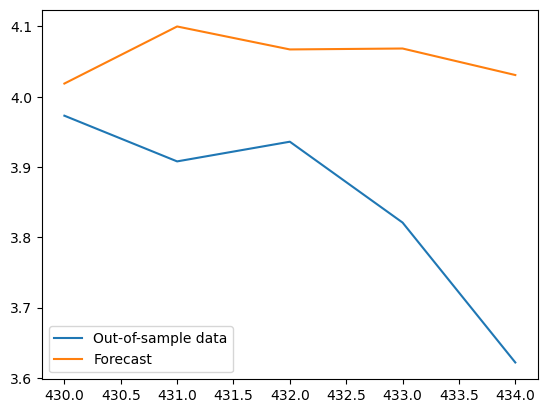

In [78]:
#Define a SARIMA structure with the best p, q, P and Q from grid-search.
model=ARIMA(unTSTrain, order=(0, 1, 0), seasonal_order=(2, 1, 0, 12))
#model=ARIMA(unTSTrain, order=(3, 1, 5), seasonal_order=(2, 1, 2, 40))
fit = model.fit()
res=fit.resid[1:]
print("Fitted model AIC="+str(fit.aic))

#Compare graphically forecasts with the true TS values
plt.figure()
unTSVal.plot(legend=True)
forecast=fit.forecast(5)
forecast.name="Forecast"
forecast.plot(legend=True)

#Compute RMSE
print("Forecast RMSE="+str(np.sqrt(np.sum((unTSVal-forecast)**2)/forecast.size)))

## Avaliar Box-Jenkis

In [79]:
import statistics
import numpy as np

unTS = merged_data["Close_crude"]

list_RMSE = []
list_MAFE = []
list_U2 = []
model=ARIMA(unTSTrain, order=(0, 1, 0), seasonal_order=(2, 1, 0, 12))
fit = model.fit()
for i in range(0, len(unTS) - 75,5):
    

    unTSTrain=unTS[0+i:70+i]
    unTSTrain.name="In-sample data"

    unTSVal=unTS[70+i:75+i]
    unTSVal.name="Out-of-sample data"
    
    
    fit = fit.apply(unTSTrain)
    res=fit.resid[1:]
    print("Fitted model AIC="+str(fit.aic))

    forecast=fit.forecast(5)

    RMSE = np.sqrt(np.sum((unTSVal-forecast)**2)/forecast.size)
    print("Forecast RMSE="+str(RMSE))

    MAFE = np.mean(np.abs((unTSVal - forecast) / unTSVal))
    print("Forecast MAFE="+str(MAFE))

    U2 = np.sqrt(np.sum((unTSVal - forecast)**2) / np.sum((unTSVal - np.mean(unTSVal))**2))
    print("Forecast U2="+str(U2))

    list_RMSE.append(RMSE)
    list_MAFE.append(MAFE)
    list_U2.append(U2)

print("Em média o RMSE deste modelo é: ",statistics.mean(list_RMSE))
print("Em média o MAFE deste modelo é: ",statistics.mean(list_MAFE))
print("Em média o U2 deste modelo é: ",statistics.mean(list_U2))


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted model AIC=60109.573383867726
Forecast RMSE=2.1777372798517987
Forecast MAFE=0.017585934636564948
Forecast U2=0.938028292481844
Fitted model AIC=62731.793072195076
Forecast RMSE=6.441309319533889
Forecast MAFE=0.06293606655284897
Forecast U2=4.711833695586786
Fitted model AIC=67569.48065003347
Forecast RMSE=12.135437982843776
Forecast MAFE=0.056637235782104736
Forecast U2=1.023149427139233
Fitted model AIC=294866.71497599955
Forecast RMSE=14.777738918651913
Forecast MAFE=0.11787882380733825
Forecast U2=1.905333348359668
Fitted model AIC=394023.1118817933
Forecast RMSE=5.231416114853106
Forecast MAFE=0.03945028578877471
Forecast U2=0.7974418013538151
Fitted model AIC=431007.8515787352
Forecast RMSE=8.553748264716747
Forecast MAFE=0.049793392311640025
Forecast U2=1.2915277281638289
Fitted model AIC=453644.2794987353
Forecast RMSE=6.846699358461145
Forecast MAFE=0.060219378504020926
Forecast U2=2.3647094945281935
Fitted model AIC=461947.1081787912
Forecast RMSE=9.003881441775688
For

## agora TVT 

Text(0.5, 23.52222222222222, 'Date')

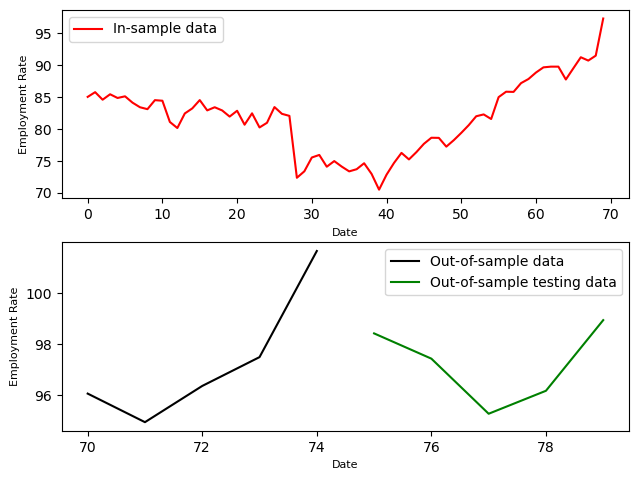

In [80]:
#%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

#Split data in three datasets 
unTSTrain = unTS[0:70]
unTSTrain.name = "In-sample data"

unTSVal = unTS[70:75]
unTSVal.name = "Out-of-sample data"

#unTSTrain=unTS['1948':'2016']
#unTSTrain.name="In-sample data"
#unTSVal=unTS['2017':'2017']
#unTSVal.name="Out-of-sample validation data"
unTSTst=unTS[75:80]
unTSTst.name="Out-of-sample testing data"


fig, axs=plt.subplots(2)
fig.tight_layout()
unTSTrain.plot(ax=axs[0],legend=True,color='r')
unTSVal.plot(ax=axs[1],legend=True,color='k')
unTSTst.plot(ax=axs[1],legend=True,color='g')
axs[0].set_ylabel('Employment Rate',fontdict={'fontsize':8})
axs[0].set_xlabel('Date',fontdict={'fontsize':8})
axs[1].set_ylabel('Employment Rate',fontdict={'fontsize':8})
axs[1].set_xlabel('Date',fontdict={'fontsize':8})

    Fazer grid search again, tendo em conta o RMSE

In [81]:
rp=range(0,4)
rq=range(0,4)
rP=range(0,4)
rQ=range(0,4)

rmseV=np.zeros((len(rp),len(rq),len(rP),len(rQ)))
i=0
for p in rp:
    j=0
    for q in rq:
        k=0
        for P in rP:
            l=0
            for Q in rQ:
                model=ARIMA(unTSTrain, order=(p, 1, q), seasonal_order=(P, 1, Q, 12))
                fit = model.fit()
                forecast=fit.forecast(12)
                armse=np.sqrt(np.sum((unTSVal-forecast)**2)/forecast.size)
                rmseV[i][j][k][l]=armse
                print("Evaluating p="+str(p)+" q="+str(q)+" P="+str(P)+" Q="+str(Q)+" RMSE="+str(armse))
                l=l+1
            k=k+1
        j=j+1
    i=i+1
                
ixs=np.where(rmseV==np.min(rmseV))

Evaluating p=0 q=0 P=0 Q=0 RMSE=2.1290021136972115
Evaluating p=0 q=0 P=0 Q=1 RMSE=1.3598777107940478


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=0 P=0 Q=2 RMSE=1.3765935438067516


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=0 P=0 Q=3 RMSE=1.3596450936244873
Evaluating p=0 q=0 P=1 Q=0 RMSE=1.6576500650862283
Evaluating p=0 q=0 P=1 Q=1 RMSE=1.3708929689835117


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=0 P=1 Q=2 RMSE=1.3409093639062442


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=0 P=1 Q=3 RMSE=1.3489537952006612
Evaluating p=0 q=0 P=2 Q=0 RMSE=1.428146206315173
Evaluating p=0 q=0 P=2 Q=1 RMSE=1.3802219963828177


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=0 P=2 Q=2 RMSE=1.362085402146043


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=0 P=2 Q=3 RMSE=1.3465014457189044
Evaluating p=0 q=0 P=3 Q=0 RMSE=1.4498488273518533
Evaluating p=0 q=0 P=3 Q=1 RMSE=1.3630866385059814


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=0 P=3 Q=2 RMSE=1.3826479133884053


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=0 P=3 Q=3 RMSE=1.3962955641877932
Evaluating p=0 q=1 P=0 Q=0 RMSE=1.7282262898799352
Evaluating p=0 q=1 P=0 Q=1 RMSE=1.3704426952239561


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=1 P=0 Q=2 RMSE=1.3867489596973708


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=1 P=0 Q=3 RMSE=1.3786117888282903
Evaluating p=0 q=1 P=1 Q=0 RMSE=1.573817519542038
Evaluating p=0 q=1 P=1 Q=1 RMSE=1.3818630705307593


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=1 P=1 Q=2 RMSE=1.3411195520159795


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=1 P=1 Q=3 RMSE=1.3564568581838274
Evaluating p=0 q=1 P=2 Q=0 RMSE=1.4374433308420604
Evaluating p=0 q=1 P=2 Q=1 RMSE=1.380209918221137


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=1 P=2 Q=2 RMSE=1.360701148822105


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=1 P=2 Q=3 RMSE=1.3408026153150425
Evaluating p=0 q=1 P=3 Q=0 RMSE=1.4533168513213086
Evaluating p=0 q=1 P=3 Q=1 RMSE=1.3625036140185445


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=1 P=3 Q=2 RMSE=1.379428208755906


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=1 P=3 Q=3 RMSE=1.3931616951354056
Evaluating p=0 q=2 P=0 Q=0 RMSE=1.432918793938428
Evaluating p=0 q=2 P=0 Q=1 RMSE=1.4369889991242528


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=2 P=0 Q=2 RMSE=1.4508162826701787


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=2 P=0 Q=3 RMSE=1.345375645031592
Evaluating p=0 q=2 P=1 Q=0 RMSE=1.33083830576097
Evaluating p=0 q=2 P=1 Q=1 RMSE=1.4473173280690506


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=2 P=1 Q=2 RMSE=1.4442092669054085


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=2 P=1 Q=3 RMSE=1.3642209970040278
Evaluating p=0 q=2 P=2 Q=0 RMSE=1.4475716489163963
Evaluating p=0 q=2 P=2 Q=1 RMSE=1.4546428413667838


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=2 P=2 Q=2 RMSE=1.4594716158776817


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=2 P=2 Q=3 RMSE=1.4708867680078348
Evaluating p=0 q=2 P=3 Q=0 RMSE=1.4863117751427737


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=2 P=3 Q=1 RMSE=1.458458164822444


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=2 P=3 Q=2 RMSE=1.4956672764412389


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=2 P=3 Q=3 RMSE=1.5466264867263129
Evaluating p=0 q=3 P=0 Q=0 RMSE=1.6575220293277337
Evaluating p=0 q=3 P=0 Q=1 RMSE=1.4747361467994684


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=3 P=0 Q=2 RMSE=1.4826542896974106


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=3 P=0 Q=3 RMSE=1.423830115610458
Evaluating p=0 q=3 P=1 Q=0 RMSE=1.3995044427640875
Evaluating p=0 q=3 P=1 Q=1 RMSE=1.4813311362693657


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=3 P=1 Q=2 RMSE=1.4991059107637725


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=3 P=1 Q=3 RMSE=1.4541016647325349
Evaluating p=0 q=3 P=2 Q=0 RMSE=1.5322197290342876
Evaluating p=0 q=3 P=2 Q=1 RMSE=1.4875687789132797


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=3 P=2 Q=2 RMSE=1.4813571750808774


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=3 P=2 Q=3 RMSE=1.4778398312624679
Evaluating p=0 q=3 P=3 Q=0 RMSE=1.5658614976185192


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=0 q=3 P=3 Q=1 RMSE=1.48028511193235


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=3 P=3 Q=2 RMSE=1.5082229857159648


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=0 q=3 P=3 Q=3 RMSE=1.5396619698252476
Evaluating p=1 q=0 P=0 Q=0 RMSE=1.9065312096796394
Evaluating p=1 q=0 P=0 Q=1 RMSE=1.3670288501250307


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=0 P=0 Q=2 RMSE=1.383270738033721


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=0 P=0 Q=3 RMSE=1.3743570234609415
Evaluating p=1 q=0 P=1 Q=0 RMSE=1.6096921684856333
Evaluating p=1 q=0 P=1 Q=1 RMSE=1.3776766951393198


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=0 P=1 Q=2 RMSE=1.3410485288729728


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=0 P=1 Q=3 RMSE=1.3546729156481854
Evaluating p=1 q=0 P=2 Q=0 RMSE=1.4353096066131936
Evaluating p=1 q=0 P=2 Q=1 RMSE=1.3802085258876562


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=0 P=2 Q=2 RMSE=1.3610397926699713


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=0 P=2 Q=3 RMSE=1.3414823511895426
Evaluating p=1 q=0 P=3 Q=0 RMSE=1.4523637140821561


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=0 P=3 Q=1 RMSE=1.3627412268220123


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=0 P=3 Q=2 RMSE=1.3805281994366998


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=0 P=3 Q=3 RMSE=1.3941099863948692
Evaluating p=1 q=1 P=0 Q=0 RMSE=1.5440911509463535


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as s

Evaluating p=1 q=1 P=0 Q=1 RMSE=1.3619210471050316


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=1 P=0 Q=2 RMSE=1.371180185942602


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=1 P=0 Q=3 RMSE=1.3911959592923875
Evaluating p=1 q=1 P=1 Q=0 RMSE=1.3749798284211496


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as s

Evaluating p=1 q=1 P=1 Q=1 RMSE=1.3676454184852689


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=1 P=1 Q=2 RMSE=1.3338741603373934


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=1 q=1 P=1 Q=3 RMSE=1.383477413785554


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Evaluating p=1 q=1 P=2 Q=0 RMSE=1.4226567307786355


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Evaluating p=1 q=1 P=2 Q=1 RMSE=1.415919988599844


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=1 q=1 P=2 Q=2 RMSE=1.3798375305629227


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=1 q=1 P=2 Q=3 RMSE=1.369785184532844


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Evaluating p=1 q=1 P=3 Q=0 RMSE=1.4541544640116755


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=1 P=3 Q=1 RMSE=1.3803108276196032


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=1 q=1 P=3 Q=2 RMSE=1.3918146497540835


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Evaluating p=1 q=1 P=3 Q=3 RMSE=1.405621861786011
Evaluating p=1 q=2 P=0 Q=0 RMSE=1.498581005644171
Evaluating p=1 q=2 P=0 Q=1 RMSE=1.446795708998961


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=2 P=0 Q=2 RMSE=1.4591908379170941


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=2 P=0 Q=3 RMSE=1.3567776086532133
Evaluating p=1 q=2 P=1 Q=0 RMSE=1.3595528268936374
Evaluating p=1 q=2 P=1 Q=1 RMSE=1.4559365285472123


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=2 P=1 Q=2 RMSE=1.4554682582630316


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=2 P=1 Q=3 RMSE=1.3750014497643468
Evaluating p=1 q=2 P=2 Q=0 RMSE=1.459641997449372


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=2 P=2 Q=1 RMSE=1.4562309918988565


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=2 P=2 Q=2 RMSE=1.4624414657843503


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=2 P=2 Q=3 RMSE=1.4771374880986576
Evaluating p=1 q=2 P=3 Q=0 RMSE=1.498468847001253


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=2 P=3 Q=1 RMSE=1.4613426662495523


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=2 P=3 Q=2 RMSE=1.4984429410902267


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=2 P=3 Q=3 RMSE=1.5458504818759375
Evaluating p=1 q=3 P=0 Q=0 RMSE=1.6651965157775048
Evaluating p=1 q=3 P=0 Q=1 RMSE=1.4850205747144682


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=3 P=0 Q=2 RMSE=1.4908909349292496


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=3 P=0 Q=3 RMSE=1.4314673411471042
Evaluating p=1 q=3 P=1 Q=0 RMSE=1.402098729033027
Evaluating p=1 q=3 P=1 Q=1 RMSE=1.4898364933150634


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=3 P=1 Q=2 RMSE=1.5148903292104574


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=3 P=1 Q=3 RMSE=1.452418668760849
Evaluating p=1 q=3 P=2 Q=0 RMSE=1.5358965933201452
Evaluating p=1 q=3 P=2 Q=1 RMSE=1.5003679020077267


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=3 P=2 Q=2 RMSE=1.4879205391906658


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=3 P=2 Q=3 RMSE=1.4875783973321643
Evaluating p=1 q=3 P=3 Q=0 RMSE=1.563510013144849


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=3 P=3 Q=1 RMSE=1.4873841526909055


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=1 q=3 P=3 Q=2 RMSE=1.5100067517266094


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=1 q=3 P=3 Q=3 RMSE=1.531386855678325
Evaluating p=2 q=0 P=0 Q=0 RMSE=1.5017356657071779
Evaluating p=2 q=0 P=0 Q=1 RMSE=1.4370070761776144


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=0 P=0 Q=2 RMSE=1.4530334603467618


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=0 P=0 Q=3 RMSE=1.3402503956319767
Evaluating p=2 q=0 P=1 Q=0 RMSE=1.3346386627743358
Evaluating p=2 q=0 P=1 Q=1 RMSE=1.449433304712139


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=0 P=1 Q=2 RMSE=1.4404479954971727


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=0 P=1 Q=3 RMSE=1.359681385099421
Evaluating p=2 q=0 P=2 Q=0 RMSE=1.44473719217962
Evaluating p=2 q=0 P=2 Q=1 RMSE=1.4539046108031939


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=0 P=2 Q=2 RMSE=1.4584202845277618


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=0 P=2 Q=3 RMSE=1.4867193927448075
Evaluating p=2 q=0 P=3 Q=0 RMSE=1.4743764692646528


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=0 P=3 Q=1 RMSE=1.457429319114223


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=0 P=3 Q=2 RMSE=1.4969159268981547


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=0 P=3 Q=3 RMSE=1.560226925356642
Evaluating p=2 q=1 P=0 Q=0 RMSE=1.778099680017199
Evaluating p=2 q=1 P=0 Q=1 RMSE=1.485846018942809


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=1 P=0 Q=2 RMSE=1.490357836701607


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=1 P=0 Q=3 RMSE=1.5840525158605334
Evaluating p=2 q=1 P=1 Q=0 RMSE=1.706811484769367
Evaluating p=2 q=1 P=1 Q=1 RMSE=1.4919067785726199


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=1 P=1 Q=2 RMSE=1.376056175757825


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=1 P=1 Q=3 RMSE=1.4179470039103632
Evaluating p=2 q=1 P=2 Q=0 RMSE=1.569303724592568
Evaluating p=2 q=1 P=2 Q=1 RMSE=1.4741806386978806


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=1 P=2 Q=2 RMSE=1.304558360909587


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=1 P=2 Q=3 RMSE=1.0818257648503888
Evaluating p=2 q=1 P=3 Q=0 RMSE=1.5605015547748384
Evaluating p=2 q=1 P=3 Q=1 RMSE=1.3725776030378478


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=1 P=3 Q=2 RMSE=1.1741128105156555


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=1 P=3 Q=3 RMSE=1.0391713619857328
Evaluating p=2 q=2 P=0 Q=0 RMSE=1.5267350589409012


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=2 P=0 Q=1 RMSE=1.1980288885154986


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=2 P=0 Q=2 RMSE=1.2507765570618876


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=2 P=0 Q=3 RMSE=1.0633679648837937


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=2 P=1 Q=0 RMSE=0.9810910498103684


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=2 P=1 Q=1 RMSE=1.2407435495910162


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=2 P=1 Q=2 RMSE=1.2404464667196156


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=2 P=1 Q=3 RMSE=1.259947651000894


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=2 P=2 Q=0 RMSE=1.3628788681513992


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=2 P=2 Q=1 RMSE=1.4808349224897075


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=2 P=2 Q=2 RMSE=1.4918952892033572


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=2 P=2 Q=3 RMSE=1.4238098099817662


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=2 P=3 Q=0 RMSE=1.4379009679875827


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=2 P=3 Q=1 RMSE=1.4898708169507189


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=2 P=3 Q=2 RMSE=1.4737107995392265


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=2 P=3 Q=3 RMSE=1.4530592580303794
Evaluating p=2 q=3 P=0 Q=0 RMSE=1.7583600005173536


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=3 P=0 Q=1 RMSE=1.464882514768313


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=3 P=0 Q=2 RMSE=1.4517743055456767


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=3 P=0 Q=3 RMSE=1.3289515079760947


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=3 P=1 Q=0 RMSE=1.4370047348400623


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=2 q=3 P=1 Q=1 RMSE=1.4546448126665703


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=3 P=1 Q=2 RMSE=1.4840123590434051


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=3 P=1 Q=3 RMSE=1.3535363408201622


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=3 P=2 Q=0 RMSE=1.442835186323895


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=3 P=2 Q=1 RMSE=1.478115437363981


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=3 P=2 Q=2 RMSE=1.4790042071345226


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=3 P=2 Q=3 RMSE=1.3637753061040156


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=3 P=3 Q=0 RMSE=1.4609588846493045


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=3 P=3 Q=1 RMSE=1.479033728120079


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=3 P=3 Q=2 RMSE=1.4956025867574947


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=2 q=3 P=3 Q=3 RMSE=1.5748997268758889
Evaluating p=3 q=0 P=0 Q=0 RMSE=1.5035054713035034
Evaluating p=3 q=0 P=0 Q=1 RMSE=1.5278239182394737


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=3 q=0 P=0 Q=2 RMSE=1.533307487930572


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=3 q=0 P=0 Q=3 RMSE=1.398480304997062
Evaluating p=3 q=0 P=1 Q=0 RMSE=1.345691151623942
Evaluating p=3 q=0 P=1 Q=1 RMSE=1.531840181524171


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=3 q=0 P=1 Q=2 RMSE=1.5710885858258237


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=0 P=1 Q=3 RMSE=1.4313339912807383
Evaluating p=3 q=0 P=2 Q=0 RMSE=1.5613258717427614
Evaluating p=3 q=0 P=2 Q=1 RMSE=1.552051937759029


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=3 q=0 P=2 Q=2 RMSE=1.5534008177357415


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=3 q=0 P=2 Q=3 RMSE=1.5572986252479926
Evaluating p=3 q=0 P=3 Q=0 RMSE=1.5986790550548484


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=0 P=3 Q=1 RMSE=1.5527288197670253


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=3 q=0 P=3 Q=2 RMSE=1.5624205587496098


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=0 P=3 Q=3 RMSE=1.5713972452641034
Evaluating p=3 q=1 P=0 Q=0 RMSE=1.517131732062976
Evaluating p=3 q=1 P=0 Q=1 RMSE=1.5155402445241986


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=3 q=1 P=0 Q=2 RMSE=1.5206052330532254


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=3 q=1 P=0 Q=3 RMSE=1.3838709756654097
Evaluating p=3 q=1 P=1 Q=0 RMSE=1.345467118609798
Evaluating p=3 q=1 P=1 Q=1 RMSE=1.519638485191712


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=1 P=1 Q=2 RMSE=1.5513701616575677


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=1 P=1 Q=3 RMSE=1.4148908787261694
Evaluating p=3 q=1 P=2 Q=0 RMSE=1.5420318119879042
Evaluating p=3 q=1 P=2 Q=1 RMSE=1.5363728814222601


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=1 P=2 Q=2 RMSE=1.5392035409113987


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=1 P=2 Q=3 RMSE=1.5462666385533026
Evaluating p=3 q=1 P=3 Q=0 RMSE=1.5735788839035276


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=1 P=3 Q=1 RMSE=1.5378589899319437


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=1 P=3 Q=2 RMSE=1.5487516837424646


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=1 P=3 Q=3 RMSE=1.5520439957710697
Evaluating p=3 q=2 P=0 Q=0 RMSE=1.532996734408909


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=3 q=2 P=0 Q=1 RMSE=1.4533619087471494


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=2 P=0 Q=2 RMSE=1.1728006165819778


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=2 P=0 Q=3 RMSE=1.3449770398539729


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=2 P=1 Q=0 RMSE=1.0183800705824304


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=3 q=2 P=1 Q=1 RMSE=1.121831773932523


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=2 P=1 Q=2 RMSE=1.454016010813594


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=2 P=1 Q=3 RMSE=1.2694198546310913


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=2 P=2 Q=0 RMSE=1.2651183310431457


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=2 P=2 Q=1 RMSE=1.4379894533630706


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=2 P=2 Q=2 RMSE=1.4169915135045754


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=2 P=2 Q=3 RMSE=1.3985144625000365


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=2 P=3 Q=0 RMSE=1.4100989136452338


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=2 P=3 Q=1 RMSE=1.446432662930199


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=2 P=3 Q=2 RMSE=1.440161965021123


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=2 P=3 Q=3 RMSE=1.4640944197997778
Evaluating p=3 q=3 P=0 Q=0 RMSE=1.7570768199068825


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=3 q=3 P=0 Q=1 RMSE=1.1497042752285291


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=3 P=0 Q=2 RMSE=1.1972731189265882


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=3 P=0 Q=3 RMSE=1.0339131838355624


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=3 P=1 Q=0 RMSE=1.0695468308830467


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluating p=3 q=3 P=1 Q=1 RMSE=1.1864698337750081


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=3 P=1 Q=2 RMSE=1.1824205717408265


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=3 P=1 Q=3 RMSE=1.2996932292671528


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=3 P=2 Q=0 RMSE=1.3208892150855793


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=3 P=2 Q=1 RMSE=1.5478672114060072


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=3 P=2 Q=2 RMSE=1.5458250910558766


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=3 P=2 Q=3 RMSE=1.4654782464117238


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=3 P=3 Q=0 RMSE=1.4668483455244208


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=3 P=3 Q=1 RMSE=1.5548079194109892


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=3 P=3 Q=2 RMSE=1.5435096308563208


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating p=3 q=3 P=3 Q=3 RMSE=1.588830373666062


In [82]:
print("====================================================================================================")
print("Best: p="+str(rp[ixs[0][0]])+", q="+str(rp[ixs[1][0]])+", P="+str(rP[ixs[2][0]])+", Q="+str(rQ[ixs[3][0]])+" Validation RMSE="+str(rmseV[ixs[0][0]][ixs[1][0]][ixs[2][0]][ixs[3][0]]))


Best: p=2, q=2, P=1, Q=0 Validation RMSE=0.9810910498103684


Fitted model AIC=288.56664969152047
Forecast Testing RMSE=3.150923499638794


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


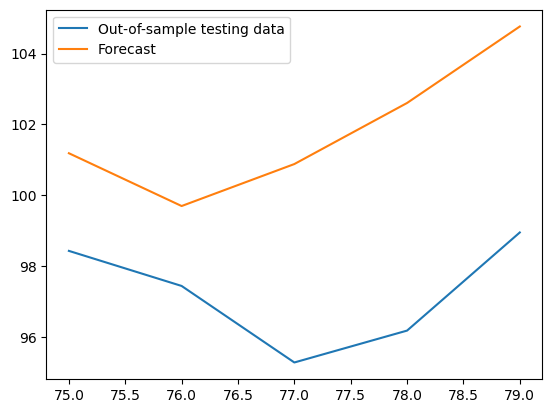

In [83]:
unTSTrainVal=unTS[0:75]
model=ARIMA(unTSTrainVal, order=(rp[ixs[0][0]], 1, rp[ixs[1][0]]), seasonal_order=(rp[ixs[2][0]], 1, rp[ixs[3][0]], 12))
fit = model.fit()
res=fit.resid[1:]
print("Fitted model AIC="+str(fit.aic))


plt.figure()
unTSTst.plot(legend=True)
pforecast=fit.forecast(5)
pforecast.name="Forecast"
pforecast.plot(legend=True)

print("Forecast Testing RMSE="+str(np.sqrt(np.sum((unTSTst-pforecast)**2)/forecast.size)))

In [84]:
"""
#Defina a SARIMA structure     p d  q                   P  D. Q.  S
#model=ARIMA(unTSTrain, order=(3, 1, 2), seasonal_order=(2,0,1,15))
model=ARIMA(unTSTrain, order=(3, 1, 5), seasonal_order=(2, 1, 2, 40))
#Fit model
fit = model.fit()

vals = fit.forecast(len(unTSVal))
plt.figure()
plt.plot(vals.values)
plt.plot(unTSVal.values)

# Plot TS
plt.figure(figsize=(10, 6))  # Adjust the size as needed

unTSTrain.plot(legend=True, color='r', label='In-sample data')
vals.plot(legend=True, color='k', label='Out-of-sample data')
unTSVal.plot(legend=True, color='b', label='valiade data')
plt.ylabel('Employment Rate', fontdict={'fontsize': 8})
plt.xlabel('Date', fontdict={'fontsize': 8})
# Format x-axis labels as day/month/year
date_format = mdates.DateFormatter("%d/%m/%Y")
plt.gca().xaxis.set_major_formatter(date_format)
"""


'\n#Defina a SARIMA structure     p d  q                   P  D. Q.  S\n#model=ARIMA(unTSTrain, order=(3, 1, 2), seasonal_order=(2,0,1,15))\nmodel=ARIMA(unTSTrain, order=(3, 1, 5), seasonal_order=(2, 1, 2, 40))\n#Fit model\nfit = model.fit()\n\nvals = fit.forecast(len(unTSVal))\nplt.figure()\nplt.plot(vals.values)\nplt.plot(unTSVal.values)\n\n# Plot TS\nplt.figure(figsize=(10, 6))  # Adjust the size as needed\n\nunTSTrain.plot(legend=True, color=\'r\', label=\'In-sample data\')\nvals.plot(legend=True, color=\'k\', label=\'Out-of-sample data\')\nunTSVal.plot(legend=True, color=\'b\', label=\'valiade data\')\nplt.ylabel(\'Employment Rate\', fontdict={\'fontsize\': 8})\nplt.xlabel(\'Date\', fontdict={\'fontsize\': 8})\n# Format x-axis labels as day/month/year\ndate_format = mdates.DateFormatter("%d/%m/%Y")\nplt.gca().xaxis.set_major_formatter(date_format)\n'

In [85]:
"""
unTSTrain = unTS[0:70]
unTSTrain.name = "In-sample data"

#Defina a SARIMA structure     p d  q                   P  D. Q.  S
#model=ARIMA(unTSTrain, order=(3, 1, 2), seasonal_order=(2,0,1,15))
model=ARIMA(unTSTrain, order=(0, 1, 0), seasonal_order=(0, 1, 1, 13))
#Fit model
fit = model.fit()

vals_test = fit.forecast(len(unTSTst))
plt.figure()
plt.plot(vals_test.values)
plt.plot(unTSVal.values)

# Plot TS
plt.figure(figsize=(10, 6))  # Adjust the size as needed

unTSTrain.plot(legend=True, color='r', label='In-sample data')
unTSVal.plot(legend=True, color='b', label='valiade data')
unTSTst.plot(legend=True, color='orange', label='test data real')
vals_test.plot(legend=True, color='g', label='test data predicted')
plt.ylabel('Employment Rate', fontdict={'fontsize': 8})
plt.xlabel('Date', fontdict={'fontsize': 8})
# Format x-axis labels as day/month/year
date_format = mdates.DateFormatter("%d/%m/%Y")
plt.gca().xaxis.set_major_formatter(date_format)
"""

'\nunTSTrain = unTS[0:70]\nunTSTrain.name = "In-sample data"\n\n#Defina a SARIMA structure     p d  q                   P  D. Q.  S\n#model=ARIMA(unTSTrain, order=(3, 1, 2), seasonal_order=(2,0,1,15))\nmodel=ARIMA(unTSTrain, order=(0, 1, 0), seasonal_order=(0, 1, 1, 13))\n#Fit model\nfit = model.fit()\n\nvals_test = fit.forecast(len(unTSTst))\nplt.figure()\nplt.plot(vals_test.values)\nplt.plot(unTSVal.values)\n\n# Plot TS\nplt.figure(figsize=(10, 6))  # Adjust the size as needed\n\nunTSTrain.plot(legend=True, color=\'r\', label=\'In-sample data\')\nunTSVal.plot(legend=True, color=\'b\', label=\'valiade data\')\nunTSTst.plot(legend=True, color=\'orange\', label=\'test data real\')\nvals_test.plot(legend=True, color=\'g\', label=\'test data predicted\')\nplt.ylabel(\'Employment Rate\', fontdict={\'fontsize\': 8})\nplt.xlabel(\'Date\', fontdict={\'fontsize\': 8})\n# Format x-axis labels as day/month/year\ndate_format = mdates.DateFormatter("%d/%m/%Y")\nplt.gca().xaxis.set_major_formatter(

    Valdiação do modelo

In [86]:
"""# Calculate MAE
mae_arima = mean_absolute_error(actual_values, arima_predictions)
mae_sarima = mean_absolute_error(actual_values, sarima_predictions)

# Calculate RMSE
rmse_arima = np.sqrt(mean_squared_error(actual_values, arima_predictions))
rmse_sarima = np.sqrt(mean_squared_error(actual_values, sarima_predictions))

# Print the results
print(f"ARIMA MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f}")
print(f"SARIMA MAE: {mae_sarima:.2f}, RMSE: {rmse_sarima:.2f}")

# Calculate MAPE
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

mape_arima = calculate_mape(actual_values, arima_predictions)
mape_sarima = calculate_mape(actual_values, sarima_predictions)

print(f"ARIMA MAPE: {mape_arima:.2f}%")
print(f"SARIMA MAPE: {mape_sarima:.2f}%")
"""

import statistics
import numpy as np

unTS = merged_data["Close_edp"]

list_RMSE = []
list_MAFE = []
list_U2 = []
model=ARIMA(unTSTrainVal, order=(rp[ixs[0][0]], 1, rp[ixs[1][0]]), seasonal_order=(rp[ixs[2][0]], 1, rp[ixs[3][0]], 12))
fit = model.fit()

for i in range(0, len(unTS)-75):
    
    unTSTrain=unTS[0+i:70+i]
    unTSTrain.name="In-sample data"

    unTSVal=unTS[70+i:75+i]
    unTSVal.name="Out-of-sample data"
    
    fit = fit.apply(unTSTrain)
    res=fit.resid[1:]
    #print("Fitted model AIC="+str(fit.aic))

    forecast=fit.forecast(5)

    RMSE = np.sqrt(np.sum((unTSVal-forecast)**2)/forecast.size)
    print("Forecast RMSE="+str(RMSE))

    MAFE = np.mean(np.abs((unTSVal - forecast) / unTSVal))
    print("Forecast MAFE="+str(MAFE))

    U2 = np.sqrt(np.sum((unTSVal - forecast)**2) / np.sum((unTSVal - np.mean(unTSVal))**2))
    print("Forecast U2="+str(U2))

    list_RMSE.append(RMSE)
    list_MAFE.append(MAFE)
    list_U2.append(U2)

print("Em média o RMSE deste modelo é: ",statistics.mean(list_RMSE))
print("Em média o MAFE deste modelo é: ",statistics.mean(list_MAFE))
print("Em média o U2 deste modelo é: ",statistics.mean(list_U2))



/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast RMSE=0.2183431334312801
Forecast MAFE=0.04623288134657868
Forecast U2=2.0976464707385496
Forecast RMSE=0.1633062742380492
Forecast MAFE=0.033624664095910486
Forecast U2=1.627105425434669
Forecast RMSE=0.14424954327502876
Forecast MAFE=0.02854457520911457
Forecast U2=2.0396376600128914
Forecast RMSE=0.1387592669561669
Forecast MAFE=0.030031099153615813
Forecast U2=2.282792985491185
Forecast RMSE=0.16062954495604365
Forecast MAFE=0.03360666184236184
Forecast U2=1.9809985416136187
Forecast RMSE=0.23397890119909773
Forecast MAFE=0.05238768977739838
Forecast U2=1.982832171363663
Forecast RMSE=0.1335276612962805
Forecast MAFE=0.026665557622114706
Forecast U2=0.9485316997680903
Forecast RMSE=0.1549397982579835
Forecast MAFE=0.03753526094549084
Forecast U2=1.125699721497379
Forecast RMSE=0.24862063452396804
Forecast MAFE=0.05991555137762662
Forecast U2=3.082754153446787
Forecast RMSE=0.19193175826568382
Forecast MAFE=0.04411661478382049
Forecast U2=1.3145196844871618
Forecast RMSE=0.2

## ES

<Axes: xlabel='Years', ylabel='Crude (Millions of tunnels)'>

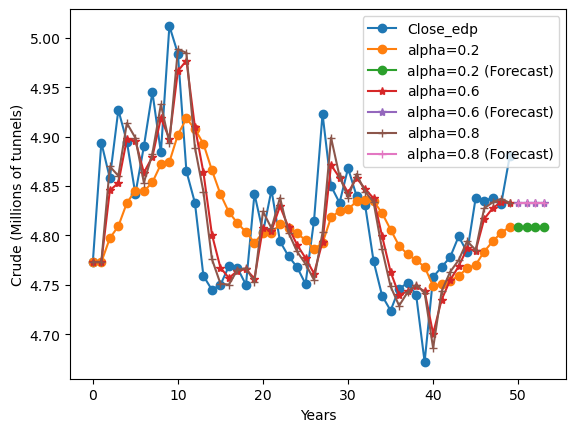

In [87]:
#%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def mySES(data,alpha,end ,NstepAh=0):
    N=end
    s=np.zeros(N+NstepAh)
    s[0]=data[0]
    
    for k in range(1,N):
        s[k]=alpha*data[k-1]+(1-alpha)*s[k-1]
    
    if NstepAh>0:
        for k in range(N,N+NstepAh):
            s[k]=s[N-1]
    
    #yend=0+N+NstepAh
    #print("oi")
    #index= pd.date_range(start='1996', end=str(yend), freq='A')
    #print(len(s))
    #print(len(data[0:len(s)].index.values.tolist()))
    return pd.Series(s, data[0:len(s)].index.values.tolist())
    
        

#Credits to https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html#Loading-data on 12/05/2021
#data = edp["Close"].values.tolist() #[446.6565,  454.4733,  455.663 ,  423.6322,  456.2713,  440.5881, 425.3325,  485.1494,  506.0482,  526.792 ,  514.2689,  494.211 ]
#index= pd.date_range(start='19/10/2021', end='18/10/2023', freq='d')
#oildata = pd.Series(data, index,name="Meas. Data")
#unData=pd.read_csv("EDP.csv",sep=",",header=0,parse_dates=["Date"])
#oildata=pd.Series(data=np.array(unData["Close"]),index=unData["Date"],name="edp close prices")

# unTS[0:50]
plt.figure()
merged_data["Close_edp"][0:50].plot(marker='o',legend=True)
plt.xlabel('Years')
plt.ylabel('Crude (Millions of tunnels)')

sse02=mySES(merged_data["Close_edp"],0.2,50,NstepAh=4)
sse02.name="alpha=0.2"
#print(sse02)
sse02[0:50].plot(marker='o',legend=True)
sse02.name="alpha=0.2 (Forecast)"
sse02[50:].plot(marker='o',legend=True)

sse06=mySES(merged_data["Close_edp"],0.6,50,NstepAh=4)
sse06.name="alpha=0.6"
sse06[0:50].plot(marker='*',legend=True)
sse06.name="alpha=0.6 (Forecast)"
sse06[50:].plot(marker='*',legend=True)


sse08=mySES(merged_data["Close_edp"],0.8,50,NstepAh=4)
sse08.name="alpha=0.8"
sse08[0:50].plot(marker='+',legend=True)
sse08.name="alpha=0.8 (Forecast)"
sse08[50:].plot(marker='+',legend=True)


### DES

<Axes: xlabel='Years', ylabel='air Pollution'>

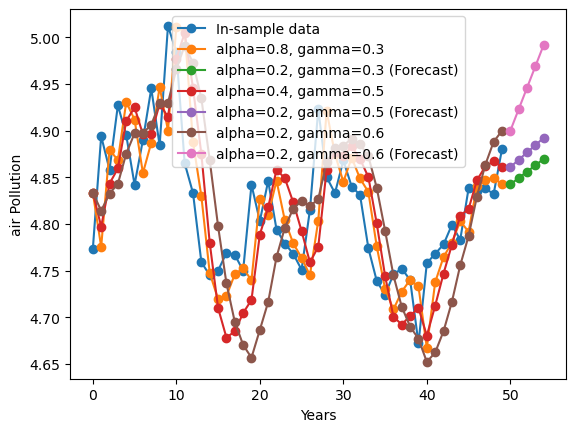

In [88]:
#%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def myDES(data,globaldata,alpha,gamma,NstepAh=0):
    N=data.size
    L=np.zeros(N+NstepAh)
    T=np.zeros(N+NstepAh)
    s=np.zeros(N+NstepAh)
    L[0]=(data[0]+data[1])/2
    T[0]=0#data[1]-data[0]
    s[0]=(data[0]+data[1])/2
    
    for n in range(1,N):
        L[n]=alpha*data[n-1]+(1-alpha)*(L[n-1]+T[n-1])
        T[n]=gamma*(L[n]-L[n-1])+(1-gamma)*T[n-1]
        s[n]=L[n]+T[n]
    
    if NstepAh>0:
        h=1
        for n in range(N,N+NstepAh):
           # L[n]=L[n-1]+T[n-1]
           # T[n]=gamma*(L[n]-L[n-1])+(1-gamma)*T[n-1]
            s[n]=L[N-1]+h*T[N-1]
            h=h+1

    
    #index= pd.date_range(start='1990', end=str(yend), freq='A')
    return pd.Series(s, globaldata[0:len(s)].index.values.tolist())
    
        

#Credits to https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html#Loading-data on 12/05/2021
#data = [17.5534,  21.86  ,  23.8866,  26.9293,  26.8885,  28.8314, 30.0751,  30.9535,  30.1857,  31.5797,  32.5776,  33.4774, 39.0216,  41.3864,  41.5966]
#index= pd.date_range(start='1990', end='2005', freq='A')
#air = pd.Series(data, index,name="Air Polution (measured)")
psTSTrain = merged_data["Close_edp"][0:50]
psTSTrain.name="In-sample data"

plt.figure()
psTSTrain.plot(marker='o',legend=True)
plt.xlabel('Years')
plt.ylabel('air Pollution')

dse08_02=myDES(psTSTrain, merged_data["Close_edp"],0.8,0.2,NstepAh=5)
dse08_02.name="alpha=0.8, gamma=0.3"
dse08_02[0:50].plot(marker='o',legend=True)
dse08_02.name="alpha=0.2, gamma=0.3 (Forecast)"
dse08_02[50:].plot(marker='o',legend=True)


dse04_05=myDES(psTSTrain, merged_data["Close_edp"],0.4,0.5,NstepAh=5)
dse04_05.name="alpha=0.4, gamma=0.5"
dse04_05[0:50].plot(marker='o',legend=True)
dse04_05.name="alpha=0.2, gamma=0.5 (Forecast)"
dse04_05[50:].plot(marker='o',legend=True)

dse02_06=myDES(psTSTrain, merged_data["Close_edp"],0.2,0.6,NstepAh=5)
dse02_06.name="alpha=0.2, gamma=0.6"
dse02_06[0:50].plot(marker='o',legend=True)
dse02_06.name="alpha=0.2, gamma=0.6 (Forecast)"
dse02_06[50:].plot(marker='o',legend=True)



### TES

Forecast RMSE=0.23524698766357752


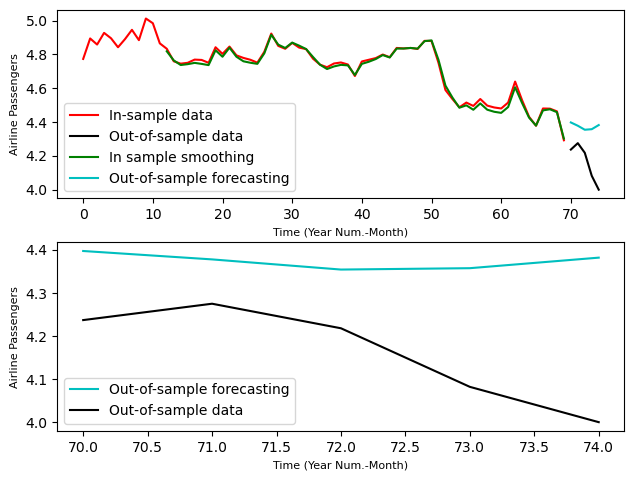

In [89]:
#%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def myTES(serie,alpha,gamma,delta,S,end,global_series,mtype='a',NstepAh=0):
    N=end#serie.size
    L=np.zeros(N+NstepAh)
    T=np.zeros(N+NstepAh)
    I=np.zeros(N+NstepAh)
    s=np.zeros(N+NstepAh)
    #Initialize parameters
    L[S-1]=np.mean(serie[0:S])
    
    bsum=0
    for i in range(S):
        bsum=bsum+(serie[S+i]-serie[i])/S
        if mtype=='m':#If multiplicative
            I[i]=serie[i]/L[S-1]
        else:
            I[i]=serie[i]-L[S-1]
            
    T[S-1]=(1/S)*bsum
    
    s[S-1]=L[S-1]
    
    for n in range(S,N):
        if mtype=='m':
            L[n]=alpha*(serie[n]/I[n-S])+(1-alpha)*(L[n-1]+T[n-1])
        else:
            L[n]=alpha*(serie[n]-I[n-S])+(1-alpha)*(L[n-1]+T[n-1])
            
        T[n]=gamma*(L[n]-L[n-1])+(1-gamma)*T[n-1]
        
        if mtype=='m':
            I[n]=delta*(serie[n]/L[n])+(1-delta)*I[n-S]
            s[n]=(L[n]+T[n])*I[n]
        else:
            I[n]=delta*(serie[n]-L[n])+(1-delta)*I[n-S]
            s[n]=L[n]+T[n]+I[n]
    
    if NstepAh>0:
        h=1
        for n in range(N,N+NstepAh):
            if mtype=='m':
                s[n]=(L[N-1]+h*T[N-1])*I[N-S+np.mod(h-1,S)]
            else:
                s[n]=L[N-1]+h*T[N-1]+I[N-S+np.mod(h-1,S)]
            h=h+1
    
    

    #oindex=serie.index
    
    #index=oindex.union(pd.date_range(oindex[-1] + oindex.freq, periods=NstepAh, freq=oindex.freq))
    
    #print(len(s))
    #print(len(serie))
    return pd.Series(s, global_series[0:len(s)].index.values.tolist())
    
    #Initialize parameters
    


#psData=pd.read_csv("../data/academicTS/airline-passengers.csv",sep=",",header=0,parse_dates=["Year-Month"])
#index= pd.date_range(start='1949-01-01', end='1960-12-31', freq='M')
#index=psData["Year-Month"]
#psTS=pd.Series(data=np.array(psData["Passengers"]),index=index,name="Airline Passengers")

psTSTrain = merged_data["Close_edp"][0:70]
psTSTrain.name="In-sample data"

psTSVal = merged_data["Close_edp"][70:75]
psTSVal.name="Out-of-sample data"

fig, axs=plt.subplots(2)
fig.tight_layout()
psTSTrain.plot(ax=axs[0],legend=True,color='r')
psTSVal.plot(ax=axs[0],legend=True,color='k')
axs[0].set_ylabel('Airline Passengers',fontdict={'fontsize':8})
axs[0].set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})


Nstep=5 #Nstep-ahead in months
tes=myTES(psTSTrain,0.4,0.1,0.8,12,70,merged_data["Close_edp"],mtype='a',NstepAh=Nstep)
insamp=tes[12:-Nstep]
outsamp=tes[-Nstep:]
insamp.name="In sample smoothing"
outsamp.name="Out-of-sample forecasting"


insamp.plot(ax=axs[0],legend=True,color='g')
outsamp.plot(ax=axs[0],legend=True,color='c')
#psTSVal.plot(ax=axs[1],legend=True,color='k')

axs[0].set_ylabel('Airline Passengers',fontdict={'fontsize':8})
axs[0].set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})

outsamp.plot(ax=axs[1],legend=True,color='c')
psTSVal.plot(ax=axs[1],legend=True,color='k')

axs[1].set_ylabel('Airline Passengers',fontdict={'fontsize':8})
axs[1].set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})

print("Forecast RMSE="+str(np.sqrt(np.sum((psTSVal-outsamp)**2)/outsamp.size)))


In [90]:
step=0.1
alphas=np.arange(step,1-step,step)
gammas=np.arange(step,1-step,step)
deltas=np.arange(step,1-step,step)

for_perf=np.zeros((alphas.size,gammas.size,deltas.size))
i=0
for alpha in alphas:
    j=0
    for gamma in gammas:
        k=0
        for delta in deltas:
            tes=myTES(psTSTrain,alpha,gamma,delta,12,70,merged_data["Close_edp"],mtype='a',NstepAh=Nstep)
            outsamp=tes[-Nstep:]
            for_perf[i][j][k]=np.sqrt(np.sum((psTSVal-outsamp)**2)/outsamp.size)
            print("Evaluating ("+str(alpha)+","+str(gamma)+","+str(delta)+") RMSE="+str(for_perf[i][j][k]))
            k=k+1
        j=j+1
    i=i+1
    
    


Evaluating (0.1,0.1,0.1) RMSE=0.21608506984565656
Evaluating (0.1,0.1,0.2) RMSE=0.22870661663898484
Evaluating (0.1,0.1,0.30000000000000004) RMSE=0.24260990466907964
Evaluating (0.1,0.1,0.4) RMSE=0.2564728659839875
Evaluating (0.1,0.1,0.5) RMSE=0.2697570903648094
Evaluating (0.1,0.1,0.6) RMSE=0.28235526995969795
Evaluating (0.1,0.1,0.7000000000000001) RMSE=0.29440283034252107
Evaluating (0.1,0.1,0.8) RMSE=0.3061759281311125
Evaluating (0.1,0.2,0.1) RMSE=0.15788000760001752
Evaluating (0.1,0.2,0.2) RMSE=0.1784799218999191
Evaluating (0.1,0.2,0.30000000000000004) RMSE=0.20151328151758274
Evaluating (0.1,0.2,0.4) RMSE=0.2246063730602837
Evaluating (0.1,0.2,0.5) RMSE=0.24698622152961977
Evaluating (0.1,0.2,0.6) RMSE=0.2686719750907678
Evaluating (0.1,0.2,0.7000000000000001) RMSE=0.2901062296894131
Evaluating (0.1,0.2,0.8) RMSE=0.3119863693421932
Evaluating (0.1,0.30000000000000004,0.1) RMSE=0.16204774048322707
Evaluating (0.1,0.30000000000000004,0.2) RMSE=0.18858720332279935
Evaluating (0.

In [91]:
ix=np.where(for_perf==np.min(for_perf))
print("Best Parameters: Alpha="+str(alphas[ix[0]])+" Gamma="+str(gammas[ix[1]])+" Delta="+str(alphas[ix[2]]))


Best Parameters: Alpha=[0.6] Gamma=[0.8] Delta=[0.8]


Forecast RMSE=0.034873191430238565


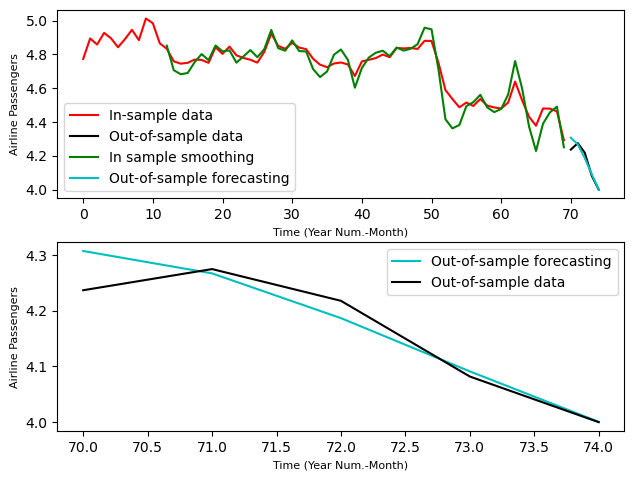

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def myTES(serie,alpha,gamma,delta,S,end,mtype='a',NstepAh=0):
    N=end
    L=np.zeros(N+NstepAh)
    T=np.zeros(N+NstepAh)
    I=np.zeros(N+NstepAh)
    s=np.zeros(N+NstepAh)
    #Initialize parameters
    L[S-1]=np.mean(serie[0:S])
    
    bsum=0
    for i in range(S):
        bsum=bsum+(serie[S+i]-serie[i])/S
        if mtype=='m':#If multiplicative
            I[i]=serie[i]/L[S-1]
        else:
            I[i]=serie[i]-L[S-1]
            
    T[S-1]=(1/S)*bsum
    
    s[S-1]=L[S-1]
    
    for n in range(S,N):
        if mtype=='m':
            L[n]=alpha*(serie[n]/I[n-S])+(1-alpha)*(L[n-1]+T[n-1])
        else:
            L[n]=alpha*(serie[n]-I[n-S])+(1-alpha)*(L[n-1]+T[n-1])
            
        T[n]=gamma*(L[n]-L[n-1])+(1-gamma)*T[n-1]
        
        if mtype=='m':
            I[n]=delta*(serie[n]/L[n])+(1-delta)*I[n-S]
            s[n]=(L[n]+T[n])*I[n]
        else:
            I[n]=delta*(serie[n]-L[n])+(1-delta)*I[n-S]
            s[n]=L[n]+T[n]+I[n]
    
    if NstepAh>0:
        h=1
        for n in range(N,N+NstepAh):
            if mtype=='m':
                s[n]=(L[N-1]+h*T[N-1])*I[N-S+np.mod(h-1,S)]
            else:
                s[n]=L[N-1]+h*T[N-1]+I[N-S+np.mod(h-1,S)]
            h=h+1
    
    return pd.Series(s)

psTSTrain = merged_data["Close_edp"][0:70]
psTSTrain.name="In-sample data"

psTSVal = merged_data["Close_edp"][70:75]
psTSVal.name="Out-of-sample data"

fig, axs=plt.subplots(2)
fig.tight_layout()
psTSTrain.plot(ax=axs[0],legend=True,color='r')
psTSVal.plot(ax=axs[0],legend=True,color='k')
axs[0].set_ylabel('Airline Passengers',fontdict={'fontsize':8})
axs[0].set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})


Nstep=5 #Nstep-ahead in months
tes=myTES(psTSTrain,0.6,0.8,0.8,12,70,mtype='a',NstepAh=Nstep)
insamp=tes[12:-Nstep]
outsamp=tes[-Nstep:]
insamp.name="In sample smoothing"
outsamp.name="Out-of-sample forecasting"


insamp.plot(ax=axs[0],legend=True,color='g')
outsamp.plot(ax=axs[0],legend=True,color='c')

axs[0].set_ylabel('Airline Passengers',fontdict={'fontsize':8})
axs[0].set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})

outsamp.plot(ax=axs[1],legend=True,color='c')
psTSVal.plot(ax=axs[1],legend=True,color='k')

axs[1].set_ylabel('Airline Passengers',fontdict={'fontsize':8})
axs[1].set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})

print("Forecast RMSE="+str(np.sqrt(np.sum((psTSVal-outsamp)**2)/outsamp.size)))


    Valdiação do TES

In [93]:
len(unTS)

438

In [94]:
import statistics
import numpy as np

unTS = merged_data["Close_edp"]

list_RMSE = []
list_MAFE = []
list_U2 = []

for i in range(0, len(unTS) - 75, 5):
    psTSTrain = merged_data["Close_edp"][0+i:70+i].reset_index(drop=True)
    original_index = merged_data["Close_edp"][70+i:75+i].index
    psTSVal = merged_data["Close_edp"][70+i:75+i].reset_index(drop=True)
    
    Nstep=5 #Nstep-ahead in months
    tes=myTES(psTSTrain,0.6,0.8,0.8,12,70,mtype='a',NstepAh=Nstep)
    insamp=tes[12:-Nstep]
    outsamp=tes[-Nstep:]

    # Reassign the original index to outsamp and psTSVal
    if len(outsamp) == len(original_index):
        outsamp.index = original_index
        psTSVal.index = original_index
    else:
        print(f"Length mismatch: outsamp has {len(outsamp)} elements, original_index has {len(original_index)} elements")

    RMSE = np.sqrt(np.sum((psTSVal-outsamp)**2)/outsamp.size)
    print("Forecast RMSE="+str(RMSE))

    MAFE = np.mean(np.abs((psTSVal - outsamp) / psTSVal))
    print("Forecast MAFE="+str(MAFE))

    U2 = np.sqrt(np.sum((psTSVal - outsamp)**2) / np.sum((psTSVal - np.mean(psTSVal))**2))
    print("Forecast U2="+str(U2))

    list_RMSE.append(RMSE)
    list_MAFE.append(MAFE)
    list_U2.append(U2)

print("Em média o RMSE deste modelo é: ",statistics.mean(list_RMSE))
print("Em média o MAFE deste modelo é: ",statistics.mean(list_MAFE))
print("Em média o U2 deste modelo é: ",statistics.mean(list_U2))


Forecast RMSE=0.034873191430238565
Forecast MAFE=0.00564391732029159
Forecast U2=0.3350305813489346
Forecast RMSE=0.27527198724824986
Forecast MAFE=0.060951964828947505
Forecast U2=2.3327665417429637
Forecast RMSE=0.8639152584582716
Forecast MAFE=0.18029342403179488
Forecast U2=5.497691260859573
Forecast RMSE=0.22333715376936672
Forecast MAFE=0.03880421057587222
Forecast U2=4.973620366552505
Forecast RMSE=0.1594676515147171
Forecast MAFE=0.028034792498655765
Forecast U2=4.194426262590246
Forecast RMSE=0.19297074633052883
Forecast MAFE=0.03533274959077789
Forecast U2=3.3415361348192976
Forecast RMSE=0.16140205923271206
Forecast MAFE=0.031625856970098176
Forecast U2=15.845067360002558
Forecast RMSE=0.5926244410827862
Forecast MAFE=0.105915736309974
Forecast U2=18.667396978758905
Forecast RMSE=0.42172722512685473
Forecast MAFE=0.08952859558083717
Forecast U2=4.390325006212895
Forecast RMSE=0.8688276755701685
Forecast MAFE=0.1600750174869759
Forecast U2=15.882681370492705
Forecast RMSE=0.4

## Multivariate time-series analysis & forecasting

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.48557D+00    |proj g|=  3.31922D+00

At iterate    5    f= -1.49576D+00    |proj g|=  1.49467D-01

At iterate   10    f= -1.49641D+00    |proj g|=  8.46036D-01

At iterate   15    f= -1.49860D+00    |proj g|=  1.36469D-01

At iterate   20    f= -1.49863D+00    |proj g|=  4.85391D-02

At iterate   25    f= -1.49868D+00    |proj g|=  3.58204D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     34      1     0     0   

 This problem is unconstrained.


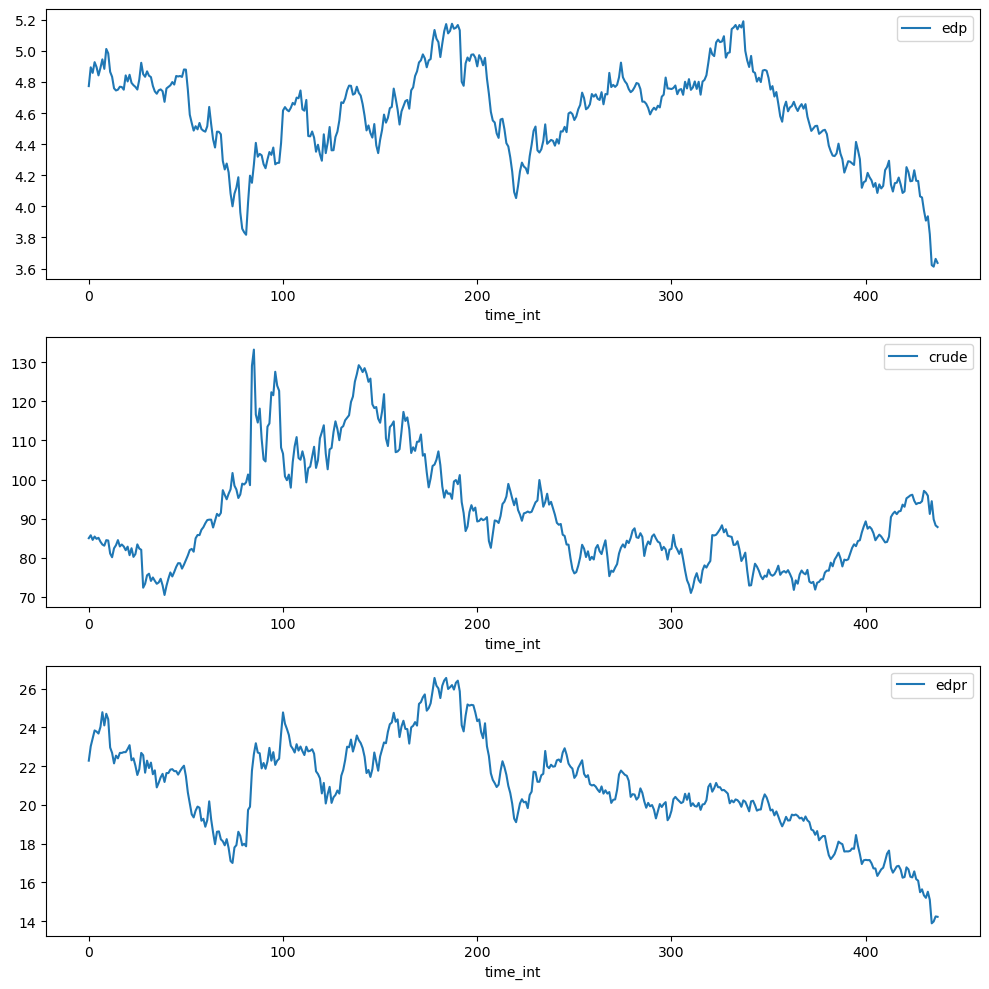

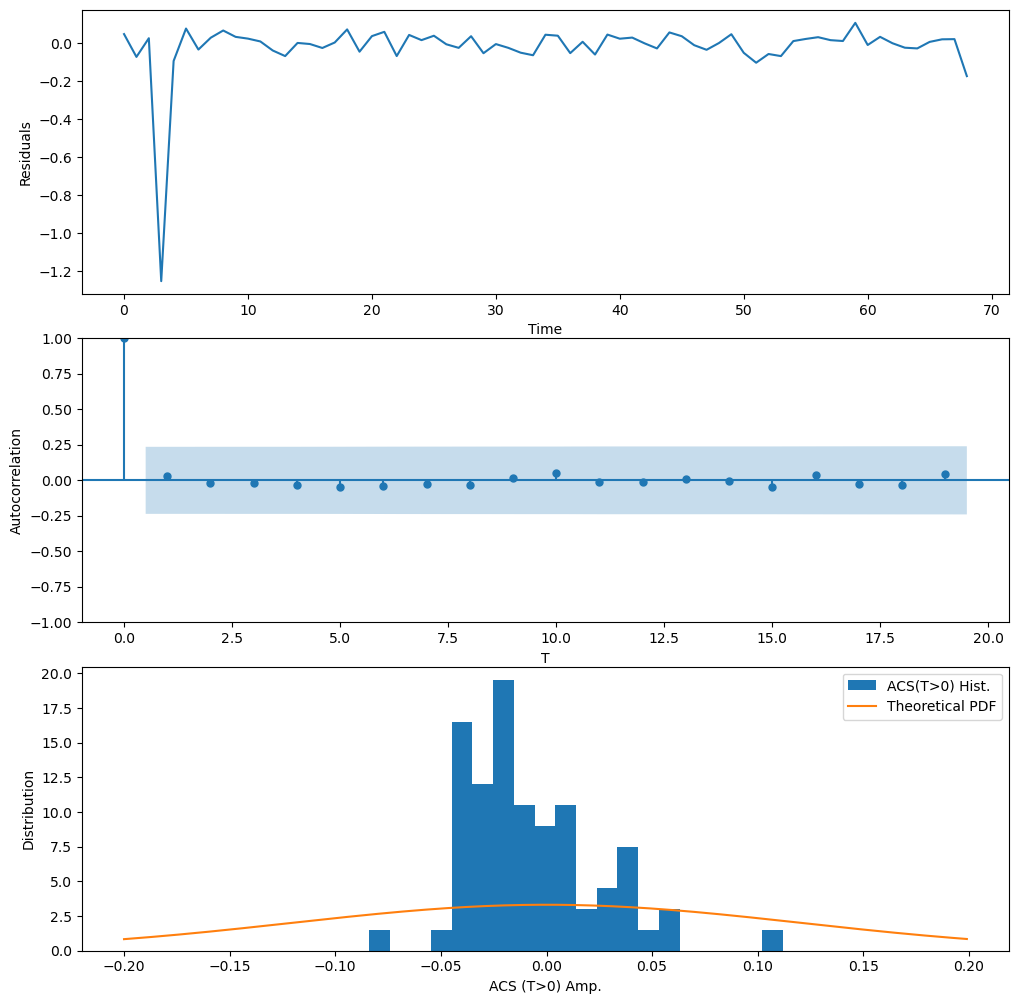

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.stattools import acf
import scipy.stats as spyst

"""
usEconData=pd.read_excel("/Users/cesarteixeira/Documents/aulas/TimeSeries/2022_2023/data/EconDataUS.xls",sheet_name="Sheet1",
                    usecols=["Time", "COE", "CPIAUCSL", "FEDFUNDS", "GDP","UNRATE"],parse_dates=["Time"])


unrateTS=pd.Series(data=np.array(usEconData['UNRATE']),index=usEconData['Time'],name='Unemployment Rate')
coeTS=pd.Series(data=np.array(usEconData['COE']),index=usEconData['Time'],name='Paid compensation of employees')
cpiTS=pd.Series(data=np.array(usEconData['CPIAUCSL']),index=usEconData['Time'],name='Consumer Price Index')
fedfundsTS=pd.Series(data=np.array(usEconData['FEDFUNDS']),index=usEconData['Time'],name='Effective federal funds rate')
gdpTS=pd.Series(data=np.array(usEconData['GDP']),index=usEconData['Time'],name='Gross domestic product')
"""
# Read unemployment rate data from CSV file


# Create a Pandas Series object
unTS_edp = pd.Series(data=np.array(merged_data["Close_edp"]), index=merged_data["time_int"], name="edp")
unTS_crude = pd.Series(data=np.array(merged_data["Close_crude"]), index=merged_data["time_int"], name="crude")
unTS_edpr = pd.Series(data=np.array(merged_data["Close_edpr"]), index=merged_data["time_int"], name="edpr")

#Plot data
fig, axs=plt.subplots(3,tight_layout=True,figsize=(10,10))
unTS_edp.plot(ax=axs[0],legend=True)

unTS_crude.plot(ax=axs[1],legend=True)

unTS_edpr.plot(ax=axs[2],legend=True)


#Split training & test data
unTSTrain = unTS[0:70]
unTSTrain.name = "In-sample data"

unTSVal = unTS[69:75]
unTSVal.name = "Out-of-sample data"
"""
startTrain='1960'
stopTrain='2006'

startTest='2007'
stopTest='2008'
"""

trainTarget=np.array(unTS_edp[0:70].to_numpy())
trainInputs=np.array([unTS_crude[0:70],unTS_edpr[0:70]]).transpose()


testTarget=np.array(unTS_edp[69:75].to_numpy())
testInputs=np.array([unTS_crude[69:75].to_numpy(),unTS_edpr[69:75].to_numpy()]).transpose()

#Fit SARIMAX model
model = SARIMAX(endog=trainTarget,exog=trainInputs,order=(1, 1, 0), 
                seasonal_order=(1, 1, 0, 4)).fit()

print(model.param_names)
print(model.params)

#Get residuals
res=pd.Series(model.resid[1:])
#Get fitting performance (AIC)
print("Fitted model AIC="+str(model.aic))

#Evaluate fitting quality by inspecting residuals at three levels: 
#Time plot, ACS and ACS distribution
fig, axs=plt.subplots(3,figsize=(10,10))
fig.tight_layout()
res.plot(ax=axs[0])
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Residuals')
plot_acf(res,ax=axs[1],title="")
axs[1].set_xlabel("T")
axs[1].set_ylabel("Autocorrelation")

ac=acf(res,nlags=500,fft=False)

axs[2].hist(ac[1:],bins=20,density=True,label='ACS(T>0) Hist.')

N=res.size
rg=np.arange(-0.2,0.2,0.001)
pdf = spyst.norm.pdf(rg,0,1/np.sqrt(N))
plt.plot(rg,pdf,label='Theoretical PDF')
plt.xlabel("ACS (T>0) Amp.")
plt.ylabel("Distribution")
plt.legend()

RMSE=0.03750058821864702


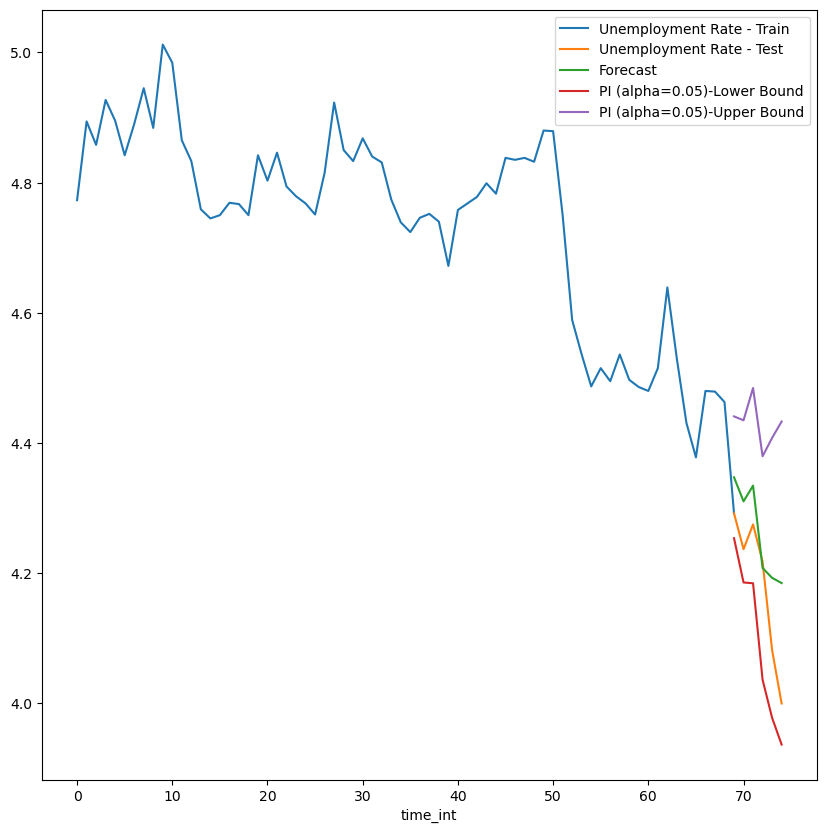

In [96]:
#Perform forecast

fest = model.get_forecast(len (testTarget), exog=testInputs)
festTS=pd.Series(data=fest.predicted_mean,index=unTS_edp[69:75].index,
                 name='Forecast')
festTSLB=pd.Series(data=fest.conf_int()[:,0],index=unTS_edp[69:75].index,
                   name='PI (alpha=0.05)-Lower Bound')
festTSUB=pd.Series(data=fest.conf_int()[:,1],index=unTS_edp[69:75].index,
                   name='PI (alpha=0.05)-Upper Bound')

plt.figure(figsize=(10,10))
unTS_edp.name='Unemployment Rate - Train'
ax=unTS_edp[0:70].plot(legend=True)
unTS_edp.name='Unemployment Rate - Test'
ax=unTS_edp[69:75].plot(ax=ax,legend=True)
festTS.plot(ax=ax,legend=True)
festTSLB.plot(ax=ax,legend=True)
festTSUB.plot(ax=ax,legend=True)

print('RMSE='+str((np.sum((unTS_edp[69:75]-festTS))**2)
                  /unTS_edp[69:75].size))

    Valdiação de Sarimax

In [97]:
import statistics
import numpy as np

unTS_edp = merged_data["Close_edp"]
unTS_crude = merged_data["Close_crude"]
unTS_edpr = merged_data["Close_edpr"]

# Fit SARIMAX model
model = SARIMAX(endog=np.array(unTS_edp[:70].to_numpy()), 
                exog=np.array([unTS_crude[:70], unTS_edpr[:70]]).transpose(), 
                order=(1, 1, 0), 
                seasonal_order=(1, 1, 0, 4)).fit()

list_RMSE = []
list_MAFE = []
list_U2 = []

for i in range(0, len(unTS_edp) - 75):
    # Perform forecast
    testTarget = np.array(unTS_edp[70+i:75+i].to_numpy())
    testInputs = np.array([unTS_crude[70+i:75+i].to_numpy(), unTS_edpr[70+i:75+i].to_numpy()]).transpose()

    fest = model.get_forecast(len(testTarget), exog=testInputs)
    festTS = pd.Series(data=fest.predicted_mean, index=unTS_edp[70+i:75+i].index, name='Forecast')

    RMSE = np.sqrt(np.sum((unTS_edp[70+i:75+i] - festTS)**2) / unTS_edp[70+i:75+i].size)
    print('RMSE=' + str(RMSE))

    MAFE = np.mean(np.abs((unTS_edp[70+i:75+i] - festTS) / unTS_edp[70+i:75+i]))
    print('MAFE=' + str(MAFE))

    U2 = np.sqrt(np.sum((unTS_edp[70+i:75+i] - festTS)**2) / np.sum((unTS_edp[70+i:75+i] - np.mean(unTS_edp[70+i:75+i]))**2))
    print('U2=' + str(U2))

    list_RMSE.append(RMSE)
    list_MAFE.append(MAFE)
    list_U2.append(U2)

print("Em média o RMSE deste modelo é: ", statistics.mean(list_RMSE))
print("Em média o MAFE deste modelo é: ", statistics.mean(list_MAFE))
print("Em média o U2 deste modelo é: ", statistics.mean(list_U2))


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.48557D+00    |proj g|=  3.31922D+00

At iterate    5    f= -1.49576D+00    |proj g|=  1.49467D-01

At iterate   10    f= -1.49641D+00    |proj g|=  8.46036D-01

At iterate   15    f= -1.49860D+00    |proj g|=  1.36469D-01

At iterate   20    f= -1.49863D+00    |proj g|=  4.85391D-02
RMSE=0.1084981031400807
MAFE=0.023521208353631175
U2=1.042353196810047
RMSE=0.1336322909413818
MAFE=0.030989057289682893
U2=1.3314480819459293
RMSE=0.15981555623881827
MAFE=0.03757976967190383
U2=2.2597355926396916

At iterate   25    f= -1.49868D+00    |proj g|=  3.58204D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final ge

 This problem is unconstrained.


RMSE=0.28771833349188164
MAFE=0.06223124112677697
U2=7.598313185662435
RMSE=0.2830440828994958
MAFE=0.06030282814311848
U2=3.7592601757934645
RMSE=0.27615625929168697
MAFE=0.05748471391537026
U2=4.362402281741771
RMSE=0.27460088683279416
MAFE=0.057446676594886815
U2=5.412244631245164
RMSE=0.2758740171320754
MAFE=0.058952399831863934
U2=3.588825432942028
RMSE=0.27614657874952814
MAFE=0.059196622072781625
U2=3.5238604704828362
RMSE=0.2935947482081566
MAFE=0.06300726290112091
U2=5.398056831551571
RMSE=0.29617875837873403
MAFE=0.06304896779369065
U2=5.895064835583452
RMSE=0.2834758986373295
MAFE=0.05906448860684368
U2=4.936178033704311
RMSE=0.2590071452006476
MAFE=0.05339240566137966
U2=9.151338998972836
RMSE=0.23217159436290524
MAFE=0.04657200892167991
U2=5.678893029071927
RMSE=0.1977574288053996
MAFE=0.03928478832496156
U2=3.9855547784273555
RMSE=0.1737705203313601
MAFE=0.03298190988265635
U2=2.4265839354305507
RMSE=0.1476684371759186
MAFE=0.025230150841213956
U2=1.7652780531216121
RMSE=

## Fitting and forecasting with VAR and VARMA

438 438 438


<Axes: xlabel='Date'>

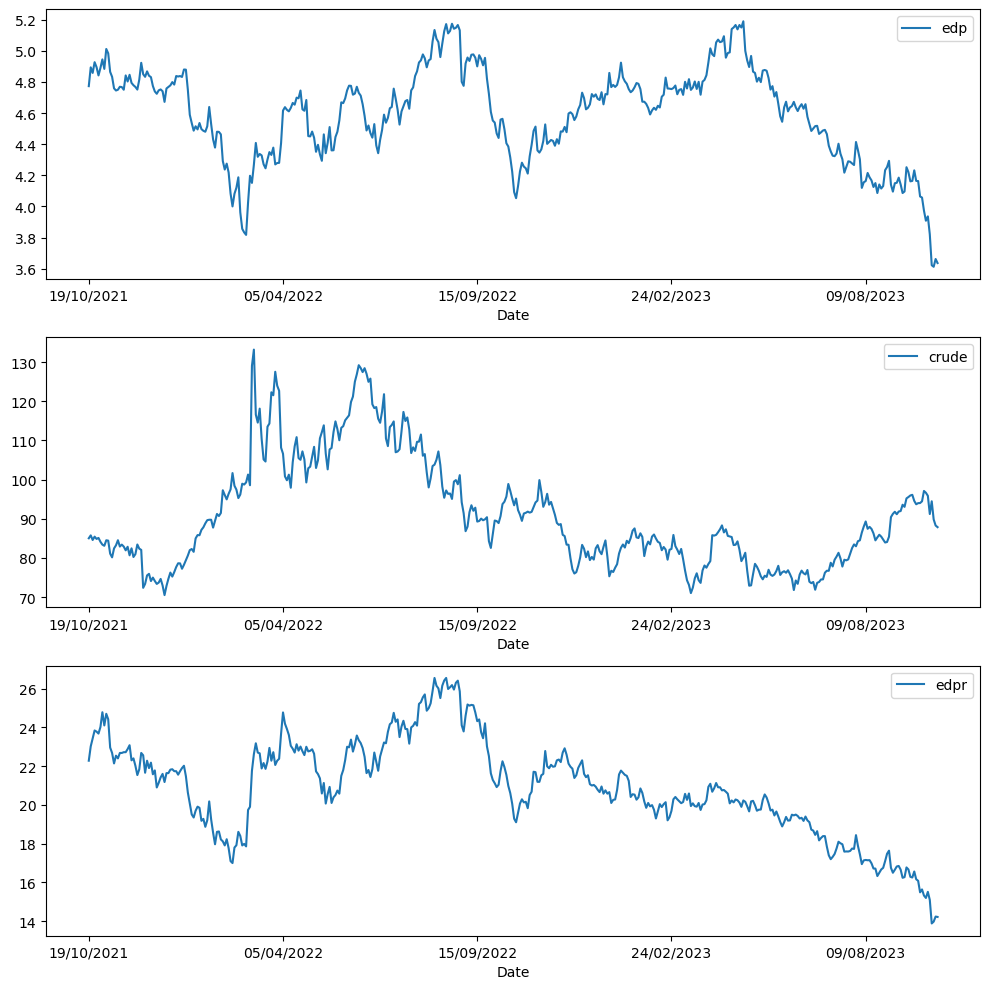

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.stattools import acf
import scipy.stats as spyst

unData_edp = new_df1#pd.read_csv("EDP.csv", sep=",", header=0, parse_dates=["Date"])
#unData_edp = unData_edp[0:509]

unData_crude = new_df2#pd.read_csv("new_crude.csv", sep=",", header=0, parse_dates=["Date"])
#unData_crude = unData_crude[401:831]

unData_edpr = new_df3#pd.read_csv("EDPr.csv", sep=";", header=0, parse_dates=["Date"])
#unData_edpr = unData_edpr[0:509]


# Create a Pandas Series object
unTS_edp = pd.Series(data=np.array(merged_data["Close_edp"]), index=merged_data["Date"], name="edp")
unTS_crude = pd.Series(data=np.array(merged_data["Close_crude"]), index=merged_data["Date"], name="crude")
unTS_edpr = pd.Series(data=np.array(merged_data["Close_edpr"]), index=merged_data["Date"], name="edpr")

print(len(unTS_edp), len(unTS_crude), len(unTS_edpr))
#Plot original data
fig, axs=plt.subplots(3,tight_layout=True,figsize=(10,10))
unTS_edp.plot(ax=axs[0],legend=True)
unTS_crude.plot(ax=axs[1],legend=True)
unTS_edpr.plot(ax=axs[2],legend=True)



437 437 437


<Axes: xlabel='Date'>

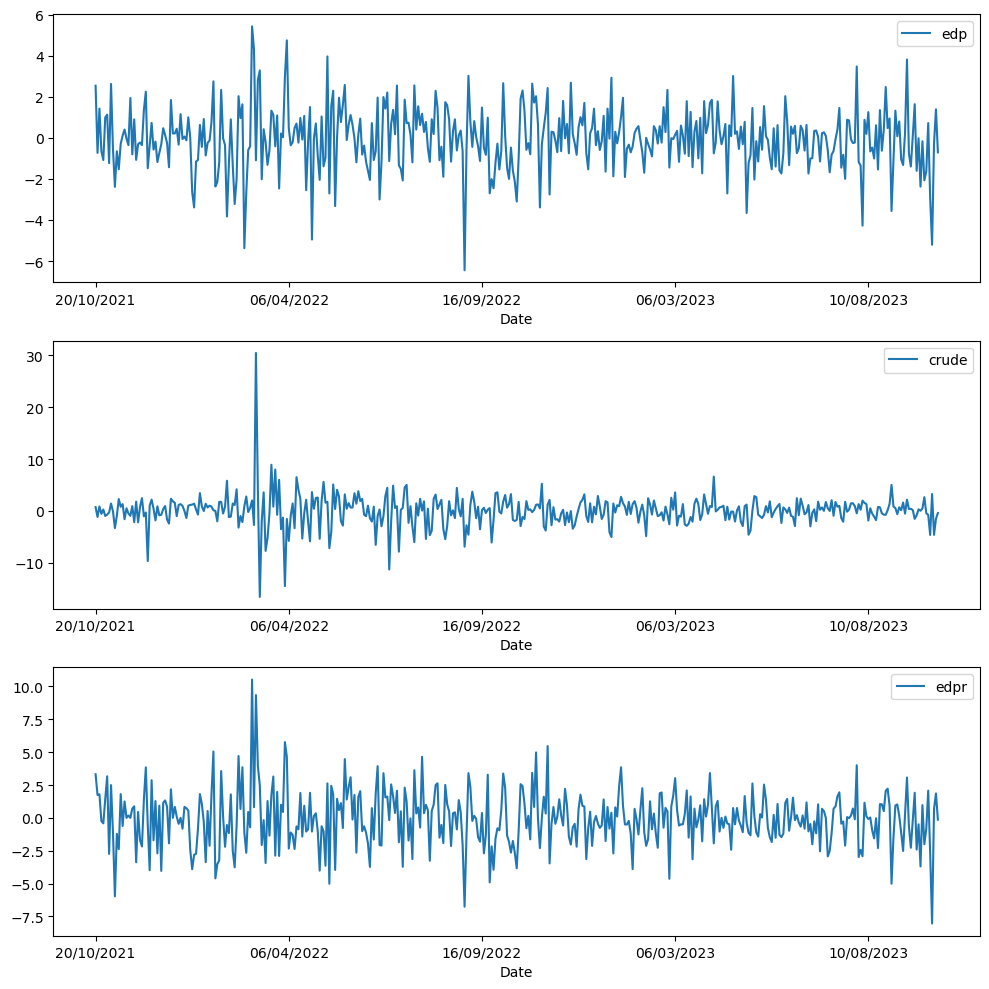

In [99]:
gdpC=np.zeros(unTS_edp.size-1)
for i in range(1,unTS_edp.size):
    gdpC[i-1]=(((unTS_edp.iloc[i]-unTS_edp.iloc[i-1])/unTS_edp.iloc[i-1]))*100
gdpCTS=pd.Series(data=gdpC,index=unTS_edp.index[1:],name='edp')

unrC=np.zeros(unTS_crude.size-1)
for i in range(1,unTS_crude.size):
    unrC[i-1]=(unTS_crude.iloc[i]-unTS_crude.iloc[i-1])
unrCTS=pd.Series(data=unrC,index=unTS_crude.index[1:],name='crude')

cpiC=np.zeros(unTS_edpr.size-1)
for i in range(1,unTS_edpr.size):
    cpiC[i-1]=(((unTS_edpr.iloc[i]-unTS_edpr.iloc[i-1])/unTS_edpr.iloc[i-1]))*100
cpiCTS=pd.Series(data=cpiC,index=unTS_edpr.index[1:],name='edpr')
(
print(len(gdpCTS),len(unrCTS), len(cpiCTS)))
X=[]
X.append(gdpCTS)
X.append(unrCTS)
X.append(cpiCTS)

#Plot transformed data
fig, axs=plt.subplots(3,tight_layout=True,figsize=(10,10))
unrCTS.plot(ax=axs[1],legend=True)
cpiCTS.plot(ax=axs[2],legend=True)
gdpCTS.plot(ax=axs[0],legend=True)

In [100]:
X

[Date
 20/10/2021    2.535093
 21/10/2021   -0.735595
 22/10/2021    1.420338
 25/10/2021   -0.649482
 26/10/2021   -1.082737
                 ...   
 02/10/2023   -2.921748
 03/10/2023   -5.208061
 04/10/2023   -0.276091
 05/10/2023    1.384275
 06/10/2023   -0.709995
 Name: edp, Length: 437, dtype: float64,
 Date
 20/10/2021    0.74
 21/10/2021   -1.18
 22/10/2021    0.85
 25/10/2021   -0.58
 26/10/2021    0.26
               ... 
 02/10/2023   -4.65
 03/10/2023    3.25
 04/10/2023   -4.63
 05/10/2023   -1.55
 06/10/2023   -0.42
 Name: crude, Length: 437, dtype: float64,
 Date
 20/10/2021    3.321364
 21/10/2021    1.737619
 22/10/2021    1.793339
 25/10/2021   -0.251678
 26/10/2021   -0.420521
                 ...   
 02/10/2023   -2.674831
 03/10/2023   -8.046358
 04/10/2023    0.684192
 05/10/2023    1.859800
 06/10/2023   -0.140449
 Name: edpr, Length: 437, dtype: float64]

nTS 3
i
here
here4
here5
here6
here7
0 437
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266

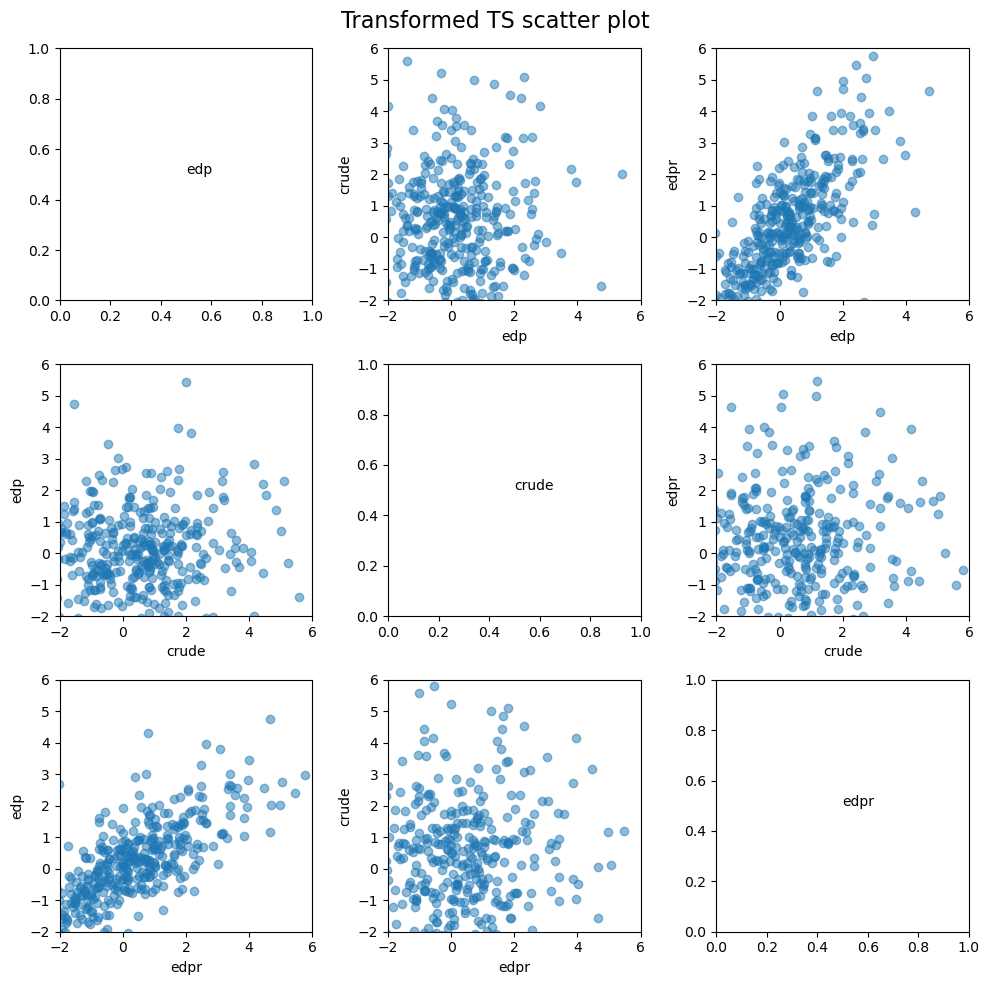

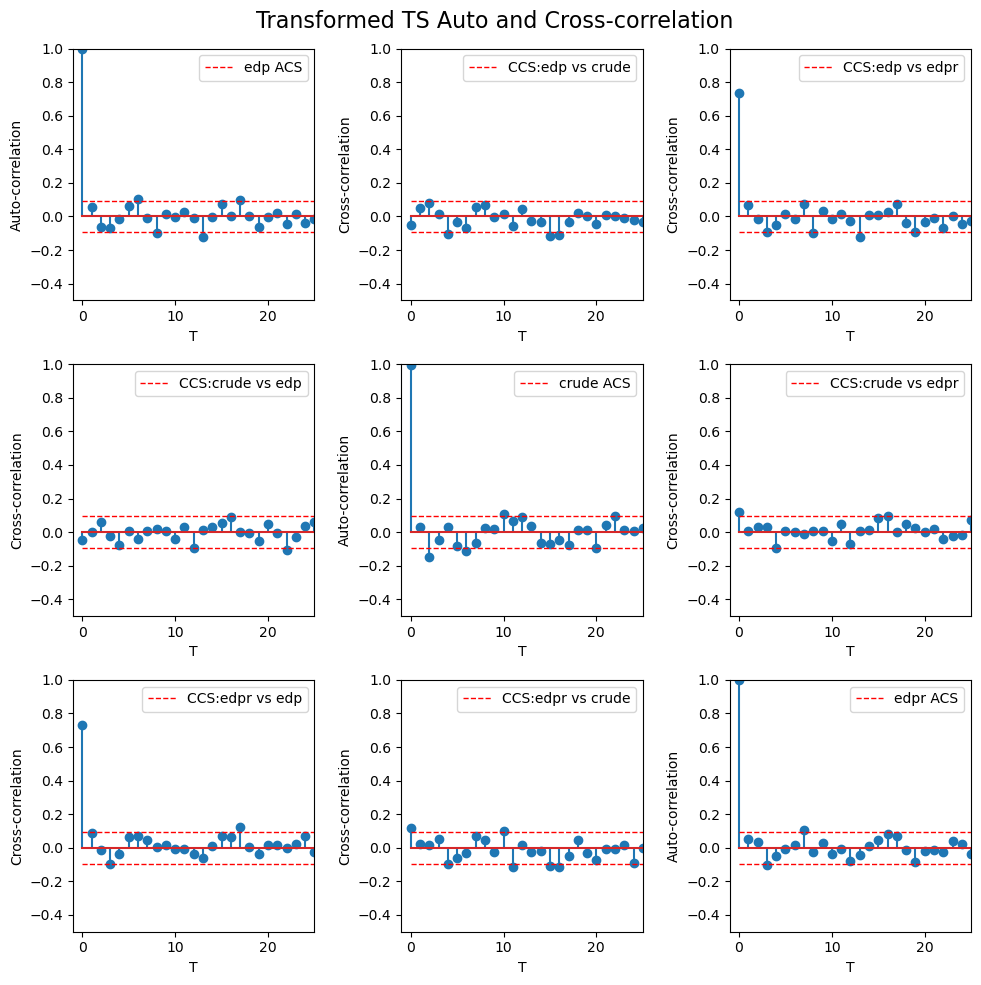

In [101]:
def crosscov(timeserie1,timeserie2,T=0):
    print("here6")
    N=np.array([timeserie1.size,timeserie2.size]).min()
    mu1=timeserie1.mean()
    mu2=timeserie2.mean()
    covCoef=0
    print("here7")
    print(T,N)
    for n in range(0,N-T-1):
        covCoef=covCoef+(timeserie1[n]-mu1)*(timeserie2[n+T]-mu2)
        print(n)
    print("here8")
    return covCoef/float(np.abs(N))
        

def crosscoef(timeserie1,timeserie2,T=0):
    print("here5")
    s1=timeserie1.std()
    s2=timeserie2.std()
    return crosscov(timeserie1,timeserie2,T)/(s1*s2)

def ccs(timeserie1,timeserie2,maxT,twoside=False):
    N=np.array([timeserie1.size,timeserie2.size]).min()
    if twoside:
        corrl=np.zeros(2*maxT+1)
        ix=np.array(range(maxT+1))
        ix=np.concatenate((-np.flip(ix[1:]),ix),axis=0)
    else:
        corrl=np.zeros(maxT+1)  
        ix=np.array(range(maxT+1))
    print('here')
    for i in range(maxT+1):
        if twoside:
            print("here3")
            if i==0:
                corrl[i+maxT]=crosscoef(timeserie1,timeserie2,i);
            else:
                corrl[i+maxT]=crosscoef(timeserie1,timeserie2,i);
                corrl[maxT-i]=crosscoef(timeserie2,timeserie1,i);
        else:
            print("here4")
            corrl[i]=crosscoef(timeserie1,timeserie2,i);
    print('here2')
    
    d = {'CCS':corrl, 'upsig':np.ones(maxT+1)*(1.96/np.sqrt(N)),'dnsig':-np.ones(maxT+1)*(1.96/np.sqrt(N))}
    corrl=pd.DataFrame(data=d,index=ix)
    return corrl

def plotScatterMatrix(X,fsize=(10,10),axi=[-2,6,-2,6],title='Scatter Plot'):
    nTS=len(X)
    figs,axs=plt.subplots(nTS,nTS, tight_layout=True,figsize=fsize)
    figs.suptitle(title, fontsize=16)
    for i in range(nTS):
        for j in range(nTS):
            if i!=j:
                #corrl.name='CCS:'+X[i].name+' vs '+X[j].name
                #ylbl="Cross-correlation" 
                #print(X[i],X[j])
                axs[i,j].scatter(X[i],X[j], alpha=0.5)
                axs[i,j].set_xlabel(X[i].name)
                axs[i,j].set_ylabel(X[j].name)
                #axs[i,j].legend([corrl.name])
                axs[i,j].axis(axi)
            else:
                axs[i,j].text(0.5,0.5,X[i].name)   


def plotCCSMatrix(X,maxT=25,fsize=(10,10),axi=[-1,25,-0.5,1],title='Auto- Cross-correlation Plots'):
    nTS=len(X)
    print("nTS",nTS)
    figs,axs=plt.subplots(nTS,nTS, tight_layout=True,figsize=fsize)
    figs.suptitle(title, fontsize=16)
    for i in range(nTS):
        for j in range(nTS):
            print("i")
            corrl=ccs(X[i],X[j],maxT)
            if i==j:
                corrl.name=X[i].name+' ACS'
                ylbl="Auto-correlation"
            else:
                corrl.name='CCS:'+X[i].name+' vs '+X[j].name
                ylbl="Cross-correlation" 
                
            axs[i,j].stem(corrl.index,corrl['CCS'])
            axs[i,j].plot(corrl.index,corrl['upsig'],linestyle='--', color='r', linewidth=1)
            axs[i,j].plot(corrl.index,corrl['dnsig'],linestyle='--', color='r', linewidth=1)
            axs[i,j].set_xlabel("T")
            axs[i,j].set_ylabel(ylbl)
            axs[i,j].legend([corrl.name])
            axs[i,j].axis(axi)


plotScatterMatrix(X,title='Transformed TS scatter plot')
            
plotCCSMatrix(X,title='Transformed TS Auto and Cross-correlation')

phi=
[[[ 0.01966886 -0.00677322  0.03011721]
  [ 0.1441113  -0.05734406 -0.25251176]
  [ 0.41001195  0.26817475 -0.20968595]]]
nTS 3
i
here
here4
here5
here6
here7
0 70
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
here8
here4
here5
here6
here7
1 70
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
here8
here4
here5
here6
here7
2 70
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
here8
here4
here5
here6
here7
3 70
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
5

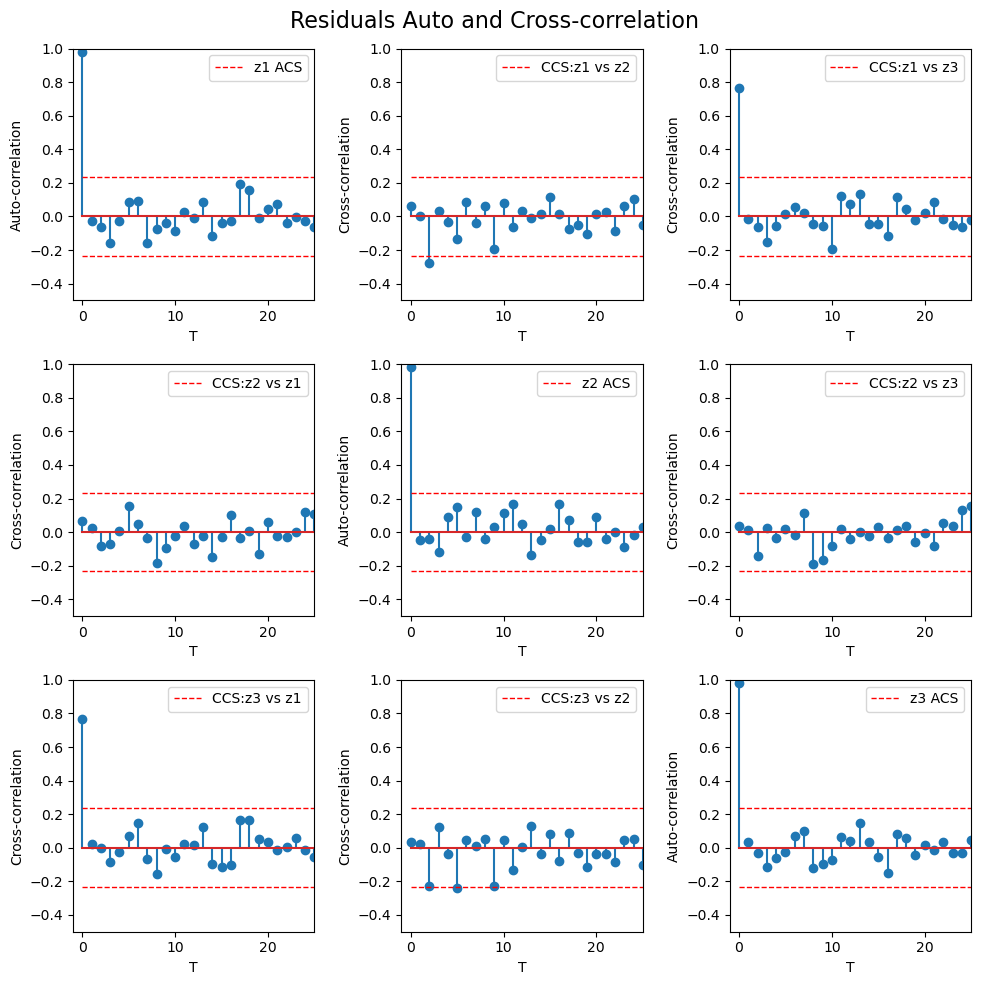

In [102]:
import statsmodels.api as sm


#Split training & test data
"""
startTrain='1948'
stopTrain='2006'

startTest='2007'
stopTest='2008'
"""

gdpCTS_TR=gdpCTS[0:70]
gdpCTS_TE=gdpCTS[69:75]

unrCTS_TR=unrCTS[0:70]
unrCTS_TE=unrCTS[69:75]

cpiCTS_TR=cpiCTS[0:70]
cpiCTS_TE=cpiCTS[69:75]

trainInputs=np.array([gdpCTS_TR,unrCTS_TR,cpiCTS_TR]).transpose()

testInputs=np.array([gdpCTS_TE,unrCTS_TE,cpiCTS_TE]).transpose()

mod = sm.tsa.VARMAX(endog=trainInputs, order=(1,0))
res = mod.fit(maxiter=10000, disp=False)
print('phi=')
print(res.coefficient_matrices_var)



#Get residues
resid=res.resid

zgdpTS=pd.Series(data=resid[:,0],index=gdpCTS_TR.index, name='z1')
zunrTS=pd.Series(data=resid[:,1],index=unrCTS_TR.index, name='z2')
zcpiTS=pd.Series(data=resid[:,2],index=cpiCTS_TR.index, name='z3')
            
plotCCSMatrix([zgdpTS,zunrTS,zcpiTS],title='Residuals Auto and Cross-correlation')



<Axes: xlabel='Date'>

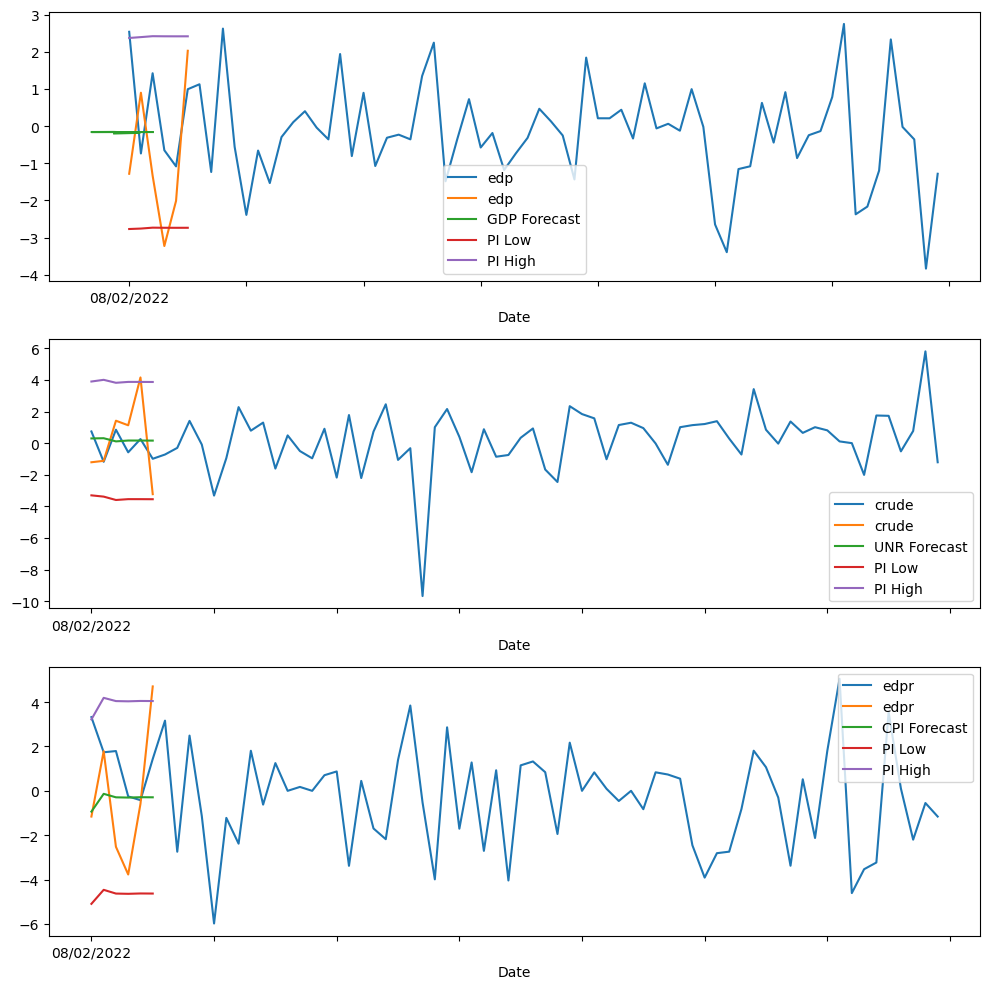

In [103]:
forecast=res.get_forecast(steps=cpiCTS_TE.size)

#Plot training + test + forecasts
fig, axs=plt.subplots(3,tight_layout=True,figsize=(10,10))

gdpCTS_TR.plot(ax=axs[0],legend=True)
gdpCTS_TE.plot(ax=axs[0],legend=True)

unrCTS_TR.plot(ax=axs[1],legend=True)
unrCTS_TE.plot(ax=axs[1],legend=True)

cpiCTS_TR.plot(ax=axs[2],legend=True)
cpiCTS_TE.plot(ax=axs[2],legend=True)

gdpCTS_FC=pd.Series(data=forecast.predicted_mean[:,0],index=gdpCTS_TE,name='GDP Forecast')
gdpCTS_FC_LCI=pd.Series(data=forecast.conf_int()[:,0],index=gdpCTS_TE.index,name='PI Low')
gdpCTS_FC_UCI=pd.Series(data=forecast.conf_int()[:,3],index=gdpCTS_TE.index,name='PI High')

unrCTS_FC=pd.Series(data=forecast.predicted_mean[:,1],index=unrCTS_TE.index,name='UNR Forecast')
unrCTS_FC_LCI=pd.Series(data=forecast.conf_int()[:,1],index=unrCTS_TE.index,name='PI Low')
unrCTS_FC_UCI=pd.Series(data=forecast.conf_int()[:,4],index=unrCTS_TE.index,name='PI High')

cpiCTS_FC=pd.Series(data=forecast.predicted_mean[:,2],index=cpiCTS_TE.index,name='CPI Forecast')
cpiCTS_FC_LCI=pd.Series(data=forecast.conf_int()[:,2],index=unrCTS_TE.index,name='PI Low')
cpiCTS_FC_UCI=pd.Series(data=forecast.conf_int()[:,5],index=unrCTS_TE.index,name='PI High')

gdpCTS_FC.plot(ax=axs[0],legend=True)
gdpCTS_FC_LCI.plot(ax=axs[0],legend=True)
gdpCTS_FC_UCI.plot(ax=axs[0],legend=True)

unrCTS_FC.plot(ax=axs[1],legend=True)
unrCTS_FC_LCI.plot(ax=axs[1],legend=True)
unrCTS_FC_UCI.plot(ax=axs[1],legend=True)

cpiCTS_FC.plot(ax=axs[2],legend=True)
cpiCTS_FC_LCI.plot(ax=axs[2],legend=True)
cpiCTS_FC_UCI.plot(ax=axs[2],legend=True)



In [104]:
startTrain=0
stopTrain=70

startTest=69
stopTest=75

<Axes: xlabel='Date'>

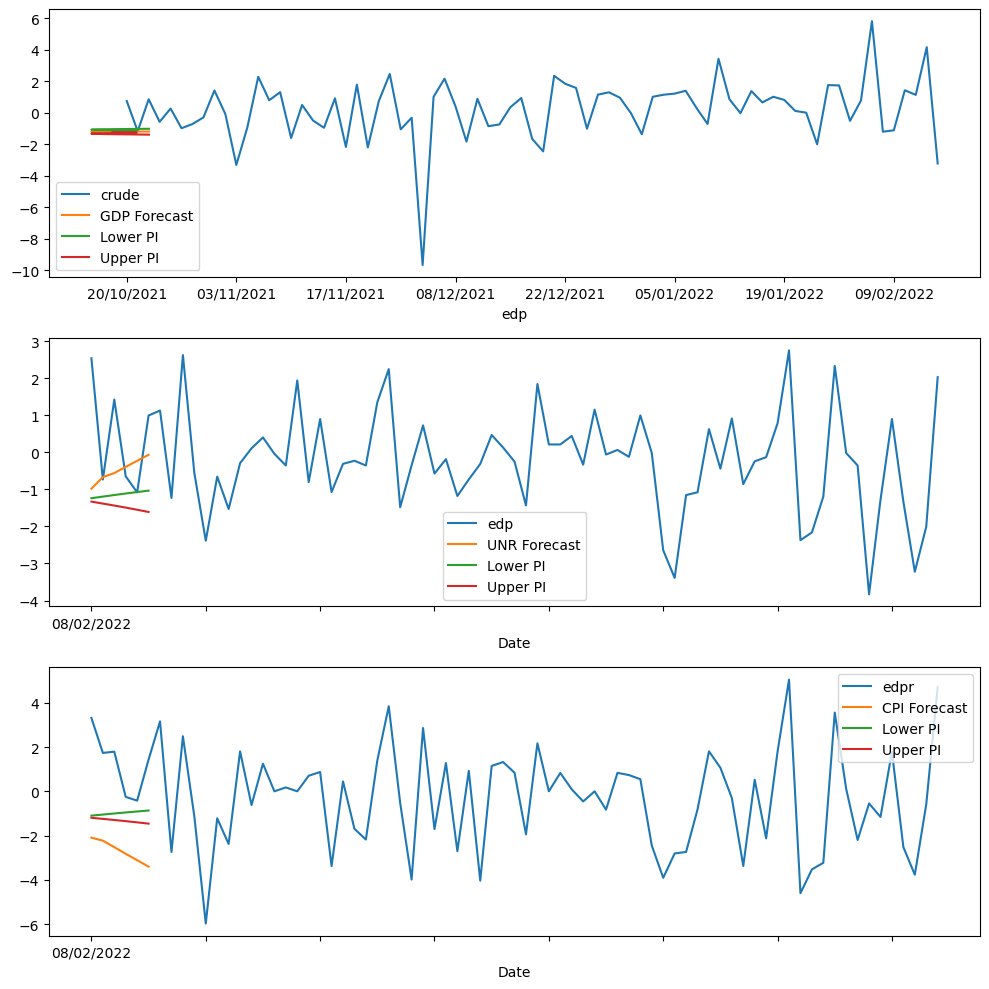

In [105]:
#GDP 
gdpFC=np.zeros(gdpCTS_TE.size)
gdpFCLB=np.zeros(gdpCTS_TE.size)
gdpFCUB=np.zeros(gdpCTS_TE.size)

gdp_i_1=unrCTS[startTrain:stopTrain].to_list()[-1]
gdpLB_i_1=unrCTS[startTrain:stopTrain].to_list()[-1]
gdpUB_i_1=unrCTS[startTrain:stopTrain].to_list()[-1]

for i in range(gdpCTS_TE.size):
    gdpFC[i]=gdpCTS_FC.iloc[i]/100*gdp_i_1+gdp_i_1
    gdpFCLB[i]=gdpCTS_FC_LCI.iloc[i]/100*gdpLB_i_1+gdpLB_i_1
    gdpFCUB[i]=gdpCTS_FC_UCI.iloc[i]/100*gdpUB_i_1+gdpUB_i_1
    
    gdp_i_1=gdpFC[i]
    gdpLB_i_1=gdpFCLB[i]
    gdpUB_i_1=gdpFCUB[i]
    
gdpTS_FC=pd.Series(data=gdpFC, index=gdpCTS_FC.index,name='GDP Forecast')
gdpTS_FC_LB=pd.Series(data=gdpFCLB, index=gdpCTS_FC.index,name='Lower PI')
gdpTS_FC_UB=pd.Series(data=gdpFCUB, index=gdpCTS_FC.index,name='Upper PI')

#UNR
unrFC=np.zeros(unrCTS_TE.size)
unrFCLB=np.zeros(unrCTS_TE.size)
unrFCUB=np.zeros(unrCTS_TE.size)
unr_i_1=gdpCTS[startTrain:stopTrain].to_list()[-1]
unrLB_i_1=gdpCTS[startTrain:stopTrain].to_list()[-1]
unrUB_i_1=gdpCTS[startTrain:stopTrain].to_list()[-1]

for i in range(unrCTS_TE.size):
    unrFC[i]=unrCTS_FC.iloc[i]+unr_i_1
    unrFCLB[i]=unrCTS_FC_LCI.iloc[i]/100*unrLB_i_1+unrLB_i_1
    unrFCUB[i]=unrCTS_FC_UCI.iloc[i]/100*unrUB_i_1+unrUB_i_1
    unr_i_1=unrFC[i]
    unrLB_i_1=unrFCLB[i]
    unrUB_i_1=unrFCUB[i]
    
unrTS_FC=pd.Series(data=unrFC, index=unrCTS_FC.index,name='UNR Forecast')
unrTS_FC_LB=pd.Series(data=unrFCLB, index=unrCTS_FC.index,name='Lower PI')
unrTS_FC_UB=pd.Series(data=unrFCUB, index=unrCTS_FC.index,name='Upper PI')

#CPI
cpiFC=np.zeros(cpiCTS_TE.size)
cpiFCLB=np.zeros(cpiCTS_TE.size)
cpiFCUB=np.zeros(cpiCTS_TE.size)

cpi_i_1=cpiCTS[startTrain:stopTrain].to_list()[-1]
cpiLB_i_1=cpiCTS[startTrain:stopTrain].to_list()[-1]
cpiUB_i_1=cpiCTS[startTrain:stopTrain].to_list()[-1]

for i in range(cpiCTS_TE.size):
    cpiFC[i]=cpiCTS_FC.iloc[i]+cpi_i_1
    cpiFCLB[i]=cpiCTS_FC_LCI.iloc[i]/100*cpiLB_i_1+cpiLB_i_1
    cpiFCUB[i]=cpiCTS_FC_UCI.iloc[i]/100*cpiUB_i_1+cpiUB_i_1   
    cpi_i_1=cpiFC[i]
    cpiLB_i_1=cpiFCLB[i]
    cpiUB_i_1=cpiFCUB[i]
    
cpiTS_FC=pd.Series(data=cpiFC, index=cpiCTS_FC.index,name='CPI Forecast')
cpiTS_FC_LB=pd.Series(data=cpiFCLB, index=cpiCTS_FC.index,name='Lower PI')
cpiTS_FC_UB=pd.Series(data=cpiFCUB, index=cpiCTS_FC.index,name='Upper PI')

#Plot original data
fig, axs=plt.subplots(3,tight_layout=True,figsize=(10,10))
unrCTS[0:75].plot(ax=axs[0],legend=True)
gdpTS_FC.plot(ax=axs[0],legend=True)
gdpTS_FC_LB.plot(ax=axs[0],legend=True)
gdpTS_FC_UB.plot(ax=axs[0],legend=True)

gdpCTS[0:75].plot(ax=axs[1],legend=True)
unrTS_FC.plot(ax=axs[1],legend=True)
unrTS_FC_LB.plot(ax=axs[1],legend=True)
unrTS_FC_UB.plot(ax=axs[1],legend=True)


cpiCTS[0:75].plot(ax=axs[2],legend=True)
cpiTS_FC.plot(ax=axs[2],legend=True)
cpiTS_FC_LB.plot(ax=axs[2],legend=True)
cpiTS_FC_UB.plot(ax=axs[2],legend=True)
    

# Machine Learning


In [279]:
merged_data

Close_edp  Close_crude  time_int  Close_edpr
0        4.773        85.02         0      22.280
1        4.894        85.76         1      23.020
2        4.858        84.58         2      23.420
3        4.927        85.43         3      23.840
4        4.895        84.85         4      23.780
..         ...          ...       ...         ...
433      3.821        91.21       433      15.100
434      3.622        94.46       434      13.885
435      3.612        89.83       435      13.980
436      3.662        88.28       436      14.240
437      3.636        87.86       437      14.220

[438 rows x 4 columns]

In [280]:
lisDataTR=merged_data[0:70]
lisDataVL=merged_data[70:75]
lisDataTE=merged_data[75:80]

<Axes: >

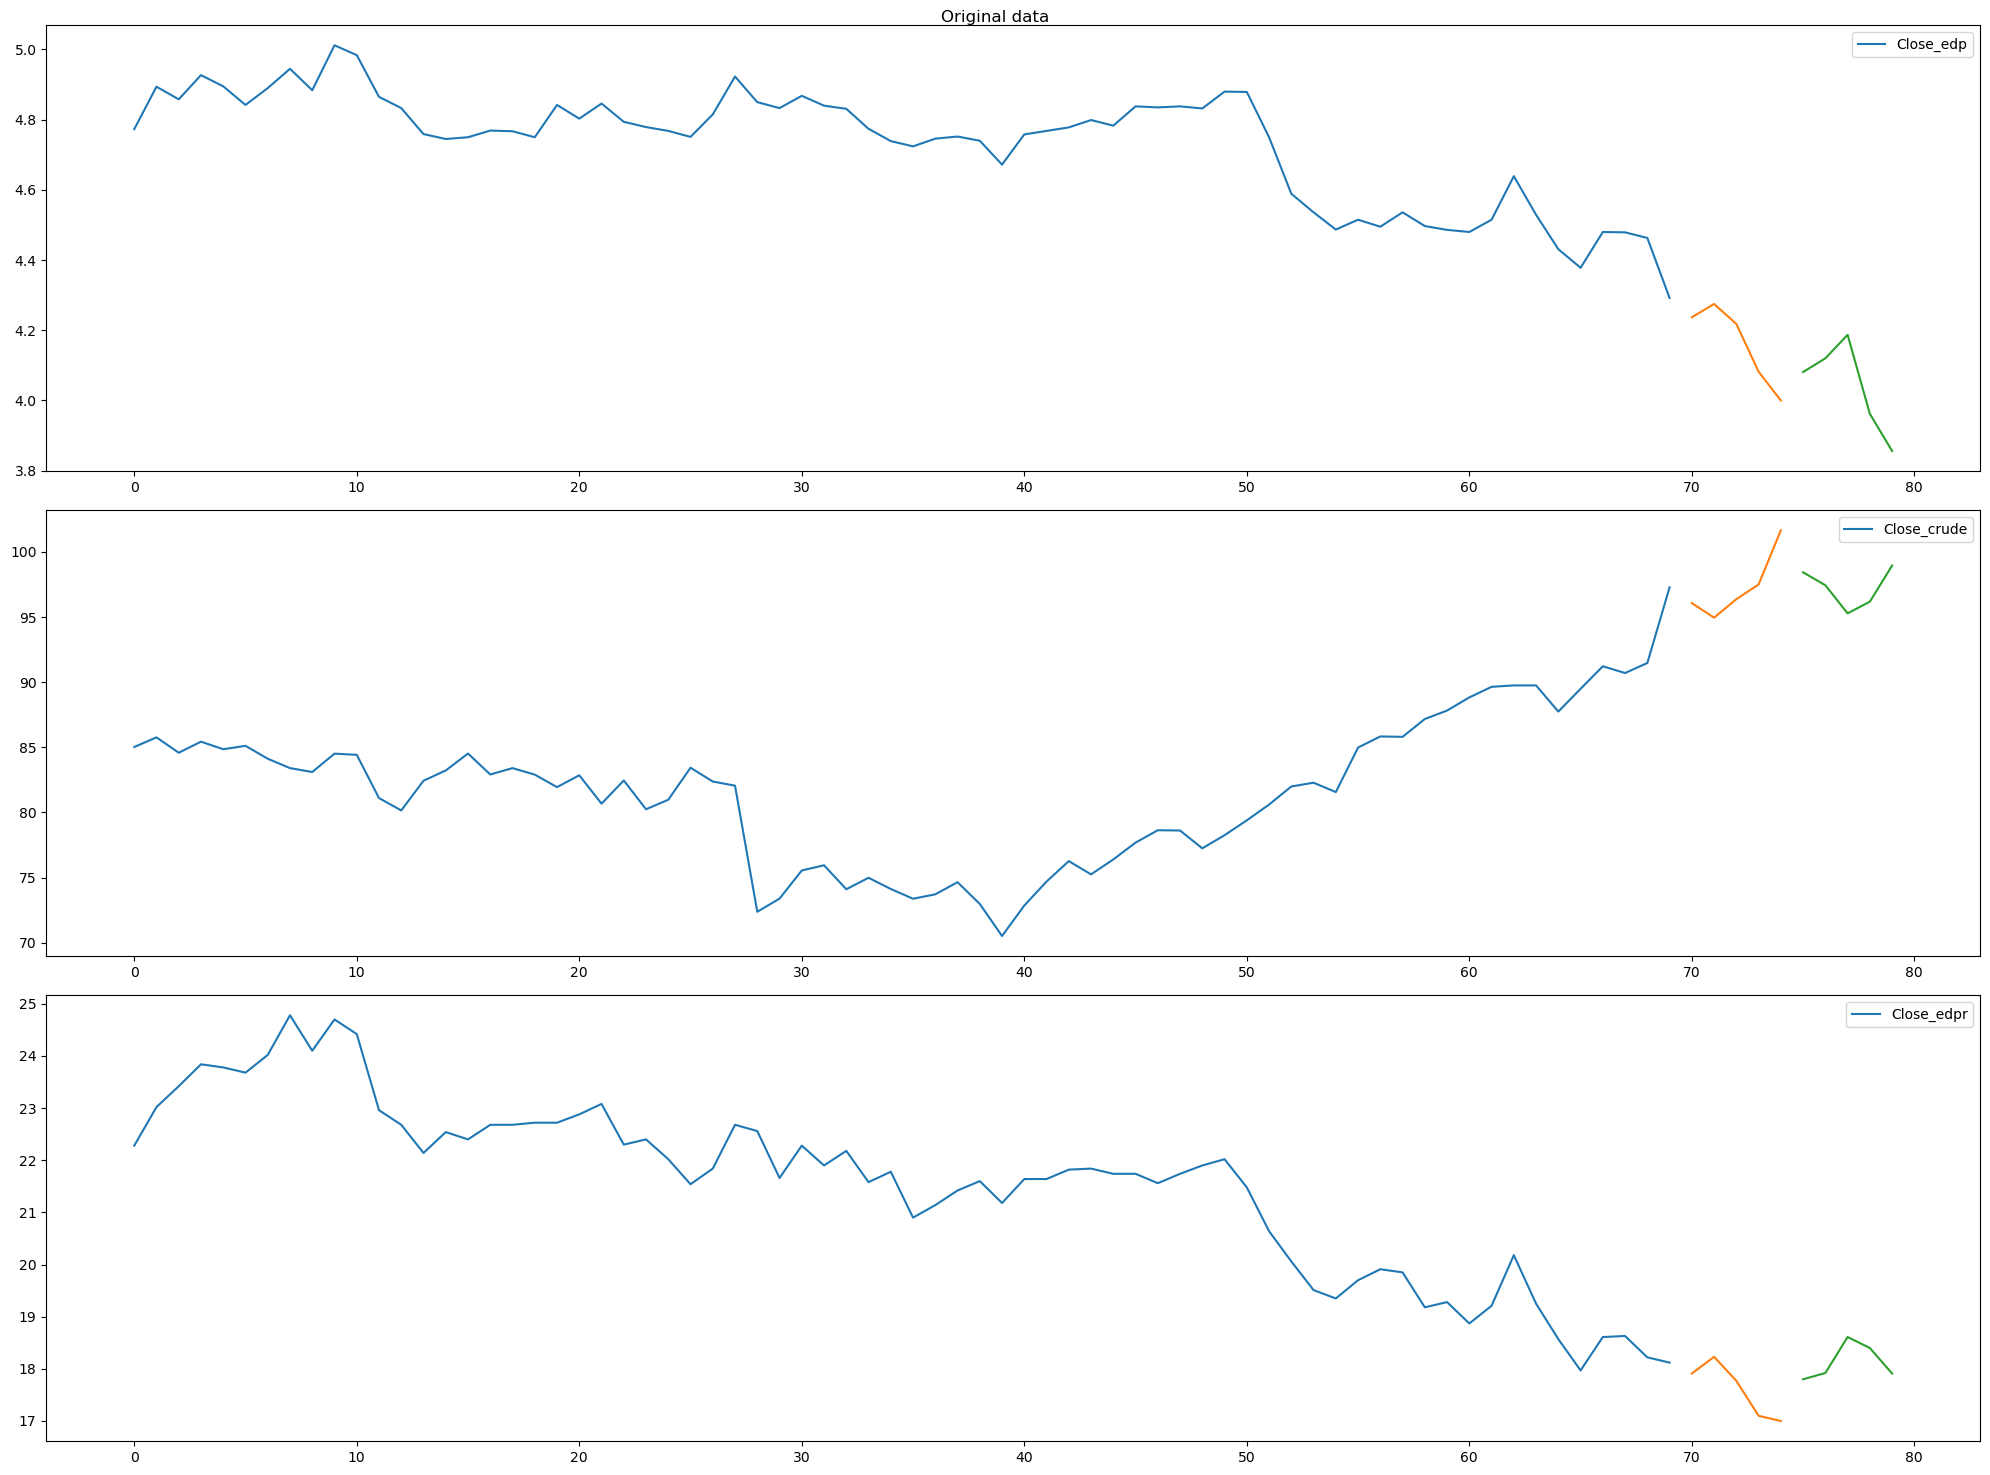

In [281]:

figs,axs=plt.subplots(3, tight_layout=True,figsize=(20,15))
figs.suptitle('Original data')

lisDataTR['Close_edp'].plot(ax=axs[0],legend=True)
lisDataTR['Close_crude'].plot(ax=axs[1],legend=True)
lisDataTR['Close_edpr'].plot(ax=axs[2],legend=True)

lisDataVL['Close_edp'].plot(ax=axs[0])
lisDataVL['Close_crude'].plot(ax=axs[1])
lisDataVL['Close_edpr'].plot(ax=axs[2])

lisDataTE['Close_edp'].plot(ax=axs[0])
lisDataTE['Close_crude'].plot(ax=axs[1])
lisDataTE['Close_edpr'].plot(ax=axs[2])




In [282]:
lisDataTR = lisDataTR.drop("Date", axis=1)
lisDataVL = lisDataVL.drop("Date", axis=1)
lisDataTE = lisDataTE.drop("Date", axis=1)

KeyError: "['Date'] not found in axis"

/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


<Axes: xlabel='time_int'>

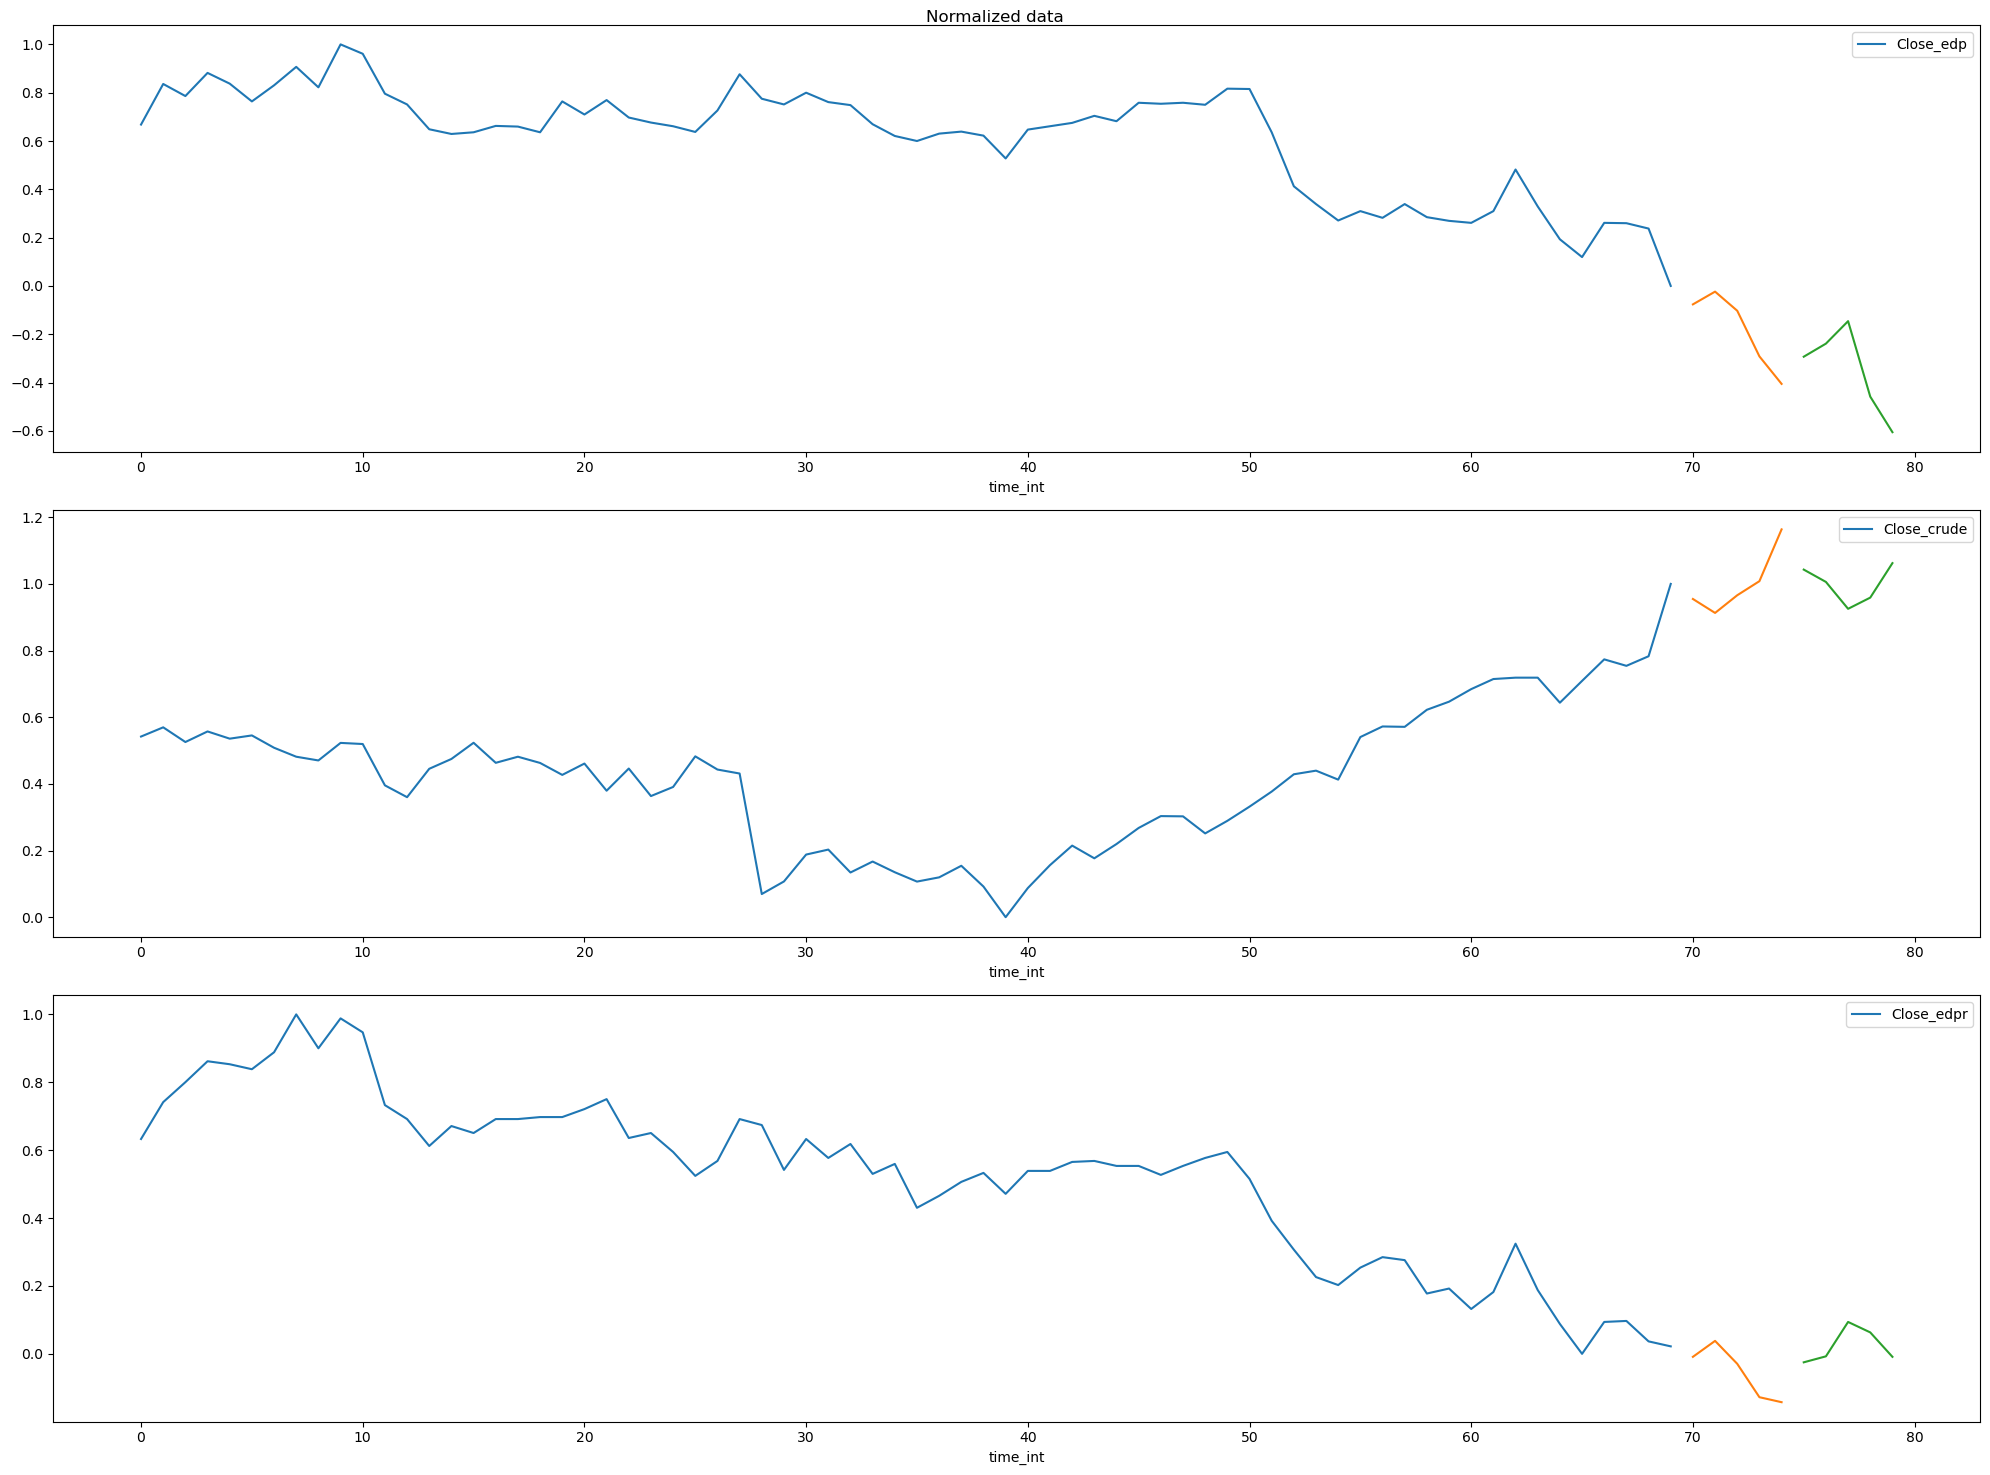

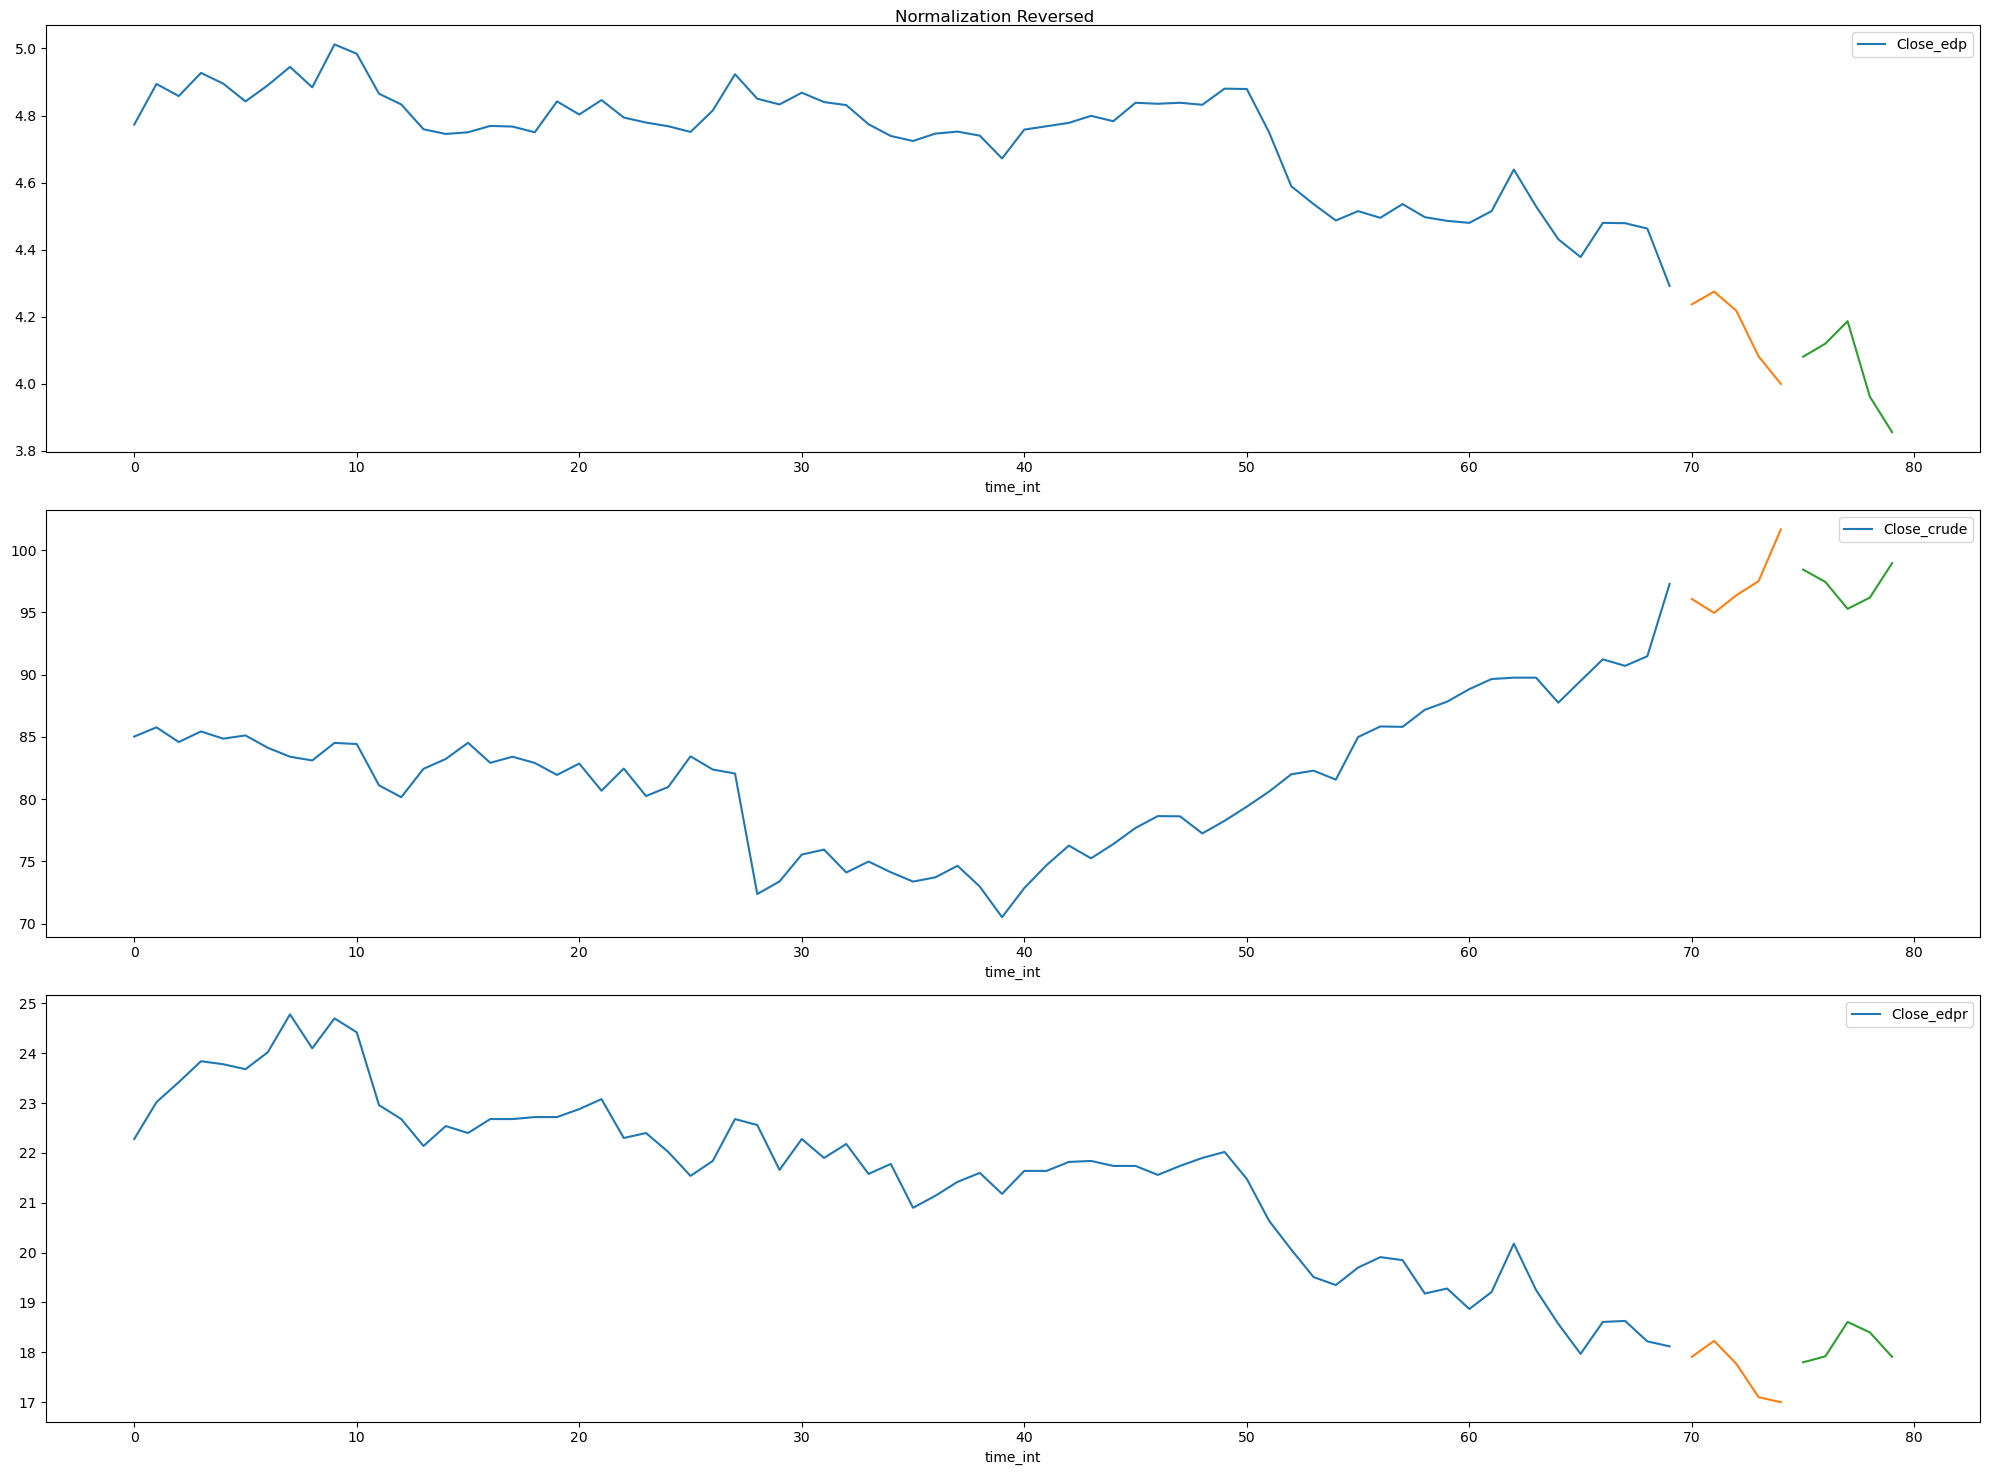

In [283]:
from sklearn.preprocessing import MinMaxScaler

# train the normalization
scaler = MinMaxScaler(feature_range=(0, 1)) #Normalize between 0 and 1
scaler = scaler.fit(lisDataTR.to_numpy())

#Apply normalization
lisDataTRnorm = pd.DataFrame(data=scaler.transform(lisDataTR),index=lisDataTR["time_int"],columns=lisDataTR.columns)
lisDataVLnorm = pd.DataFrame(data=scaler.transform(lisDataVL),index=lisDataVL["time_int"],columns=lisDataVL.columns)
lisDataTEnorm = pd.DataFrame(data=scaler.transform(lisDataTE),index=lisDataTE["time_int"],columns=lisDataTE.columns)

figs,axs=plt.subplots(3, tight_layout=True,figsize=(20,15))
figs.suptitle('Normalized data')
lisDataTRnorm['Close_edp'].plot(ax=axs[0],legend=True)
lisDataTRnorm['Close_crude'].plot(ax=axs[1],legend=True)
lisDataTRnorm['Close_edpr'].plot(ax=axs[2],legend=True)

lisDataVLnorm['Close_edp'].plot(ax=axs[0])
lisDataVLnorm['Close_crude'].plot(ax=axs[1])
lisDataVLnorm['Close_edpr'].plot(ax=axs[2])

lisDataTEnorm['Close_edp'].plot(ax=axs[0])
lisDataTEnorm['Close_crude'].plot(ax=axs[1])
lisDataTEnorm['Close_edpr'].plot(ax=axs[2])

#Revert normalization
lisDataTRnormR = pd.DataFrame(data=scaler.inverse_transform(lisDataTRnorm),index=lisDataTR["time_int"],columns=lisDataTR.columns)
lisDataVLnormR = pd.DataFrame(data=scaler.inverse_transform(lisDataVLnorm),index=lisDataVL["time_int"],columns=lisDataVL.columns)
lisDataTEnormR = pd.DataFrame(data=scaler.inverse_transform(lisDataTEnorm),index=lisDataTE["time_int"],columns=lisDataTE.columns)

figs,axs=plt.subplots(3, tight_layout=True,figsize=(20,15))
figs.suptitle('Normalization Reversed')
lisDataTRnormR['Close_edp'].plot(ax=axs[0],legend=True)
lisDataTRnormR['Close_crude'].plot(ax=axs[1],legend=True)
lisDataTRnormR['Close_edpr'].plot(ax=axs[2],legend=True)

lisDataVLnormR['Close_edp'].plot(ax=axs[0])
lisDataVLnormR['Close_crude'].plot(ax=axs[1])
lisDataVLnormR['Close_edpr'].plot(ax=axs[2])

lisDataTEnormR['Close_edp'].plot(ax=axs[0])
lisDataTEnormR['Close_crude'].plot(ax=axs[1])
lisDataTEnormR['Close_edpr'].plot(ax=axs[2])

/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


<Axes: xlabel='time_int'>

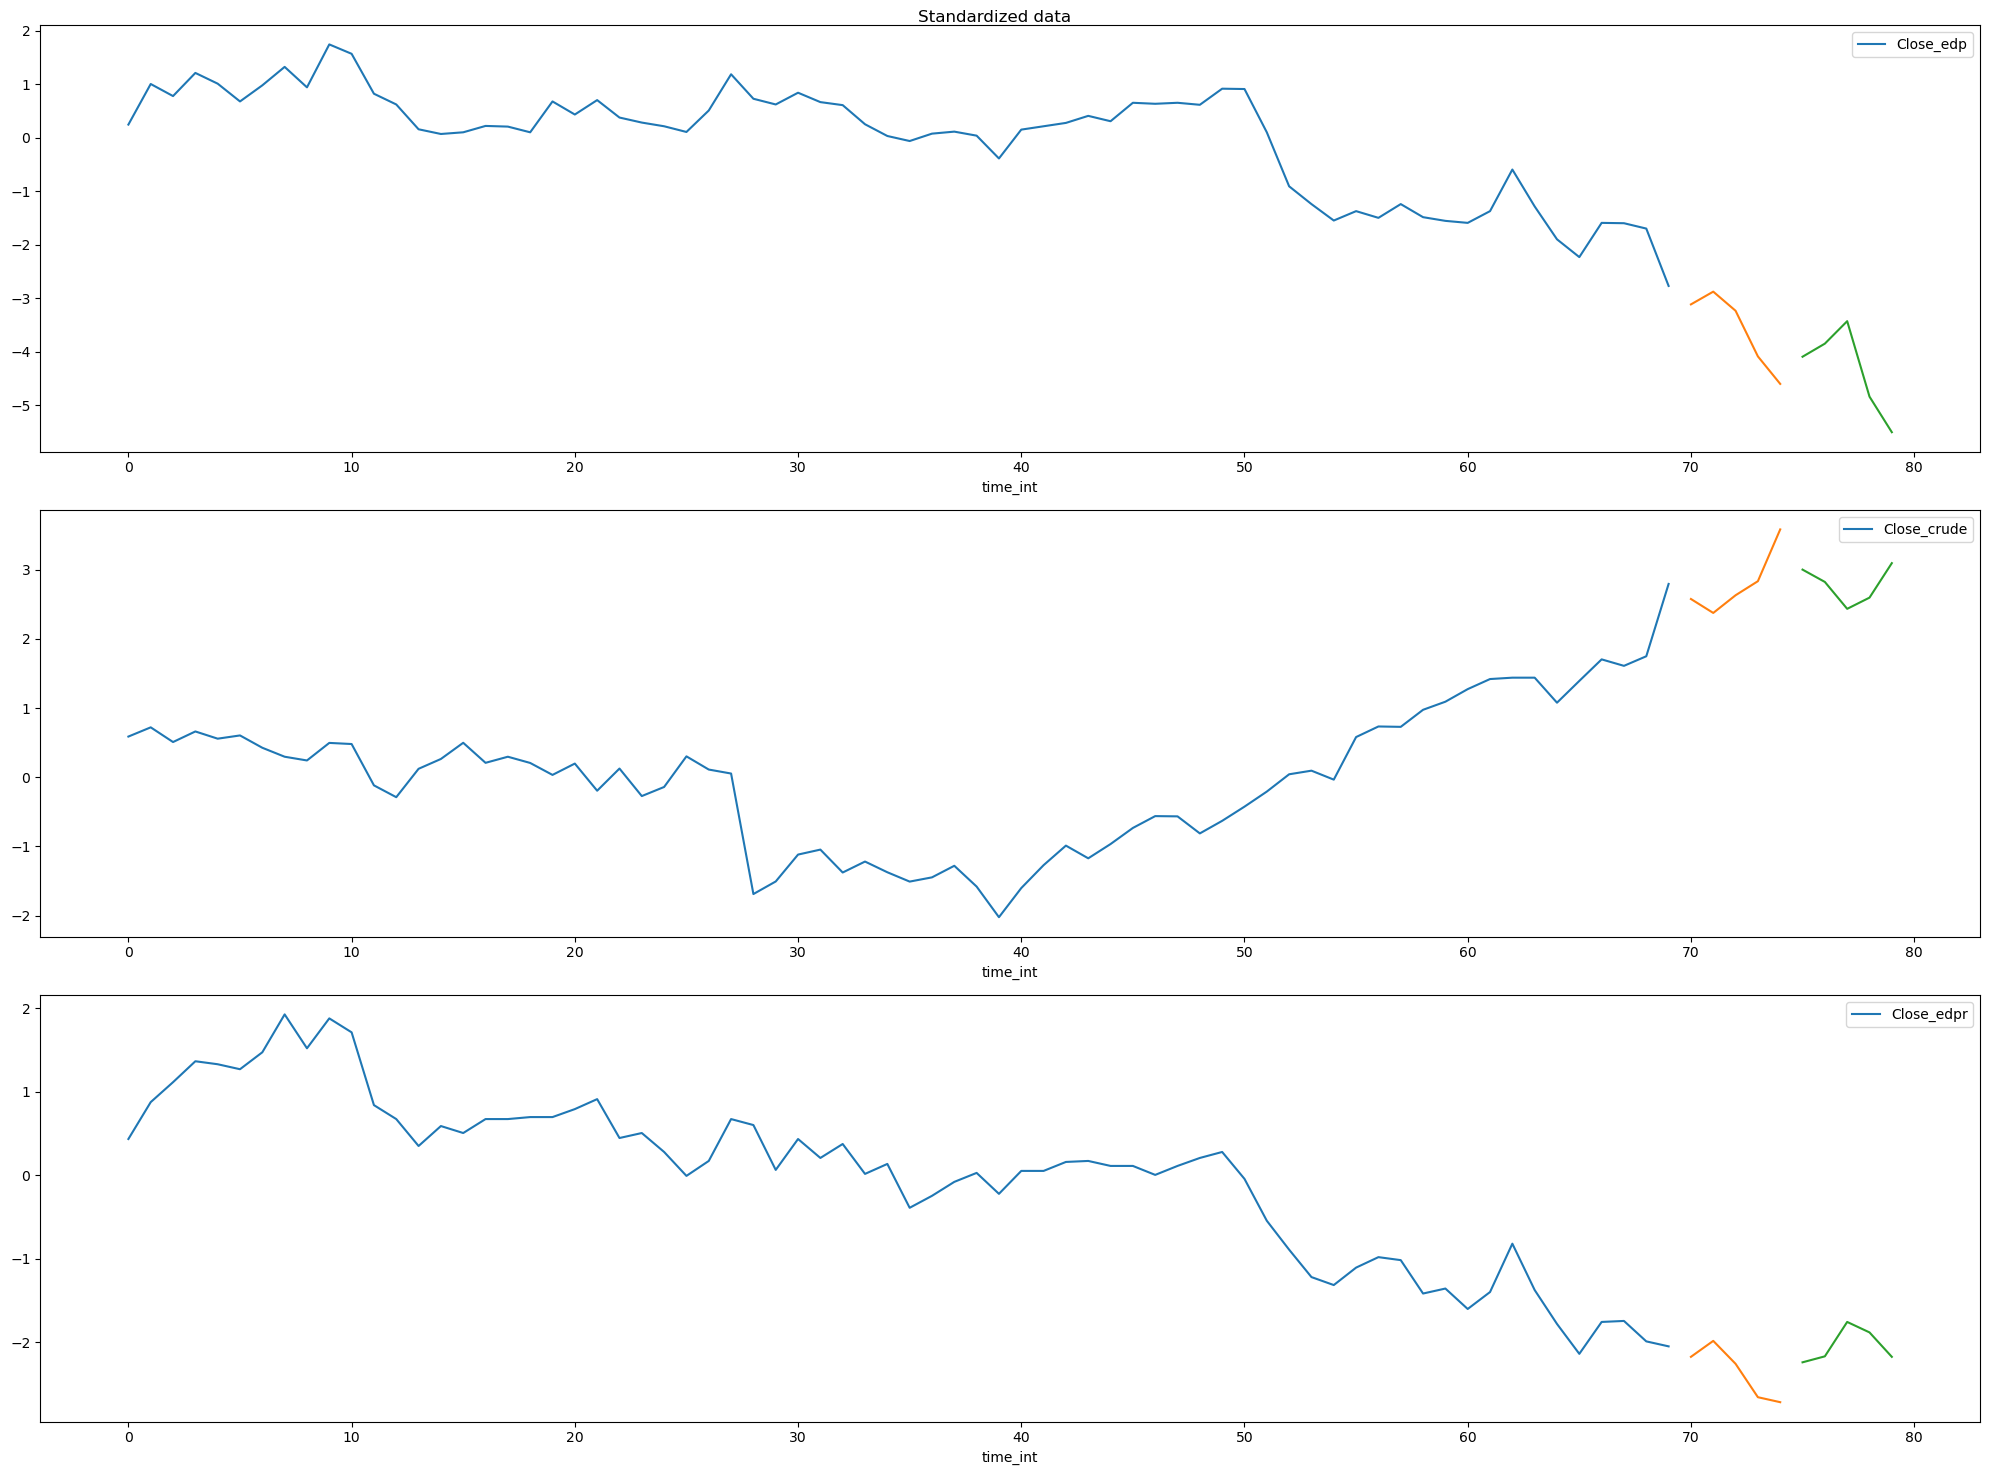

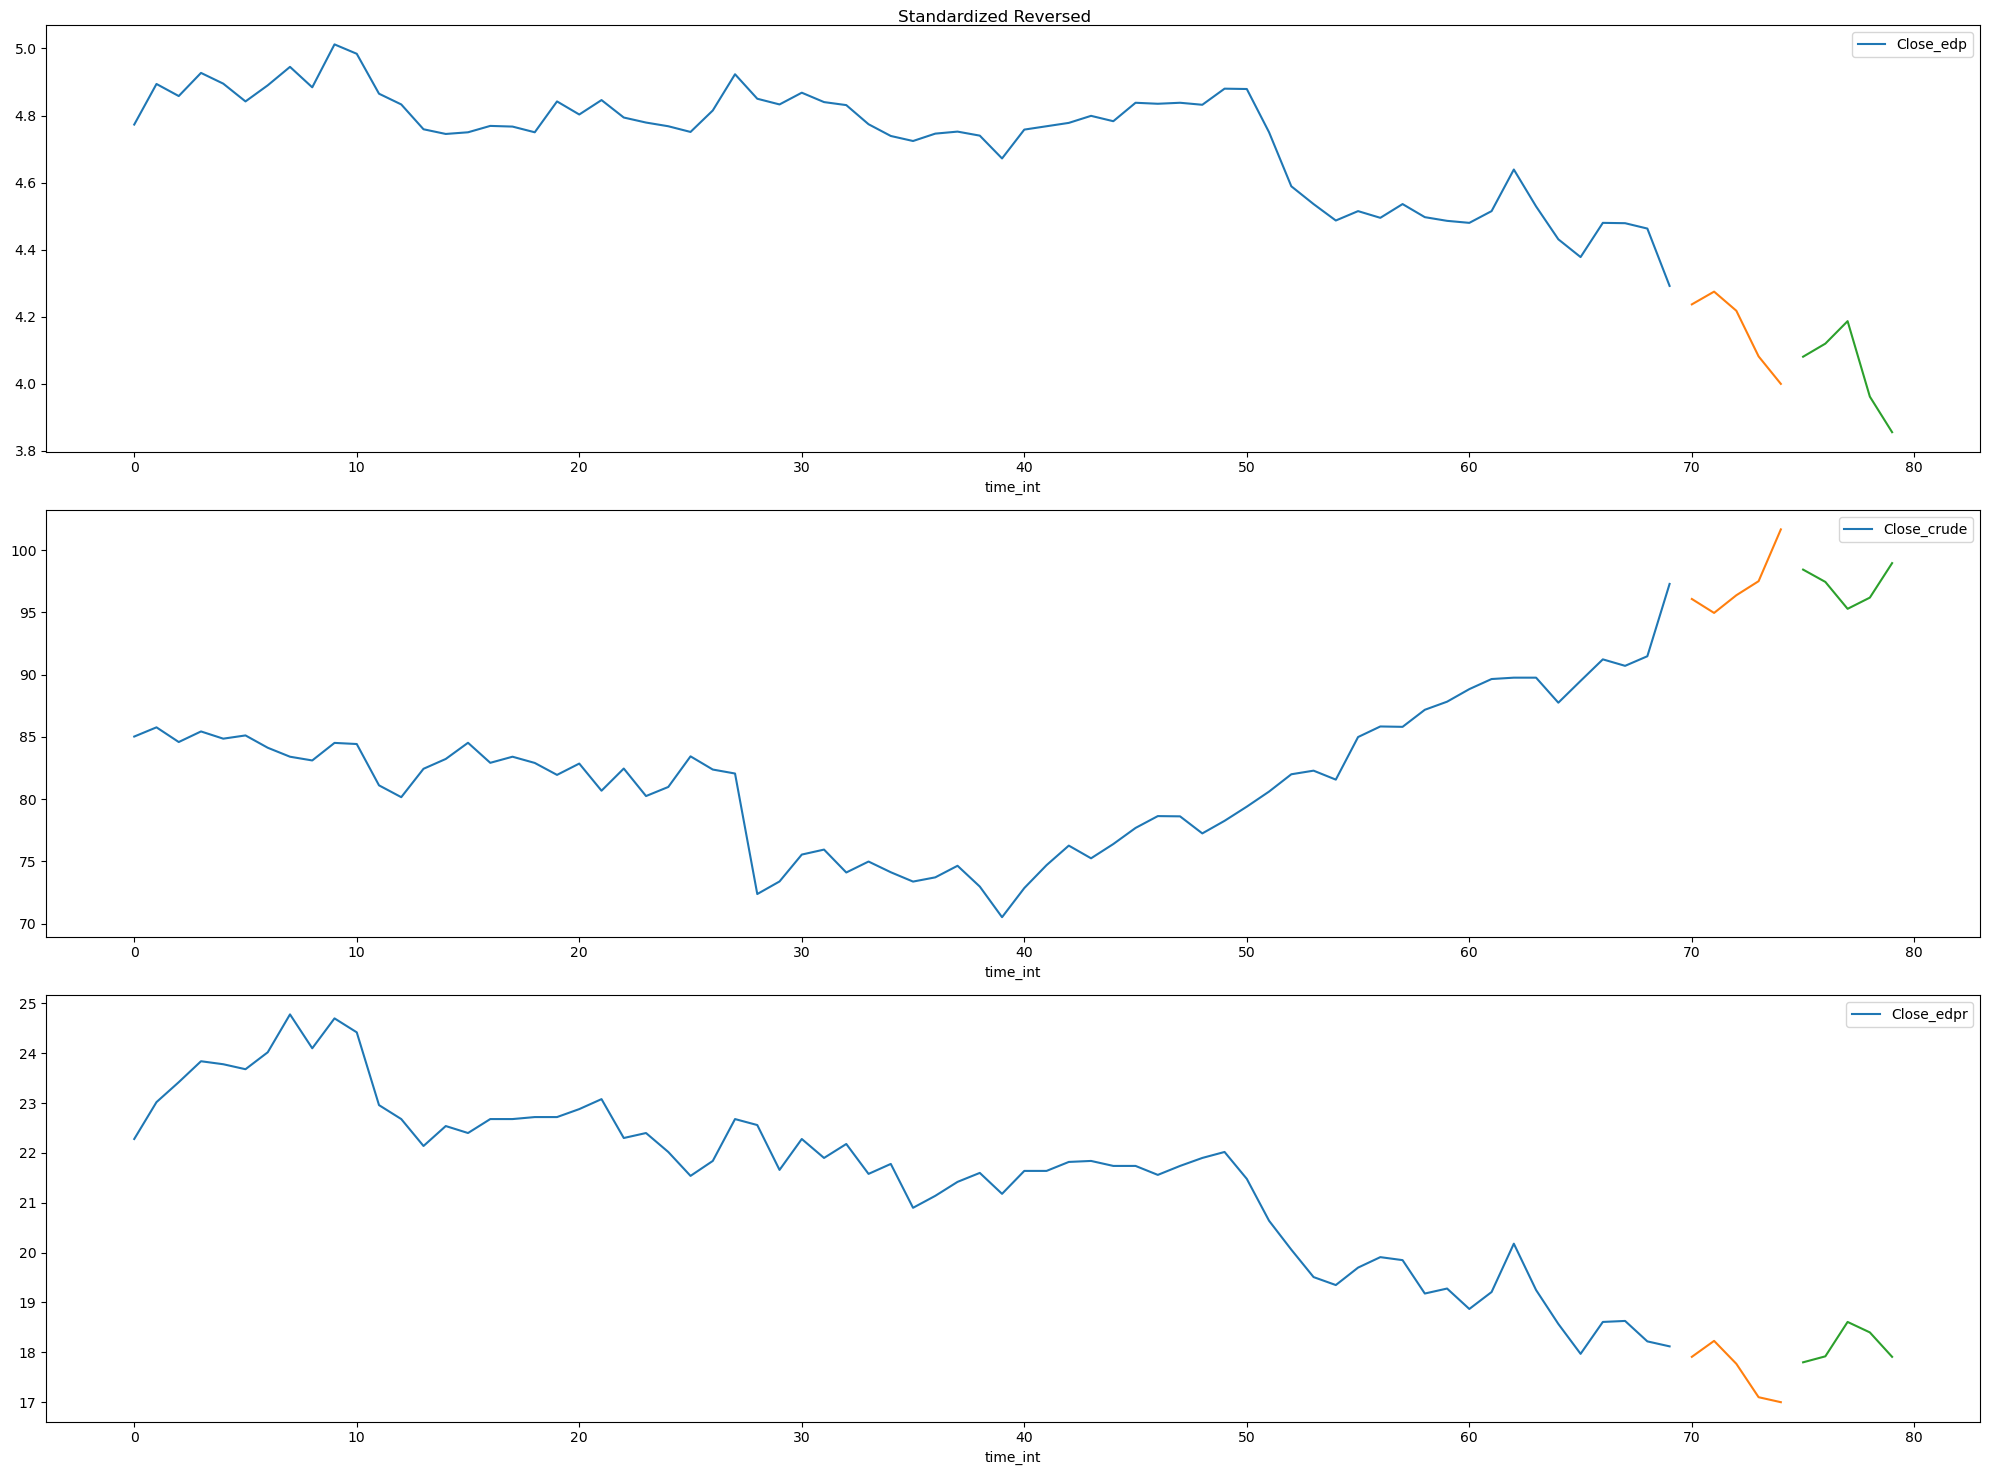

In [284]:
from sklearn.preprocessing import StandardScaler

# train the standardization
scaler = StandardScaler() #Standardize (mean=0, std=1)
scaler = scaler.fit(lisDataTR.to_numpy())

#Apply standardization
lisDataTRstd = pd.DataFrame(data=scaler.transform(lisDataTR),index=lisDataTR["time_int"],columns=lisDataTR.columns)
lisDataVLstd = pd.DataFrame(data=scaler.transform(lisDataVL),index=lisDataVL["time_int"],columns=lisDataVL.columns)
lisDataTEstd = pd.DataFrame(data=scaler.transform(lisDataTE),index=lisDataTE["time_int"],columns=lisDataTE.columns)

figs,axs=plt.subplots(3, tight_layout=True,figsize=(20,15))
figs.suptitle('Standardized data')
lisDataTRstd['Close_edp'].plot(ax=axs[0],legend=True)
lisDataTRstd['Close_crude'].plot(ax=axs[1],legend=True)
lisDataTRstd['Close_edpr'].plot(ax=axs[2],legend=True)

lisDataVLstd['Close_edp'].plot(ax=axs[0])
lisDataVLstd['Close_crude'].plot(ax=axs[1])
lisDataVLstd['Close_edpr'].plot(ax=axs[2])

lisDataTEstd['Close_edp'].plot(ax=axs[0])
lisDataTEstd['Close_crude'].plot(ax=axs[1])
lisDataTEstd['Close_edpr'].plot(ax=axs[2])

#Revert standardization
lisDataTRstdR = pd.DataFrame(data=scaler.inverse_transform(lisDataTRstd),index=lisDataTR["time_int"],columns=lisDataTR.columns)
lisDataVLstdR = pd.DataFrame(data=scaler.inverse_transform(lisDataVLstd),index=lisDataVL["time_int"],columns=lisDataVL.columns)
lisDataTEstdR = pd.DataFrame(data=scaler.inverse_transform(lisDataTEstd),index=lisDataTE["time_int"],columns=lisDataTE.columns)

figs,axs=plt.subplots(3, tight_layout=True,figsize=(20,15))
figs.suptitle('Standardized Reversed')
lisDataTRstdR['Close_edp'].plot(ax=axs[0],legend=True)
lisDataTRstdR['Close_crude'].plot(ax=axs[1],legend=True)
lisDataTRstdR['Close_edpr'].plot(ax=axs[2],legend=True)

lisDataVLstdR['Close_edp'].plot(ax=axs[0])
lisDataVLstdR['Close_crude'].plot(ax=axs[1])
lisDataVLstdR['Close_edpr'].plot(ax=axs[2])

lisDataTEstdR['Close_edp'].plot(ax=axs[0])
lisDataTEstdR['Close_crude'].plot(ax=axs[1])
lisDataTEstdR['Close_edpr'].plot(ax=axs[2])

In [285]:
#%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

def genIOData(outData,inData=pd.DataFrame(),delayEndog=[1],delayExog=[],h=1):
    N=outData.shape[0]
    inShape=inData.shape
    if len(inShape)==1:
        M=1
    else:
        M=inShape[1]# The number of explanatory TS (Exogenous inputs)
    
    laggedData=pd.DataFrame(index=inData.index)
    for i in range(M):
        for j in range(len(delayExog[i])):
            if isinstance(inData, pd.DataFrame):
                laggedData[inData.columns[i]+'_lag'+str(delayExog[i][j]+(h-1))] = inData[inData.columns[i]].shift(periods=delayExog[i][j]+(h-1))
            else:
                laggedData[inData.name+'_lag'+str(delayExog[i][j]+(h-1))] = inData.shift(periods=delayExog[i][j]+(h-1))
    
    for j in range(len(delayEndog)):
        laggedData[outData.name+'_lag'+str(delayEndog[j]+(h-1))] = outData.shift(periods=delayEndog[j]+(h-1))
    
    laggedData[outData.name]=outData
    
    return laggedData.dropna(axis=0)
    
def genTensor(data,T,M):
    dataMat=data.to_numpy()
    N=data.shape[0]
    Ti=0
    tensor=np.zeros((N,T,M))
    print(tensor.shape)
    for i in range(M):
        tensor[:,:,i]=dataMat[:,Ti:Ti+T]
        Ti=Ti+T
    
    return tensor


outData=lisDataTRnormR['Close_edp']
inData=lisDataTRnormR[['Close_crude','Close_edpr']]
dataDel=genIOData(outData=outData,inData=inData,delayEndog=[1,2],delayExog=[[1,2],[1,2]],h=1)

print(dataDel)
tens=genTensor(dataDel.iloc[:,0:-1],2,3)
print(tens[:,:,2])

          Close_crude_lag1  Close_crude_lag2  Close_edpr_lag1  \
time_int                                                        
2                    85.76             85.02            23.02   
3                    84.58             85.76            23.42   
4                    85.43             84.58            23.84   
5                    84.85             85.43            23.78   
6                    85.11             84.85            23.68   
...                    ...               ...              ...   
65                   87.74             89.75            18.57   
66                   89.49             87.74            17.97   
67                   91.22             89.49            18.61   
68                   90.70             91.22            18.63   
69                   91.47             90.70            18.22   

          Close_edpr_lag2  Close_edp_lag1  Close_edp_lag2  Close_edp  
time_int                                                              
2           

69    4.292
70    4.237
71    4.275
72    4.218
73    4.082
74    4.000
Name: Out-of-sample data, dtype: float64


Text(0.5, 25.722222222222214, 'Date')

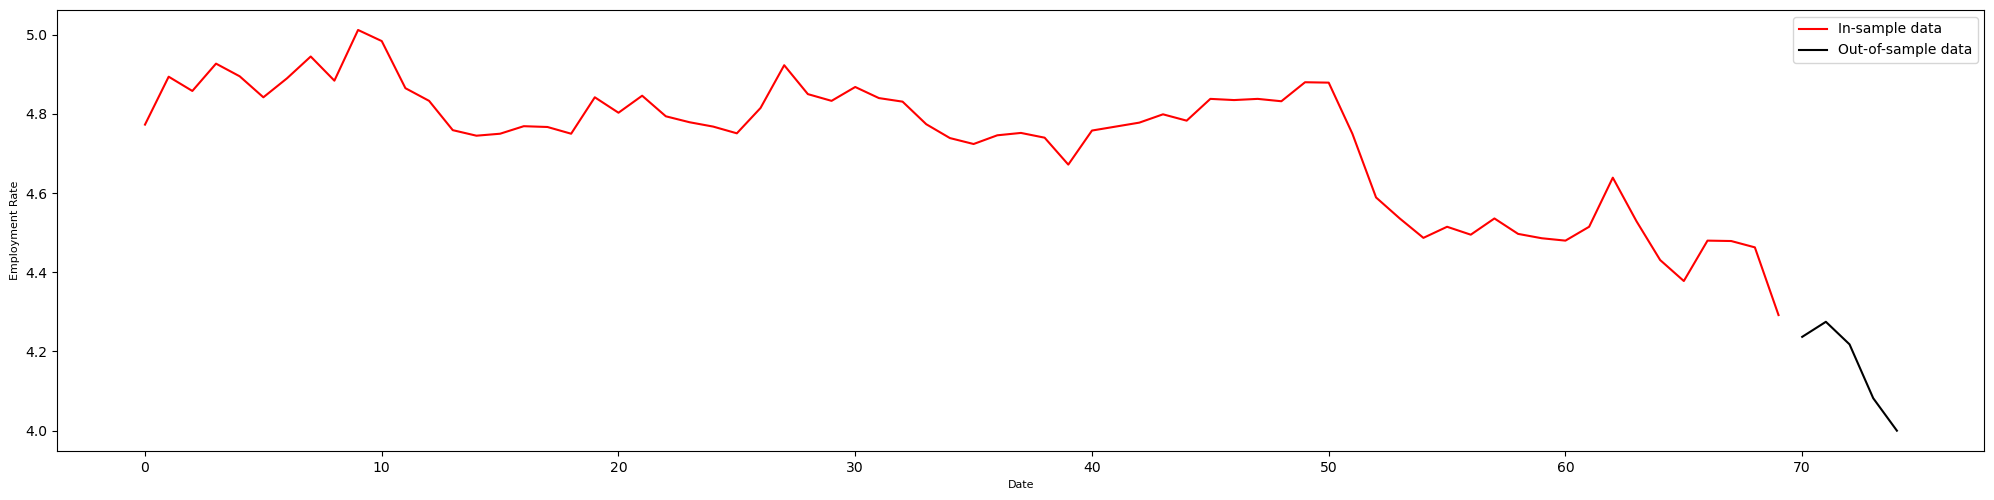

In [286]:

#unData=pd.read_csv("EDP.csv",sep=",",header=0,parse_dates=["Date"])

unTS=merged_data["Close_edp"]#pd.Series(data=np.array(merged_data["Close_x"]),index=my_list,name="Edp close price")

unTRTS=unTS[0:70]
unTRTS.name="In-sample data"

unTETS=unTS[70:75]
unTETS.name="Out-of-sample data"
print(unTSVal)



#Plot TS
fig, axs=plt.subplots(1,figsize=(20,5))
fig.tight_layout()
unTRTS.plot(ax=axs,legend=True,color='r')
unTETS.plot(ax=axs,legend=True,color='k')
axs.set_ylabel('Employment Rate',fontdict={'fontsize':8})
axs.set_xlabel('Date',fontdict={'fontsize':8})

Text(212.59722222222223, 0.5, 'Autocorrelation')

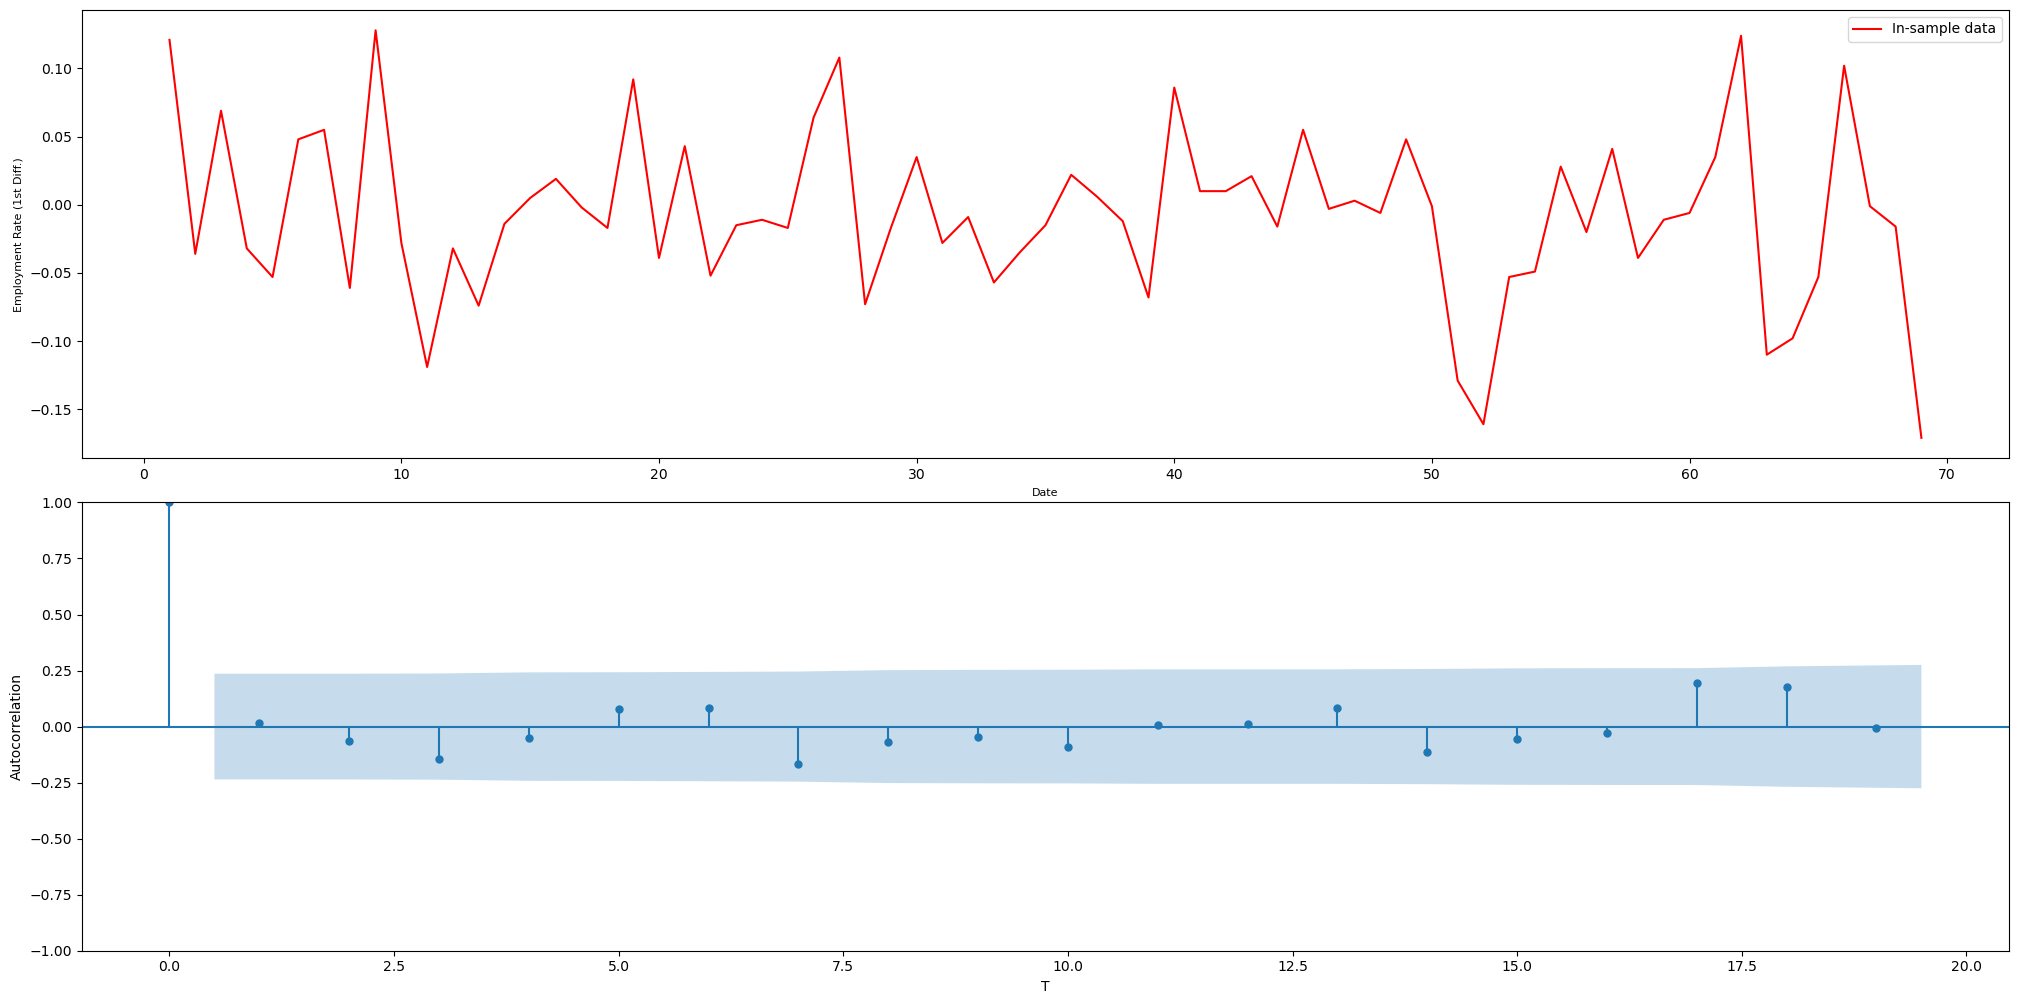

In [287]:
#Simple first-order differencing & remove NaN
unTSTraind1=unTRTS.diff().dropna()

#Plot differenced TS & its ACS
fig, axs=plt.subplots(2,figsize=(20,10))
fig.tight_layout()
unTSTraind1.plot(ax=axs[0],legend=True,color='r')
axs[0].set_ylabel('Employment Rate (1st Diff.)',fontdict={'fontsize':8})
axs[0].set_xlabel('Date',fontdict={'fontsize':8})
plot_acf(unTSTraind1,ax=axs[1],title="")
plt.xlabel("T")
plt.ylabel("Autocorrelation")


Text(212.59722222222223, 0.5, 'Partial Autocorrelation')

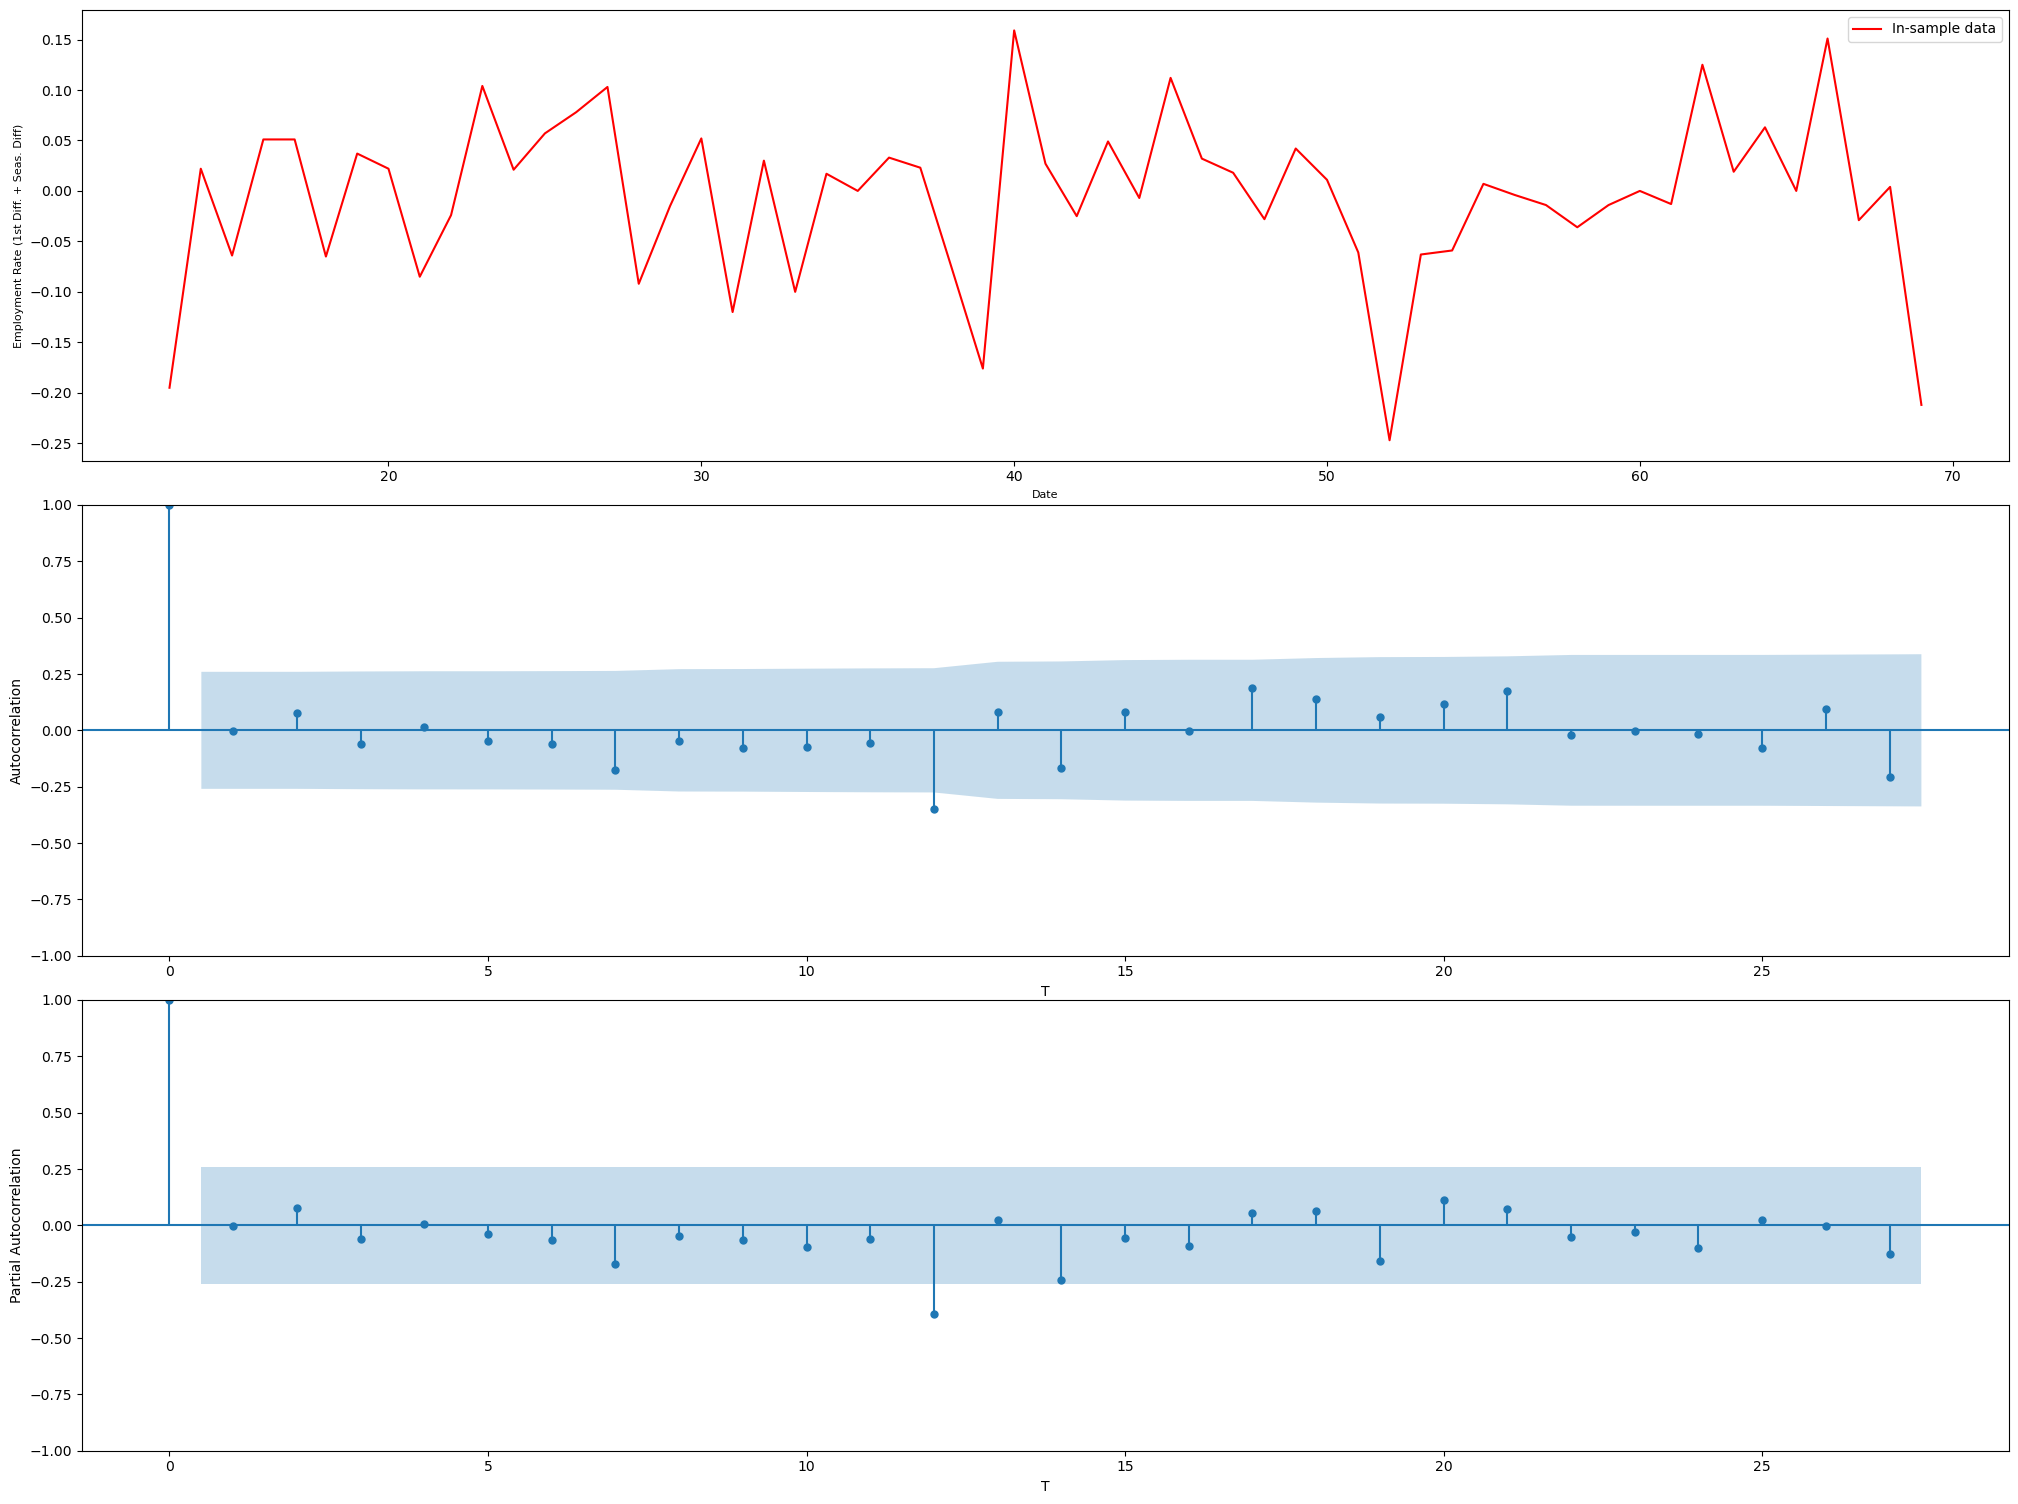

In [288]:
#Seasonal first-order differencing & remove NaN
unTSTraind1S12=unTSTraind1.diff(12).dropna()

#Plot differenced TS & its ACS and PACS
fig, axs=plt.subplots(3,figsize=(20,15))
fig.tight_layout()
unTSTraind1S12.plot(ax=axs[0],legend=True,color='r')
axs[0].set_ylabel('Employment Rate (1st Diff. + Seas. Diff)',fontdict={'fontsize':8})
axs[0].set_xlabel('Date',fontdict={'fontsize':8})
plot_acf(unTSTraind1S12,ax=axs[1],title="",lags=27)
axs[1].set_xlabel("T")
axs[1].set_ylabel("Autocorrelation")

plot_pacf(unTSTraind1S12,ax=axs[2],title="",lags=27)
axs[2].set_xlabel("T")
axs[2].set_ylabel("Partial Autocorrelation")


In [289]:
import statsmodels.tsa.stattools as st

#Perform ADF test to confirm stationarity
result=st.adfuller(unTSTraind1S12)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))



ADF Statistic: -7.313544
p-value: 0.000000
Critical Values:
	1%: -3.553
	5%: -2.915
	10%: -2.595


Text(212.59722222222223, 0.5, 'Partial Autocorrelation')

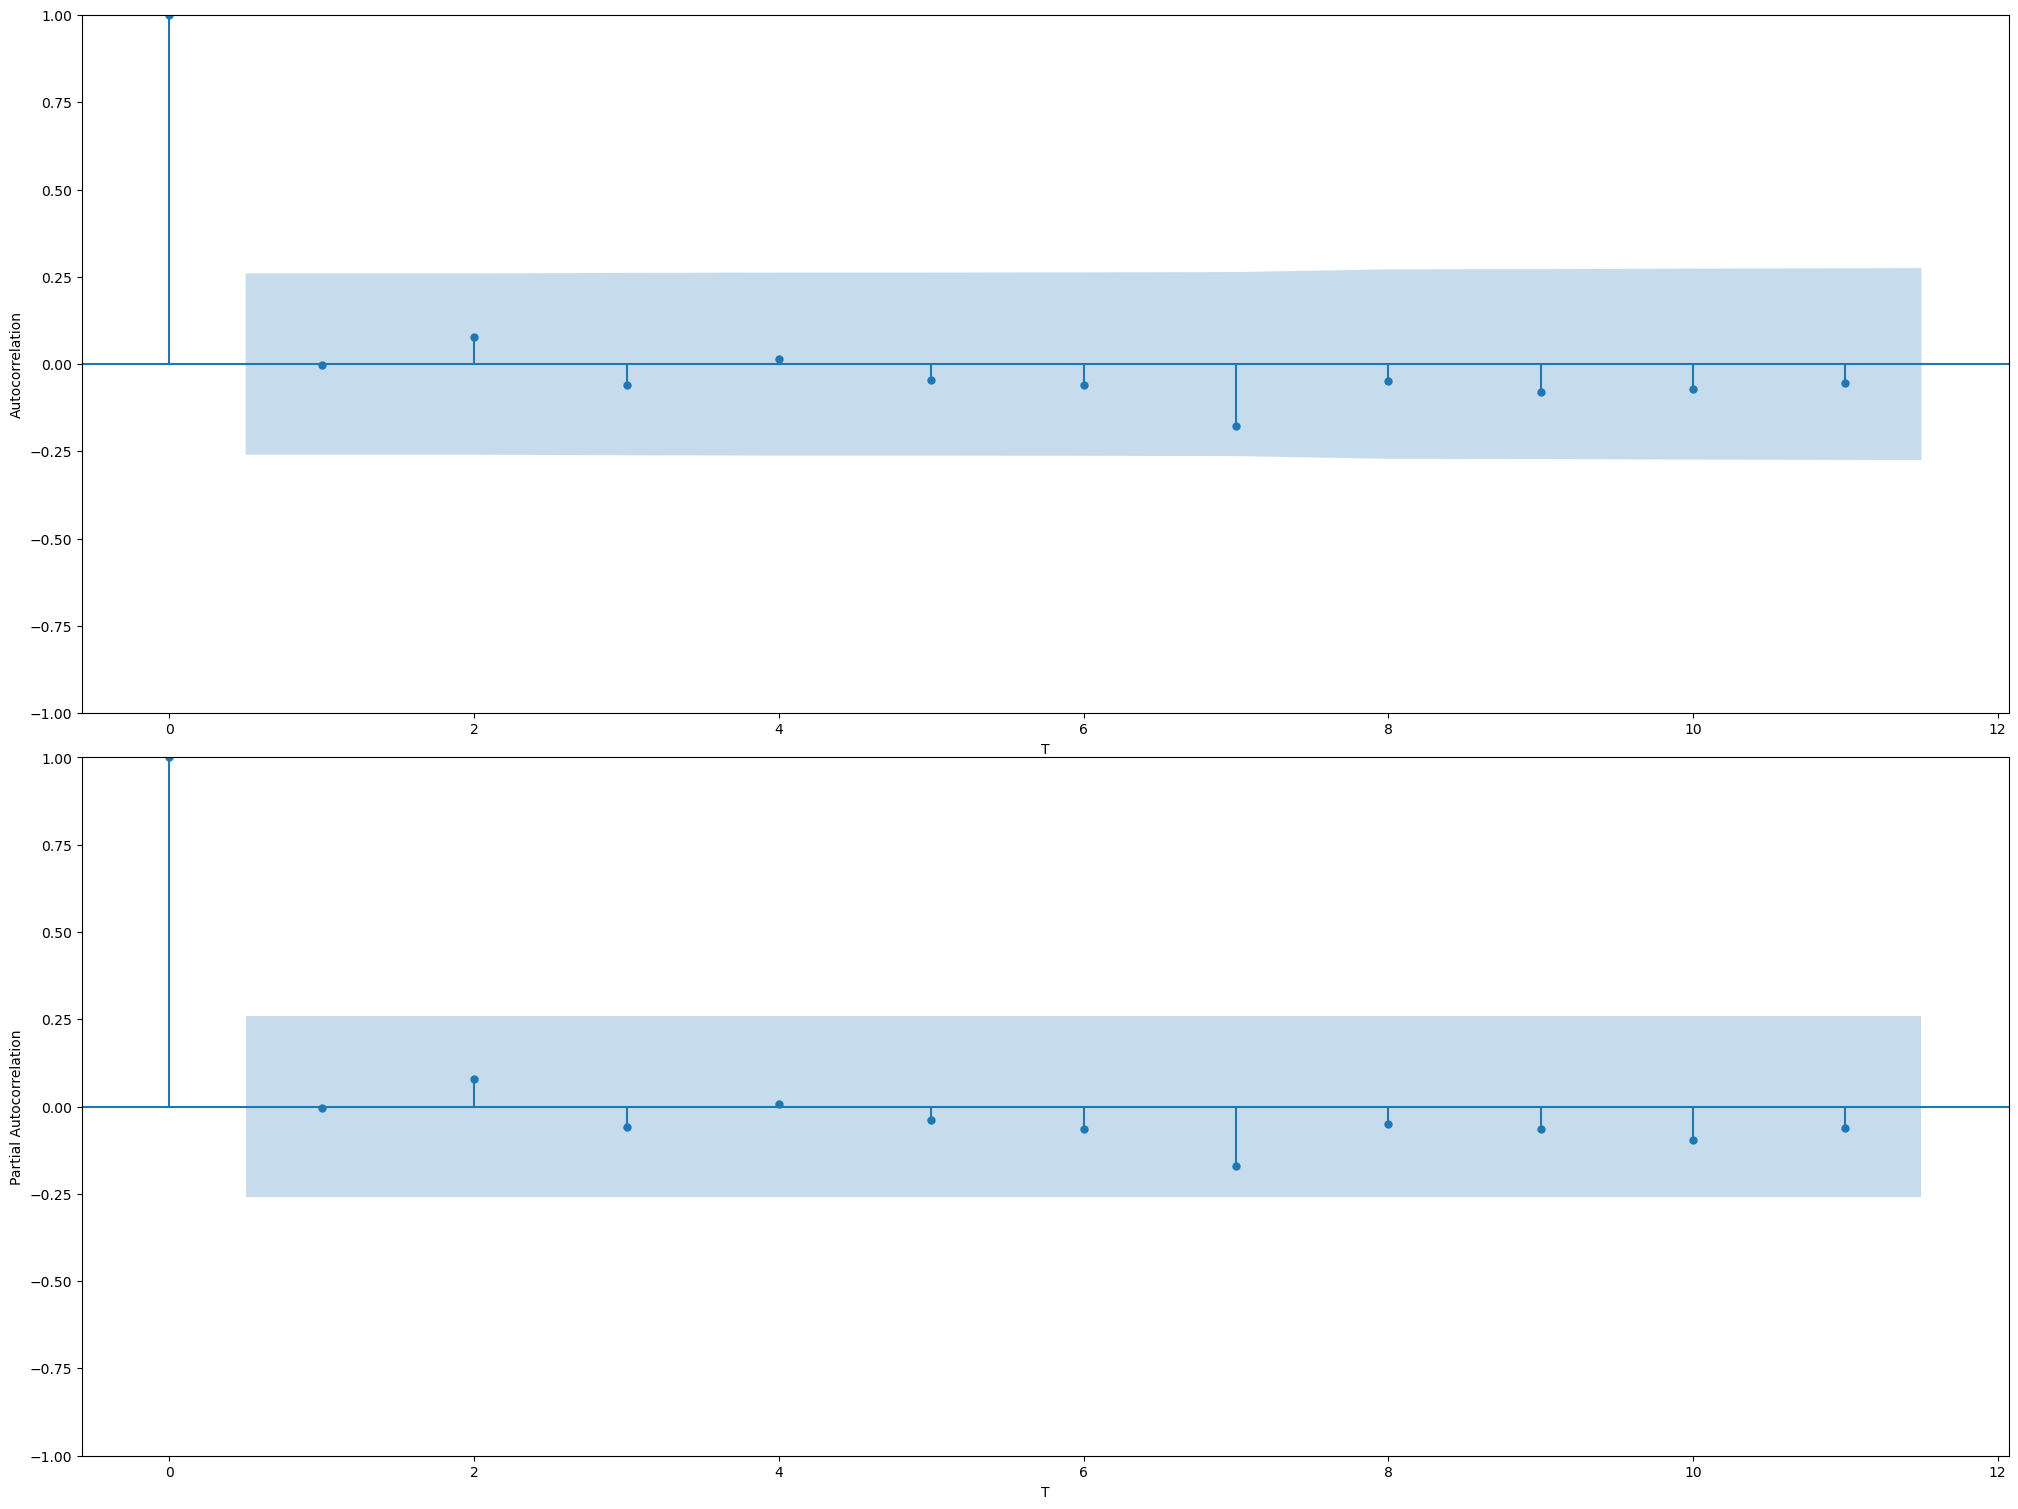

In [290]:
#Plot just the first 11 values of ACS and PACS to try to have a clue about p and q.

fig, axs=plt.subplots(2,figsize=(20,15))
fig.tight_layout()

plot_acf(unTSTraind1S12,ax=axs[0],title="",lags=11)
axs[0].set_xlabel("T")
axs[0].set_ylabel("Autocorrelation")

plot_pacf(unTSTraind1S12,ax=axs[1],title="",lags=11)
axs[1].set_xlabel("T")
axs[1].set_ylabel("Partial Autocorrelation")



<Axes: >

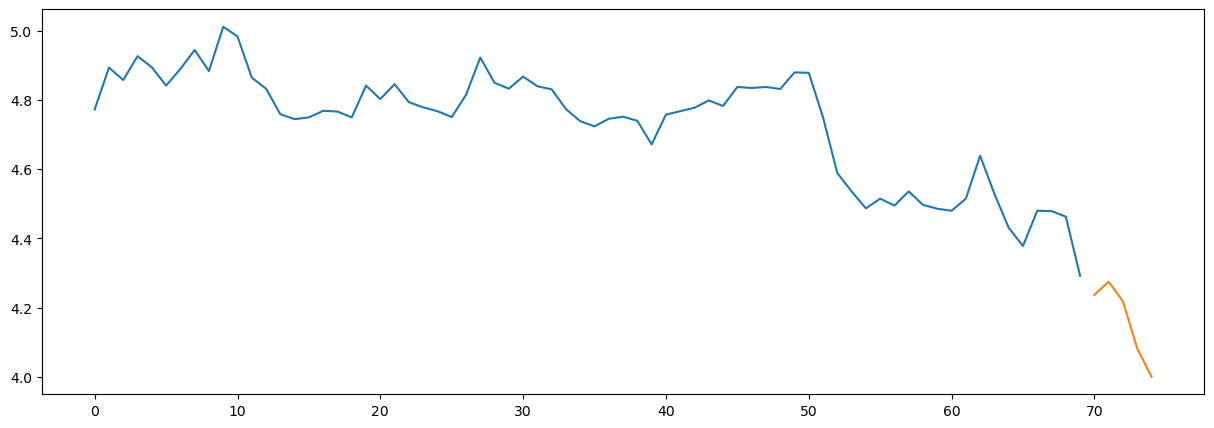

In [291]:
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.stattools import acf
import scipy.stats as spyst

plt.figure(figsize=(15,5))
unTRTS.plot()
unTETS.plot()

In [292]:
#Delay data to simulate external dynamics
#Delay just output and consider X(n-1), X(n-2), X(n-3), X(n-12), X(n-13), X(n-14), X(n-15)
delays=[1,2,5]
dataDelTR=genIOData(unTRTS,delayEndog=delays)
dataInpTR=dataDelTR.iloc[:,0:-1].to_numpy()
dataOutTR=dataDelTR.iloc[:,-1].to_numpy()
dataTRTS=pd.Series(data=dataOutTR,index=unTRTS.index[5:],name='Training Data')

#Testing data
unTEUTS=pd.Series(pd.concat((unTRTS.iloc[unTRTS.size-5:],unTETS)),name='test')
dataDelTE=genIOData(unTEUTS,delayEndog=delays)
dataInpTE=dataDelTE.iloc[:,0:-1].to_numpy()                     
                         
dataOutTE=dataDelTE.iloc[:,-1].to_numpy()
dataTETS=pd.Series(data=dataOutTE,index=unTEUTS.index[5:],name='Testing Data')

In [293]:
dataInpTE

array([[4.292, 4.463, 4.378],
       [4.237, 4.292, 4.48 ],
       [4.275, 4.237, 4.479],
       [4.218, 4.275, 4.463],
       [4.082, 4.218, 4.292]])

In [294]:
#Implement a MLP regressor
regr = MLPRegressor(random_state=1, max_iter=5000,early_stopping=True,
                    hidden_layer_sizes=(50,500,)).fit(dataInpTR, dataOutTR)

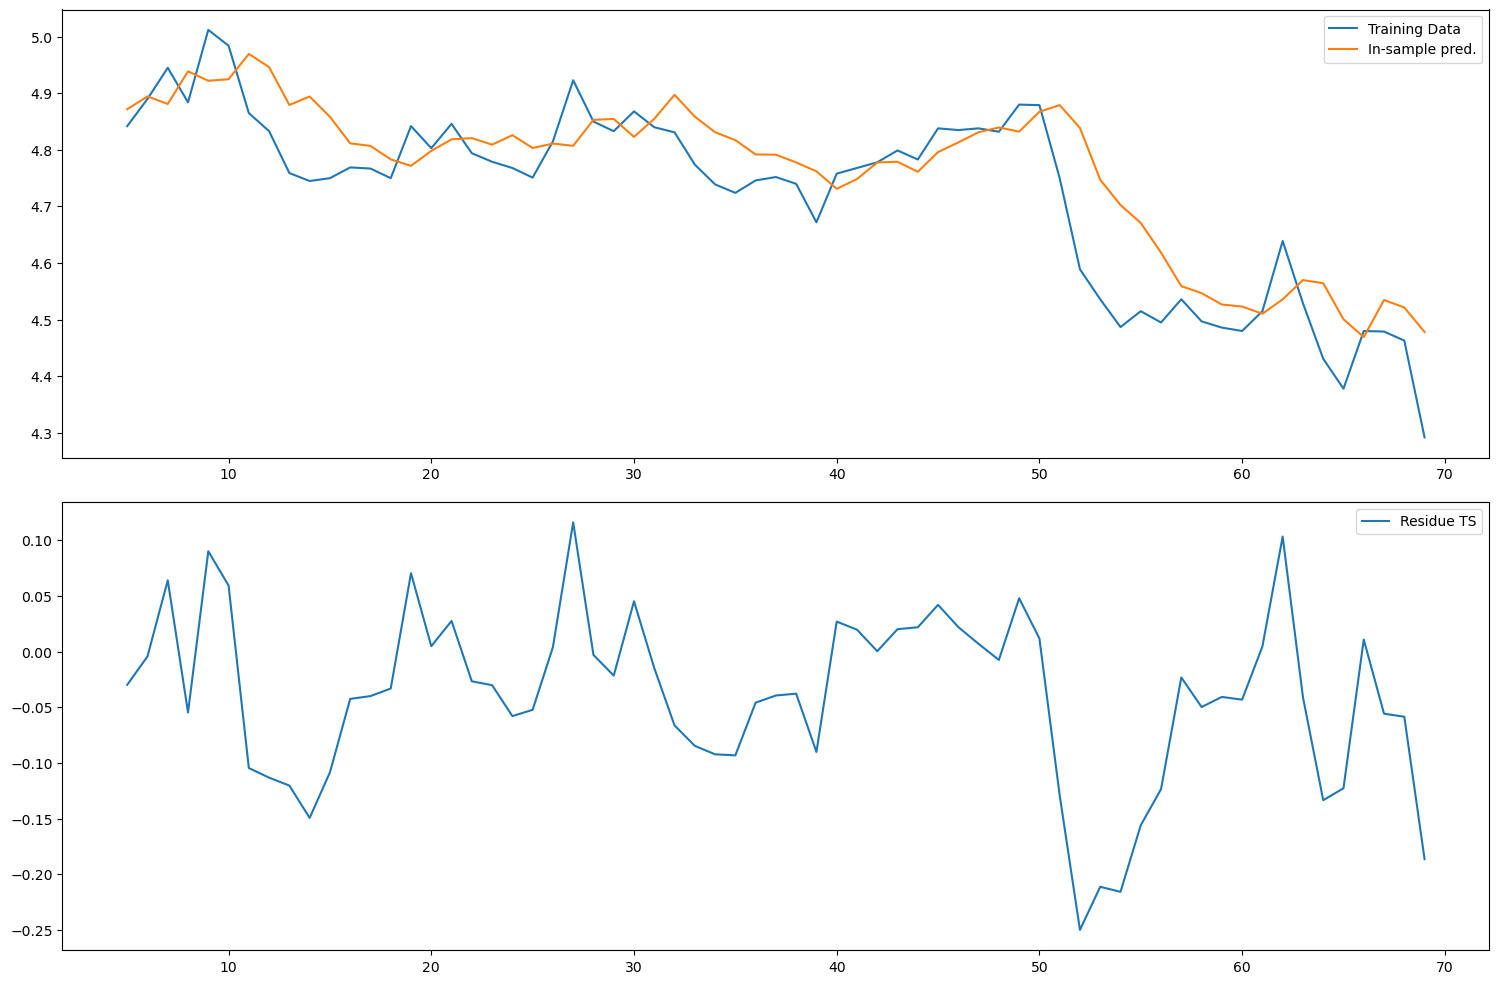

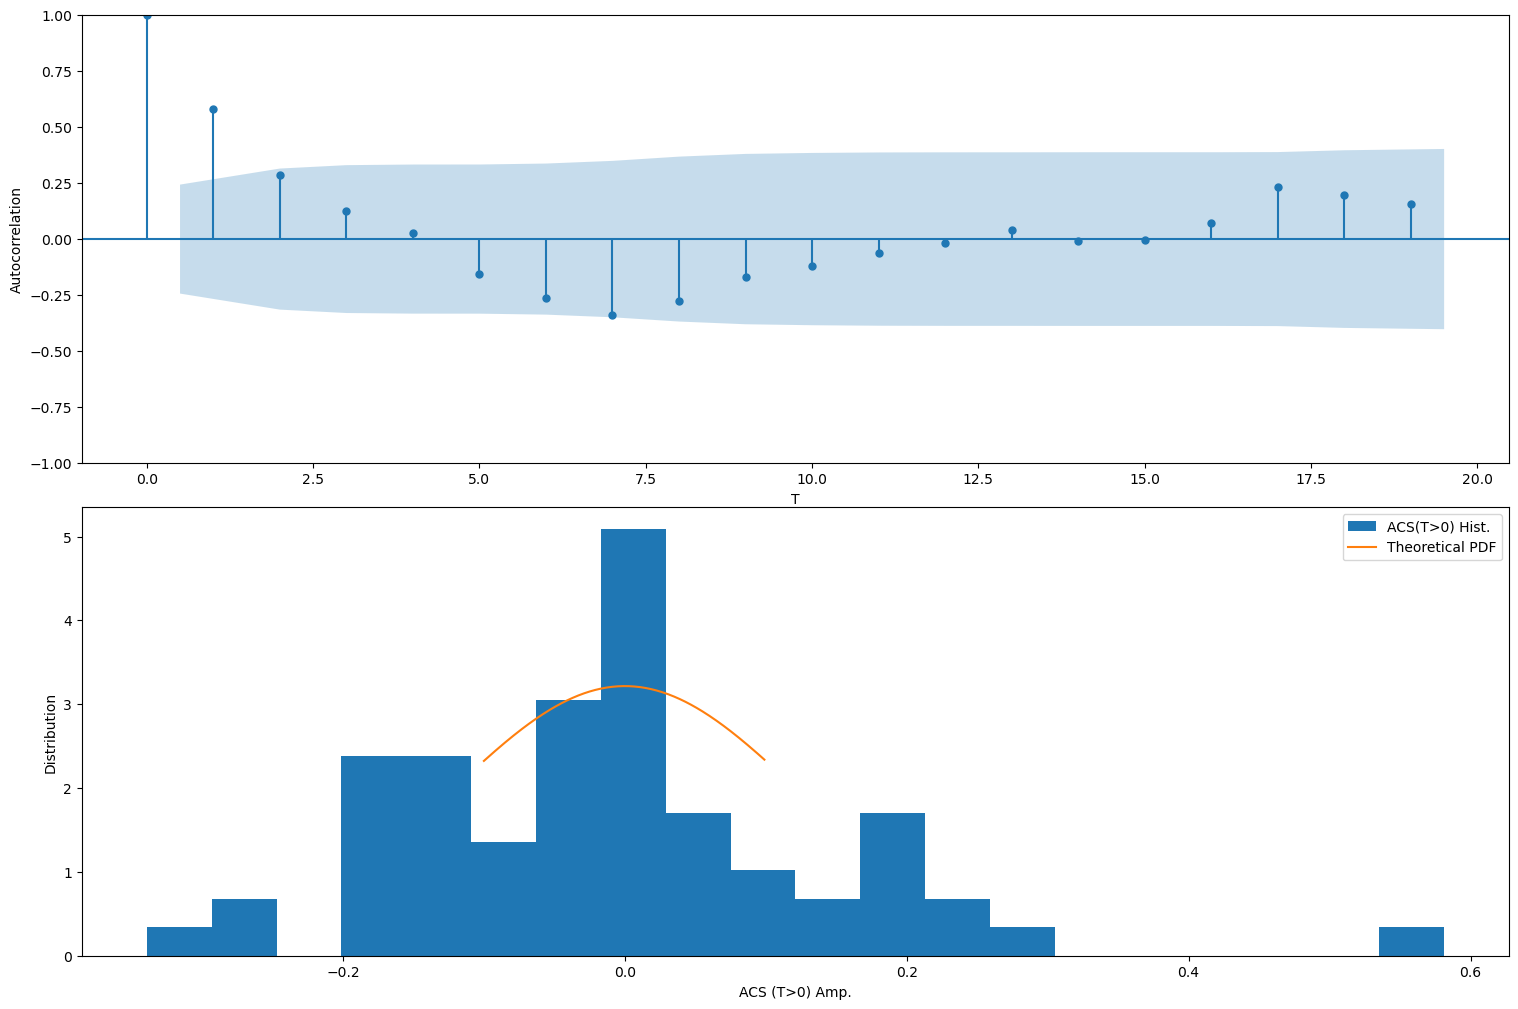

In [295]:
#Evaluate residuals
predictTRTS=pd.Series(data=regr.predict(dataInpTR),index=dataTRTS.index,
                      name='In-sample pred.')
resTS=dataTRTS-predictTRTS
resTS.name='Residue TS'

fig, axs=plt.subplots(2,figsize=(15,10))
fig.tight_layout()
dataTRTS.plot(ax=axs[0],legend=True)
predictTRTS.plot(ax=axs[0],legend=True)
resTS.plot(ax=axs[1],legend=True)

#Evaluate fitting quality by inspecting residuals at two levels: ACS and ACS
#distribution
fig, axs=plt.subplots(2,figsize=(15,10))
fig.tight_layout()
plot_acf(resTS,ax=axs[0],title="")
axs[0].set_xlabel("T")
axs[0].set_ylabel("Autocorrelation")

ac=acf(resTS,nlags=500,fft=False)

axs[1].hist(ac[1:],bins=20,density=True,label='ACS(T>0) Hist.')

N=resTS.size
rg=np.arange(-0.1,0.1,0.001)
pdf = spyst.norm.pdf(rg,0,1/np.sqrt(N))
plt.plot(rg,pdf,label='Theoretical PDF')
plt.xlabel("ACS (T>0) Amp.")
plt.ylabel("Distribution")
plt.legend()


Forecast RMSE=0.19090776653973618


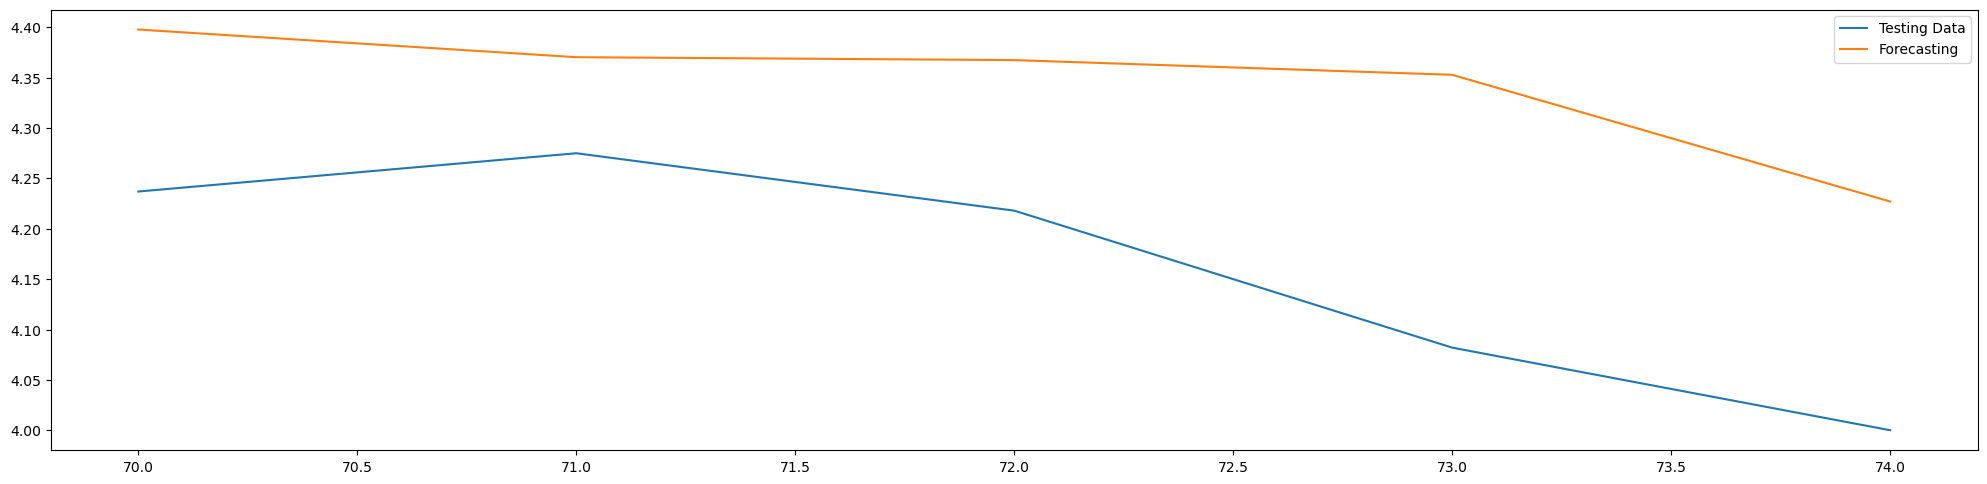

In [296]:
#Plot forecasting in testing (One-step-ahead)
forecastTETS=pd.Series(data=regr.predict(dataInpTE),
                       index=dataTETS.index,name='Forecasting')
fig, axs=plt.subplots(1,figsize=(20,5))
fig.tight_layout()
#dataTRTS.plot(legend=True)
dataTETS.plot(ax=axs,legend=True)
forecastTETS.plot(ax=axs,legend=True)

print("Forecast RMSE="+str(np.sqrt(np.sum((dataTETS-forecastTETS)**2)/forecastTETS.size)))

Forecast RMSE=0.29662862644581506


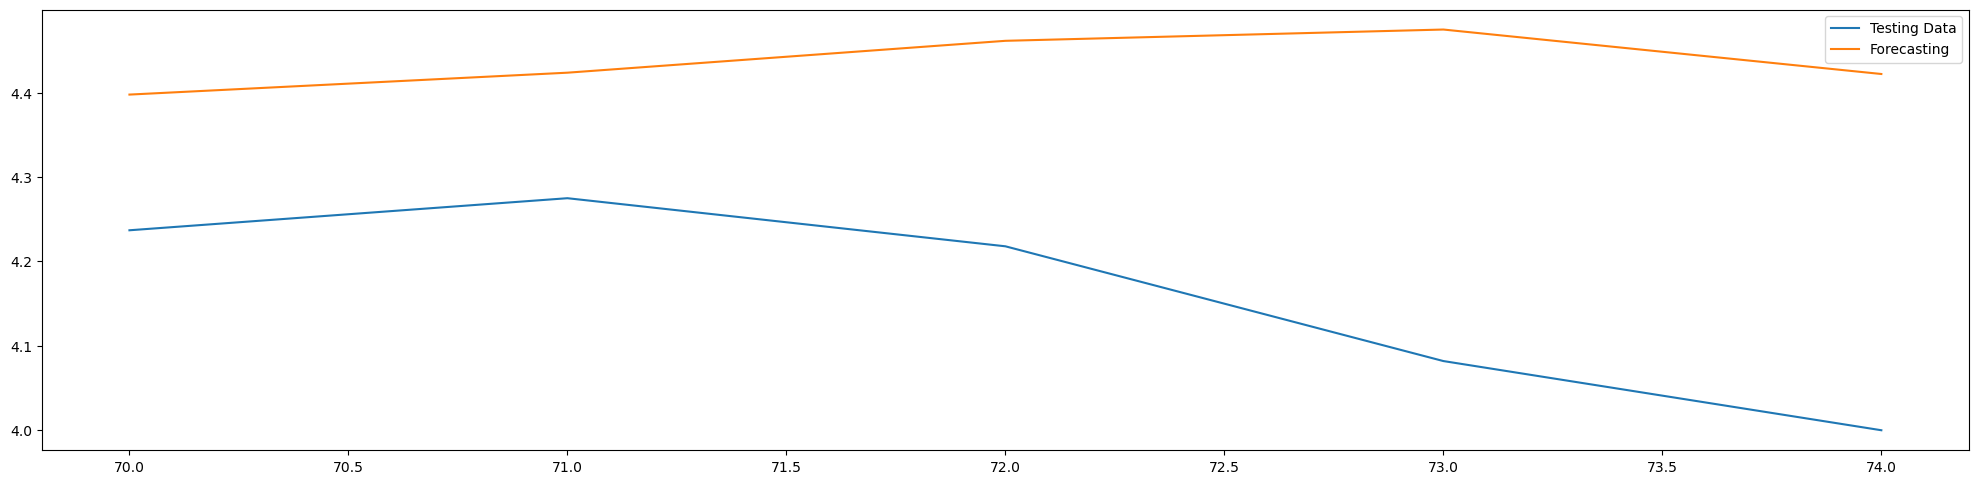

In [297]:
#Plot forecasting in testing (several steps ahead)

hStepFor=np.zeros((len(dataOutTE),1))
startTE=dataTRTS.copy()
startTE=startTE.iloc[dataTRTS.size-15:]
buffer=np.flip(startTE.to_numpy())
for i in range(len(dataOutTE)):
    psample=buffer[(np.array(delays)-1)]
    hStepFor[i,0]=regr.predict(psample.reshape(1, -1))
    buffer[1:]=buffer[0:-1]
    buffer[0]=hStepFor[i,0]
    
forecastHSTS=pd.Series(data=hStepFor[:,0],index=dataTETS.index,name='Forecasting')
fig, axs=plt.subplots(1,figsize=(20,5))
fig.tight_layout()
dataTETS.plot(ax=axs,legend=True)
forecastHSTS.plot(ax=axs,legend=True)
print("Forecast RMSE="+str(np.sqrt(np.sum((dataTETS-forecastHSTS)**2)/forecastHSTS.size)))

    Valdiação de MLP com so o Close_edp com several steps ahead

In [308]:
list_RMSE = []
unTS=merged_data
list_MAFE = []
list_U2 = []
# Assuming regr is your trained MLPRegressor
for i in range(0, len(unTS)-75):

    lisDataTR=merged_data[0+i:70+i]
    lisDataTE=merged_data[70+i:75+i]

    lisDataTRnorm = pd.DataFrame(data=scaler.transform(lisDataTR),index=lisDataTR["time_int"],columns=lisDataTR.columns)
    lisDataTEnorm = pd.DataFrame(data=scaler.transform(lisDataTE),index=lisDataTE["time_int"],columns=lisDataTE.columns)

    dataTR=lisDataTRnorm.copy()
    dataTR=dataTR[['Close_edp','Close_crude']]

    #Testing data
    dataTE=lisDataTEnorm.copy()
    dataTE=dataTE[['Close_edp','Close_crude']]
    
    dataTEU=pd.DataFrame(pd.concat((dataVL.iloc[dataVL.shape[0]-maxdel:],dataTE)),columns=dataTE.columns)
    dataDelTE=genIOData(outData=dataTEU['Close_edp'],inData=dataTEU['Close_crude'],delayEndog=d[1],delayExog=d[0])

    dataInpTE=dataDelTE.iloc[:,0:-1].to_numpy()
    dataOutTE=dataDelTE.iloc[:,-1].to_numpy()

    dataTETS=pd.Series(data=dataOutTE,index=dataDelTE.index,name='Testing Measured')

    forecastTETS=pd.Series(data=models[ix].predict(dataInpTE),index=dataTETS.index,name='Testing Forecasting')
    #print("Forecast RMSE="+str(np.sqrt(np.sum((dataTETS-forecastTETS)**2)/forecastTETS.size)))

    RMSE = np.sqrt(np.sum((dataTETS-forecastTETS)**2)/forecastTETS.size)
    print("Forecast RMSE="+str(RMSE))

    MAFE = np.mean(np.abs((dataTETS - forecastTETS) / dataTETS))
    print("Forecast MAFE="+str(MAFE))

    U2 = np.sqrt(np.sum((dataTETS - forecastTETS)**2) / np.sum((dataTETS - np.mean(dataTETS))**2))
    print("Forecast U2="+str(U2))

    list_RMSE.append(RMSE)
    list_MAFE.append(MAFE)
    list_U2.append(U2)

print("Em média o RMSE deste modelo é: ",statistics.mean(list_RMSE))
print("Em média o MAFE deste modelo é: ",statistics.mean(list_MAFE))
print("Em média o U2 deste modelo é: ",statistics.mean(list_U2))

/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/tensorflow-tes

Forecast RMSE=0.7473035679996313
Forecast MAFE=0.17796268839189752
Forecast U2=1.1458834308634878
Forecast RMSE=0.8456724230441092
Forecast MAFE=0.22394578808067286
Forecast U2=1.3448245169848412
Forecast RMSE=1.1790348034181501
Forecast MAFE=0.26870021563583607
Forecast U2=2.660822027866075
Forecast RMSE=1.4687128061496957
Forecast MAFE=0.31103553609926304
Forecast U2=3.856488502372588
Forecast RMSE=1.5040604364753682
Forecast MAFE=0.2839343599298514
Forecast U2=2.9605652757699383
Forecast RMSE=1.3127487372379936
Forecast MAFE=0.24830226888032764
Forecast U2=1.7755851146348451
Forecast RMSE=1.3758739997198948
Forecast MAFE=0.29171195149838336
Forecast U2=1.5599471949485346
Forecast RMSE=1.657183651664722
Forecast MAFE=0.3288154309764689
Forecast U2=1.921678979186553
Forecast RMSE=1.9599035259888196
Forecast MAFE=0.33396854900878503
Forecast U2=3.8787076079170615
Forecast RMSE=2.2319051764686315
Forecast MAFE=0.3999527831974719
Forecast U2=2.439757255813243
Forecast RMSE=2.190104023075

/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/tensorflow-tes

## Multivariavel

### EDP + CRUDE

<Axes: xlabel='time_int'>

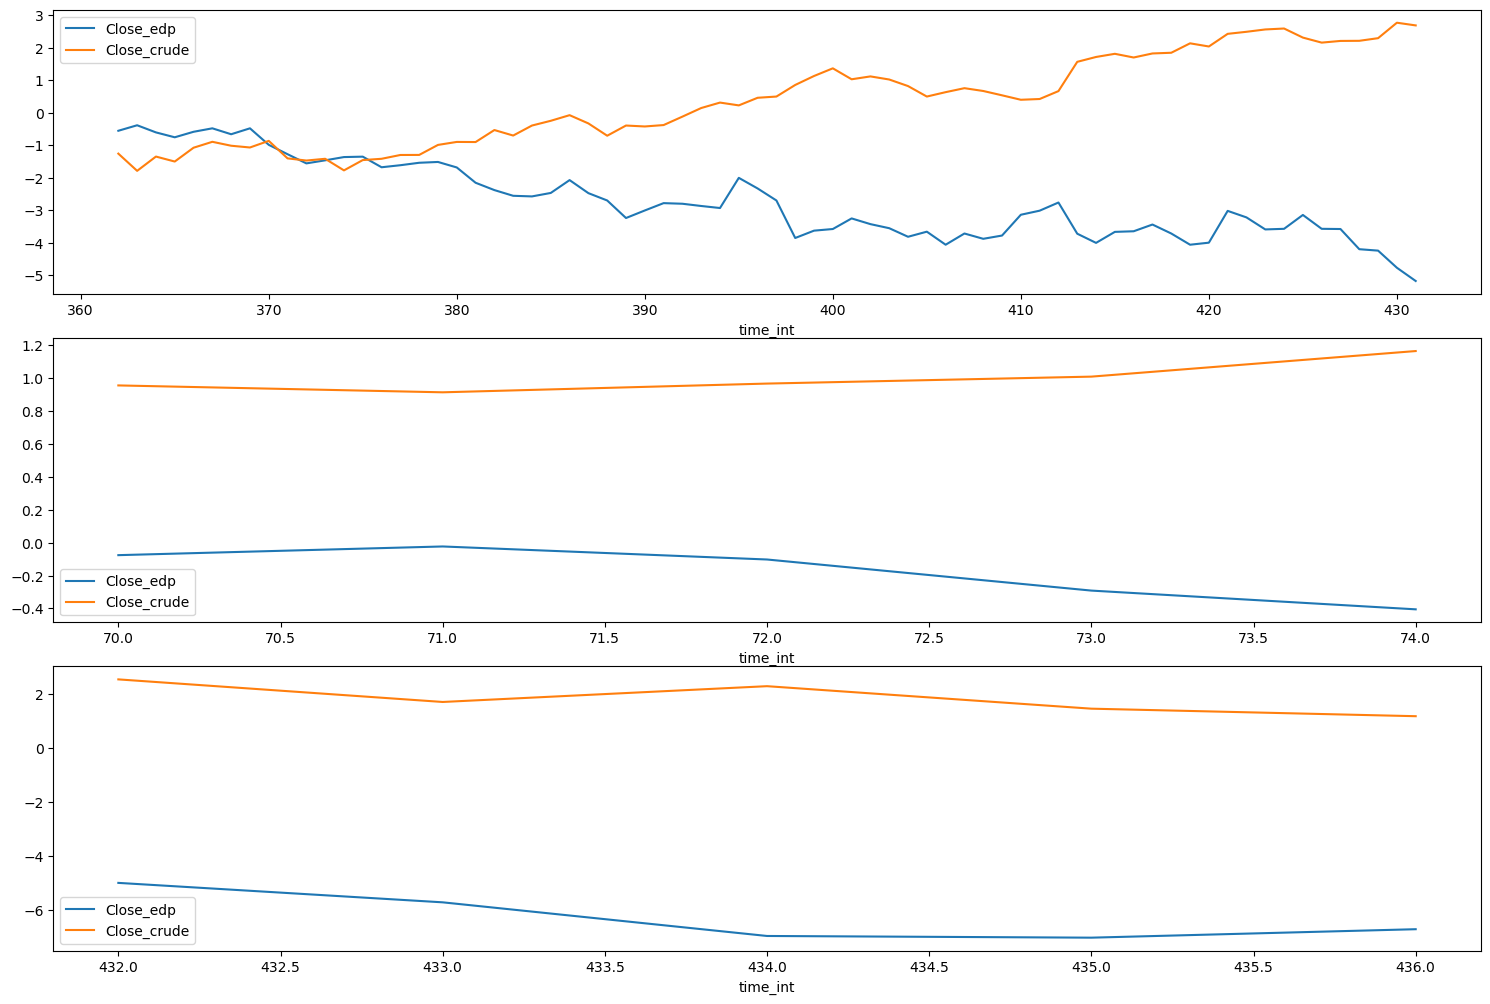

In [309]:
#Training data
dataTR=lisDataTRnorm.copy()
dataTR=dataTR[['Close_edp','Close_crude']]

#Validation data
dataVL=lisDataVLnorm.copy()
dataVL=dataVL[['Close_edp','Close_crude']]

#Testing data
dataTE=lisDataTEnorm.copy()
dataTE=dataTE[['Close_edp','Close_crude']]


fig, axs=plt.subplots(3,figsize=(15,10))
fig.tight_layout()
dataTR.plot(ax=axs[0],legend=True)
dataVL.plot(ax=axs[1],legend=True)
dataTE.plot(ax=axs[2],legend=True)

Minimum RMSE is :9.980729014531724
Best Delay Combination:[[[2, 3]], [1, 2]]


<Axes: xlabel='time_int'>

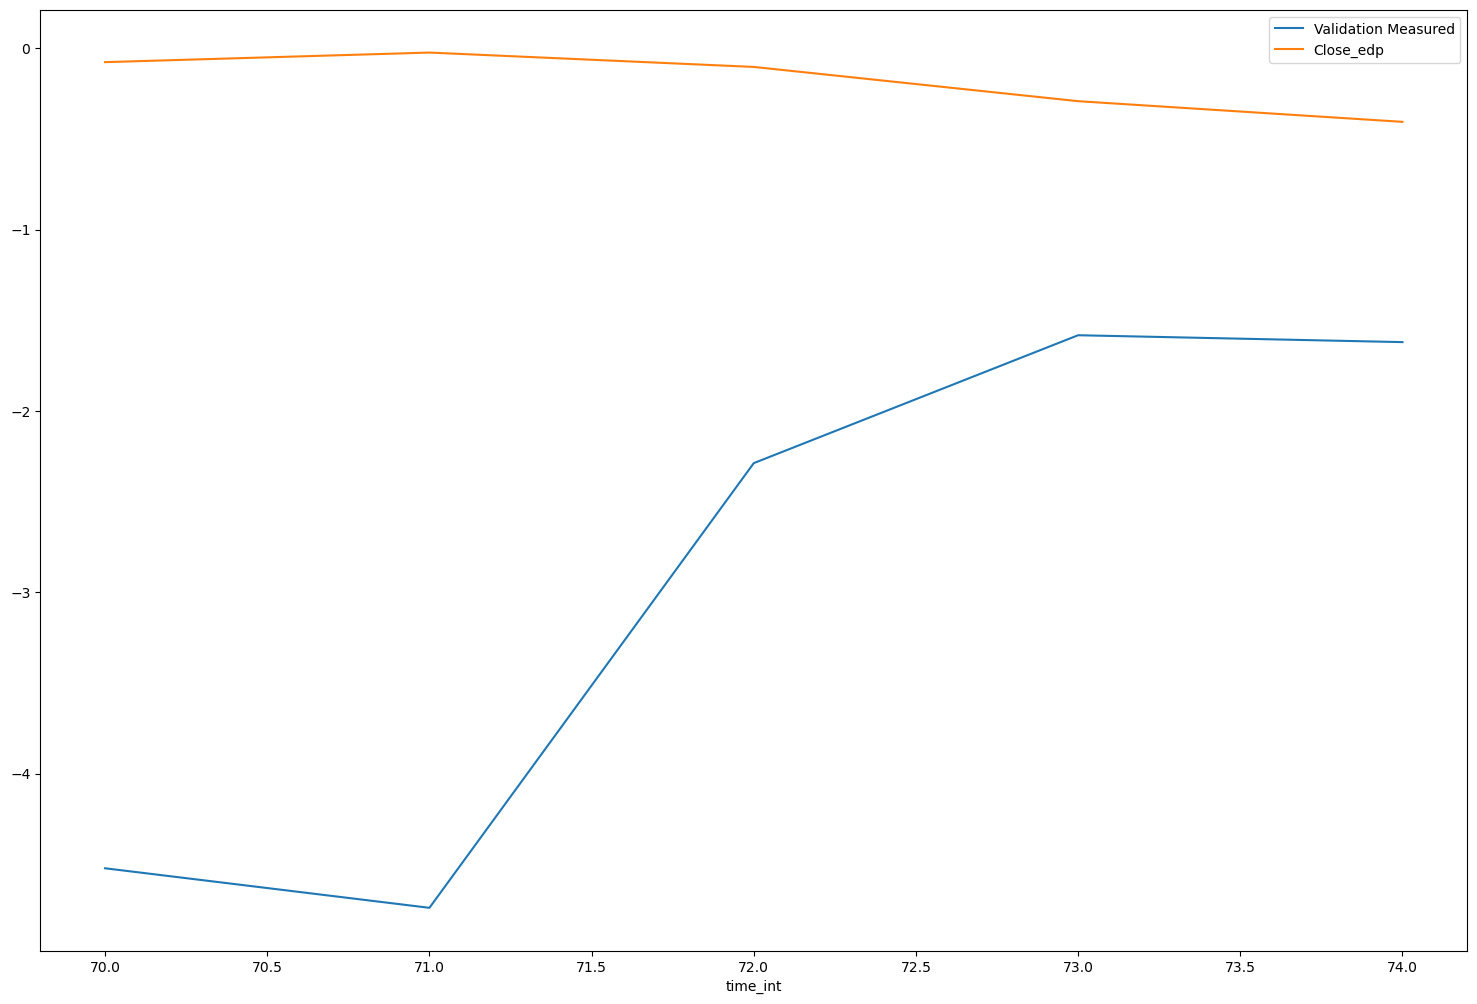

In [310]:
#Test several delay combinations
delays=[[[[1,5]],[1,2]],
        [[[1,5]],[1,3]],
        [[[1,3]],[1,5]],
        [[[2,3]],[1,2]],
        [[[2,3]],[2,3]],
        [[[2,3]],[4,5]],
        [[[4,5]],[4,5]],
        [[[1,2,5]],[1,2,5]],
        [[[1,2,5]],[1,2,5]],
        [[[1,2,5]],[1,2,5]],
        [[[1,2,3,4,5]],[1,2,3,4,5]],]

predicts=[]
rmses=[]
models=[]
for d in delays:
    maxdel=np.amax([np.amax(d[0]),np.amax(d[1])])#Get maximum delay for proper indexing
    #Generate input/output data
    dataDelTR=genIOData(outData=dataTR['Close_edp'],inData=dataTR['Close_crude'],delayEndog=d[1],delayExog=d[0])
    dataInpTR=dataDelTR.iloc[:,0:-1].to_numpy()
    dataOutTR=dataDelTR.iloc[:,-1].to_numpy()
    dataTRTS=pd.Series(data=dataOutTR,index=outData.index[maxdel:],name='Training Data')
    
    #Validation data
    dataVLU=pd.DataFrame(pd.concat((dataTR.iloc[dataTR.shape[0]-maxdel:],dataVL)),columns=dataVL.columns)
    dataDelVL=genIOData(outData=dataVLU['Close_edp'],inData=dataVLU['Close_crude'],delayEndog=d[1],delayExog=d[0])
    dataInpVL=dataDelVL.iloc[:,0:-1].to_numpy()
    dataOutVL=dataDelVL.iloc[:,-1].to_numpy()
    dataVLTS=pd.Series(data=dataOutVL,index=dataDelVL.index,name='Val Data')
    
    
    #Implement a MLP regressor
    regr = MLPRegressor(random_state=1, max_iter=5000,early_stopping=True,
                        hidden_layer_sizes=(10,)).fit(dataInpTR, dataOutTR)
    models.append(regr)
    #Evaluate Validation forecasting and error
    predictVLTS=pd.Series(data=regr.predict(dataInpVL),index=dataVLTS.index,name='Validation Measured')
    predicts.append(predictVLTS)
    resTS=dataVLTS-predictVLTS
    resTS.name='Validation Forecasting'                       
    rmses.append((np.sum((resTS.to_numpy())**2))/resTS.size)
    
ix=np.where(rmses==np.min(rmses))[0][0]
print('Minimum RMSE is :'+str(rmses[ix]))
print('Best Delay Combination:'+str(delays[ix]))
#Lets plot best Val error
fig, axs=plt.subplots(1,figsize=(15,10))
fig.tight_layout()
predicts[ix].plot(ax=axs,legend=True)
dataVL['Close_edp'].plot(ax=axs,legend=True)


In [311]:
#Testing performance
#Testing data preparation
d=delays[ix]
maxdel=np.amax([np.amax(d[0]),np.amax(d[1])])#Get maximum delay for proper indexing
dataTEU=pd.DataFrame(pd.concat((dataVL.iloc[dataVL.shape[0]-maxdel:],dataTE)),columns=dataTE.columns)
dataDelTE=genIOData(outData=dataTEU['Close_edp'],inData=dataTEU['Close_crude'],delayEndog=d[1],delayExog=d[0])
dataDelTE

Close_crude_lag2  Close_crude_lag3  Close_edp_lag1  Close_edp_lag2  \
time_int                                                                       
432               1.008218          0.966007       -0.405556       -0.291667   
433               1.163616          1.008218       -5.001317       -0.405556   
434               2.538899          1.163616       -5.721839       -5.001317   
435               1.702065          2.538899       -6.968656       -5.721839   
436               2.286949          1.702065       -7.031310       -6.968656   

          Close_edp  
time_int             
432       -5.001317  
433       -5.721839  
434       -6.968656  
435       -7.031310  
436       -6.718039

In [312]:
dataInpTE=dataDelTE.iloc[:,0:-1].to_numpy()
dataOutTE=dataDelTE.iloc[:,-1].to_numpy()
dataOutTE

array([-5.00131737, -5.72183931, -6.96865555, -7.03130963, -6.71803922])

In [313]:
dataTETS=pd.Series(data=dataOutTE,index=dataDelTE.index,name='Testing Measured')
dataTETS

time_int
432   -5.001317
433   -5.721839
434   -6.968656
435   -7.031310
436   -6.718039
Name: Testing Measured, dtype: float64

Forecast RMSE=2.426286696560756


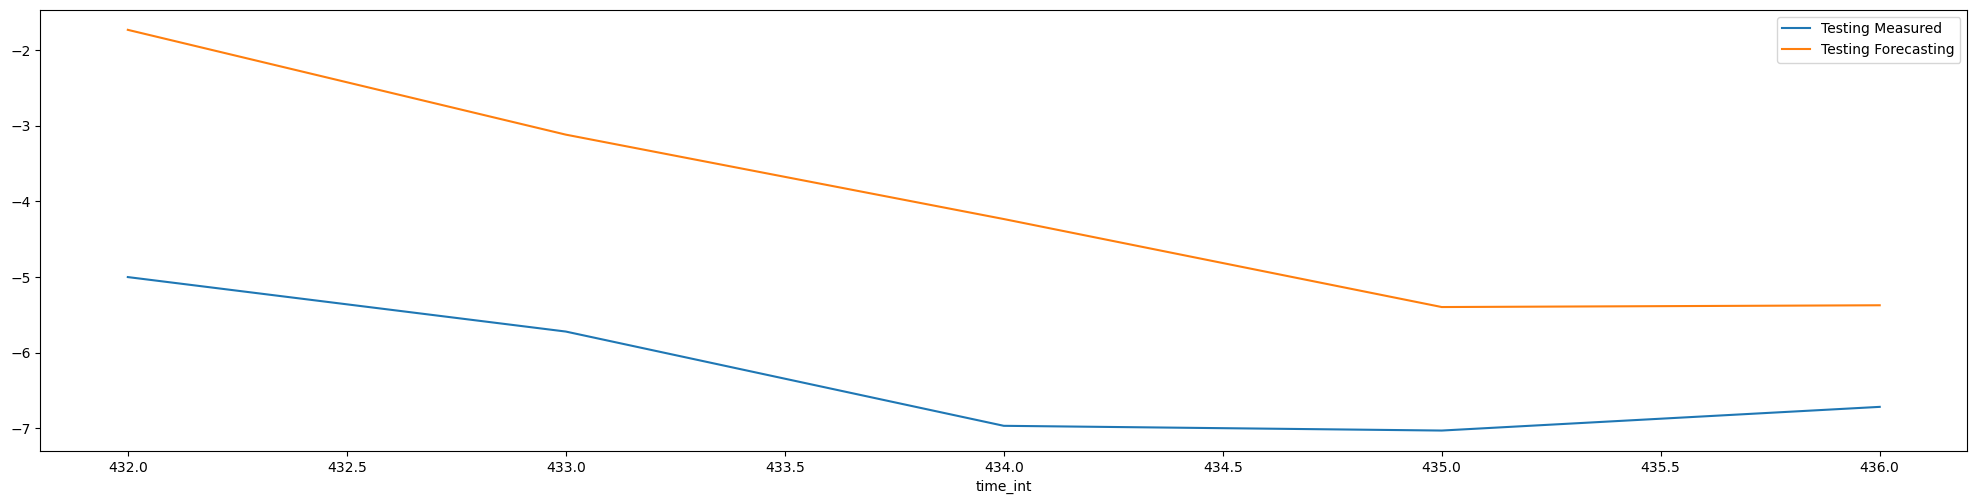

In [314]:
#Plot forecasting in testing
forecastTETS=pd.Series(data=models[ix].predict(dataInpTE),index=dataTETS.index,name='Testing Forecasting')
fig, axs=plt.subplots(1,figsize=(20,5))
fig.tight_layout()
#dataTRTS.plot(legend=True)
dataTETS.plot(ax=axs,legend=True)
forecastTETS.plot(ax=axs,legend=True)

print("Forecast RMSE="+str(np.sqrt(np.sum((dataTETS-forecastTETS)**2)/forecastTETS.size)))

    Valdiação de MLP com Crude e Close_Edp

In [315]:
unTS

Close_edp  Close_crude  time_int  Close_edpr
0        4.773        85.02         0      22.280
1        4.894        85.76         1      23.020
2        4.858        84.58         2      23.420
3        4.927        85.43         3      23.840
4        4.895        84.85         4      23.780
..         ...          ...       ...         ...
433      3.821        91.21       433      15.100
434      3.622        94.46       434      13.885
435      3.612        89.83       435      13.980
436      3.662        88.28       436      14.240
437      3.636        87.86       437      14.220

[438 rows x 4 columns]

In [316]:
merged_data = merged_data.drop("Date", axis=1)

KeyError: "['Date'] not found in axis"

In [317]:
import statistics
import numpy as np

# Assuming unTS is your time series data
unTS = merged_data["Close_edp"]

list_RMSE = []
list_MAFE = []
list_U2 = []

# Assuming regr is your trained MLPRegressor
for i in range(0, len(unTS)-75):

    # Split the data into training and testing sets
    lisDataTR=merged_data[0+i:70+i]
    lisDataTE=merged_data[70+i:75+i]

    lisDataTRnorm = pd.DataFrame(data=scaler.transform(lisDataTR),index=lisDataTR["time_int"],columns=lisDataTR.columns)
    lisDataTEnorm = pd.DataFrame(data=scaler.transform(lisDataTE),index=lisDataTE["time_int"],columns=lisDataTE.columns)

    dataTR=lisDataTRnorm.copy()
    dataTR=dataTR[['Close_edp','Close_crude']]

    #Testing data
    dataTE=lisDataTEnorm.copy()
    dataTE=dataTE[['Close_edp','Close_crude']]
    
    dataTEU=pd.DataFrame(pd.concat((dataVL.iloc[dataVL.shape[0]-maxdel:],dataTE)),columns=dataTE.columns)
    dataDelTE=genIOData(outData=dataTEU['Close_edp'],inData=dataTEU['Close_crude'],delayEndog=d[1],delayExog=d[0])

    dataInpTE=dataDelTE.iloc[:,0:-1].to_numpy()
    dataOutTE=dataDelTE.iloc[:,-1].to_numpy()

    dataTETS=pd.Series(data=dataOutTE,index=dataDelTE.index,name='Testing Measured')

    # Forecasting on the training data
    forecastTRTS = []
    X_new = dataInpTR[-1].reshape(1, -1)  # Start with the last point in the training data
    for _ in range(5):  # Predict 5 steps ahead
        prediction = regr.predict(X_new)
        forecastTRTS.append(prediction)
        X_new = np.roll(X_new, -1)  # Shift the data
        X_new[-1] = prediction  # Append the prediction

    forecastTRTS=pd.Series(data=forecastTRTS, index=dataTETS.index[:5], name='Forecasting')

    # Calculate error metrics using the test data
    RMSE = np.sqrt(np.sum((dataTETS[:5]-forecastTRTS)**2)/forecastTRTS.size)[0]
    print("Forecast RMSE="+str(RMSE))

    MAFE = np.mean(np.abs((dataTETS[:5] - forecastTRTS) / dataTETS[:5]))[0]
    print("Forecast MAFE="+str(MAFE))

    U2 = np.sqrt(np.sum((dataTETS[:5] - forecastTRTS)**2) / np.sum((dataTETS[:5] - np.mean(dataTETS[:5]))**2))[0]
    print("Forecast U2="+str(U2))

    # Append error metrics to lists
    list_RMSE.append(RMSE)
    list_MAFE.append(MAFE)
    list_U2.append(U2)

# Print average error metrics
print("Em média o RMSE deste modelo é: ",statistics.mean(list_RMSE))
print("Em média o MAFE deste modelo é: ",statistics.mean(list_MAFE))
print("Em média o U2 deste modelo é: ",statistics.mean(list_U2))


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/tensorflow-tes

Forecast RMSE=1.8247106349941336
Forecast MAFE=0.3909862983704396
Forecast U2=2.797933493556132
Forecast RMSE=1.961782669242274
Forecast MAFE=0.4390122347483823
Forecast U2=3.119710846306461
Forecast RMSE=1.8787896559126331
Forecast MAFE=0.4437128286521517
Forecast U2=4.240014703286324
Forecast RMSE=1.6100125966009062
Forecast MAFE=0.3767460347230177
Forecast U2=4.227507952179993
Forecast RMSE=1.8273291228972282
Forecast MAFE=0.3677936932699003
Forecast U2=3.5968814932266646
Forecast RMSE=2.2977435337776986
Forecast MAFE=0.3817793676870651
Forecast U2=3.1078599431053946
Forecast RMSE=2.712026982231253
Forecast MAFE=0.42573646520840625
Forecast U2=3.074859241774804
Forecast RMSE=3.0316196951426146
Forecast MAFE=0.5201684609532746
Forecast U2=3.515482327617224
Forecast RMSE=2.8520445830934347
Forecast MAFE=0.49227463987810627
Forecast U2=5.644281402566473
Forecast RMSE=2.434800102413303
Forecast MAFE=0.47699152602847655
Forecast U2=2.661547308975101
Forecast RMSE=2.0003398235683365
Forec

/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/tensorflow-tes

### EDP + EDPR

<Axes: xlabel='time_int'>

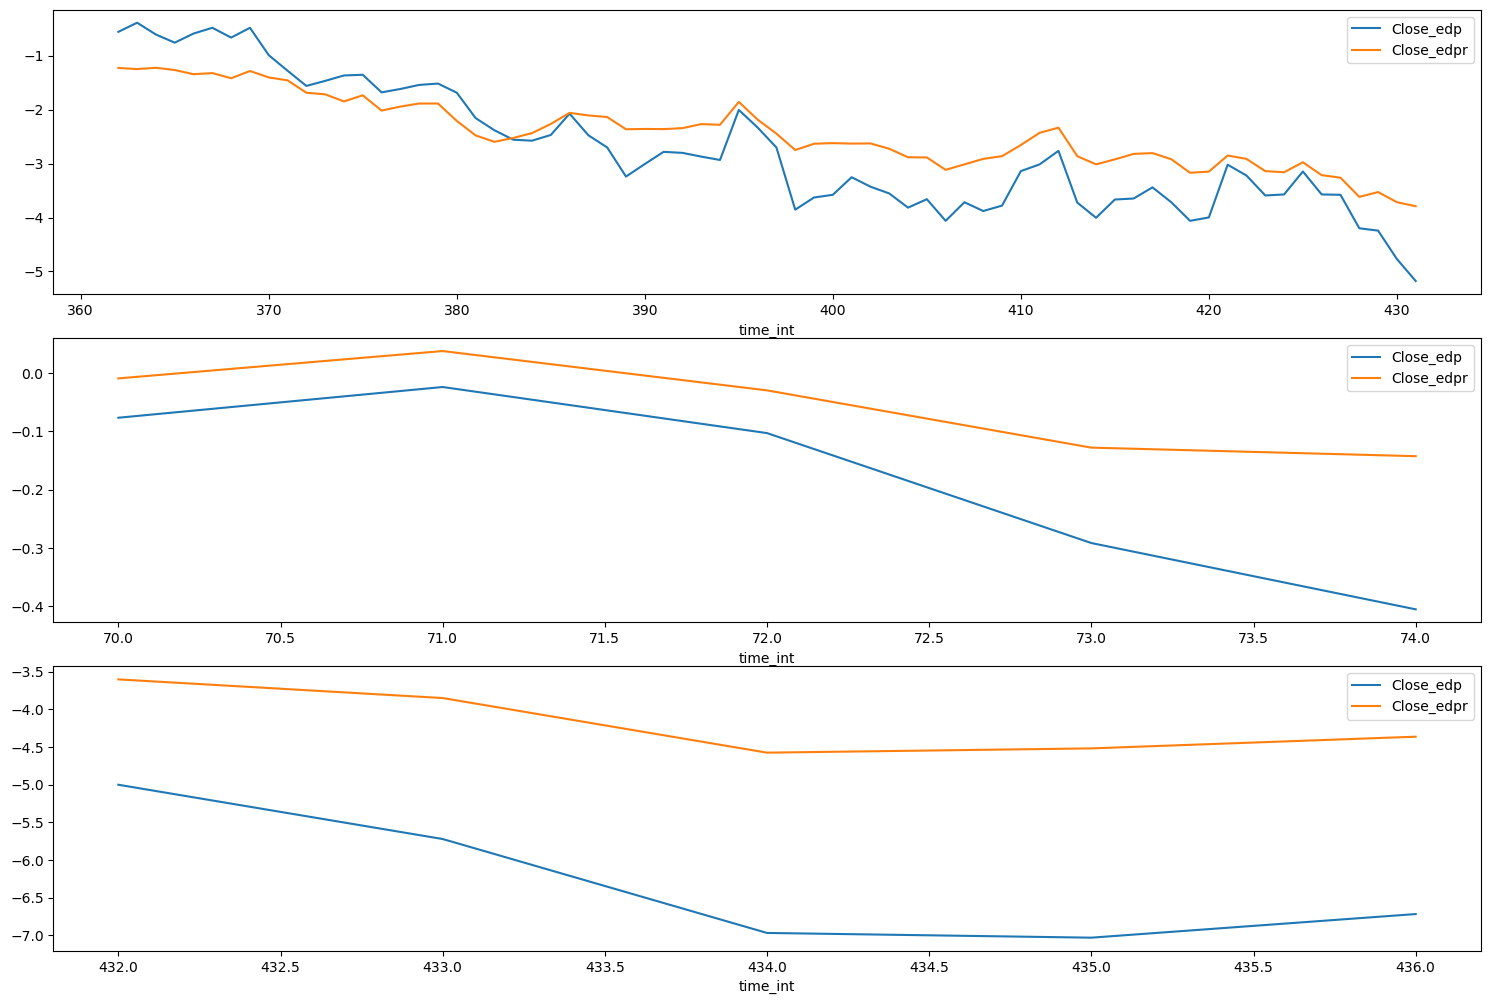

In [318]:
#Training data
dataTR=lisDataTRnorm.copy()
dataTR=dataTR[['Close_edp','Close_edpr']]

#Validation data
dataVL=lisDataVLnorm.copy()
dataVL=dataVL[['Close_edp','Close_edpr']]

#Testing data
dataTE=lisDataTEnorm.copy()
dataTE=dataTE[['Close_edp','Close_edpr']]

fig, axs=plt.subplots(3,figsize=(15,10))
fig.tight_layout()
dataTR.plot(ax=axs[0],legend=True)
dataVL.plot(ax=axs[1],legend=True)
dataTE.plot(ax=axs[2],legend=True)

Minimum RMSE is :7.144108962213326
Best Delay Combination:[[[1, 5]], [1, 2]]


<Axes: xlabel='time_int'>

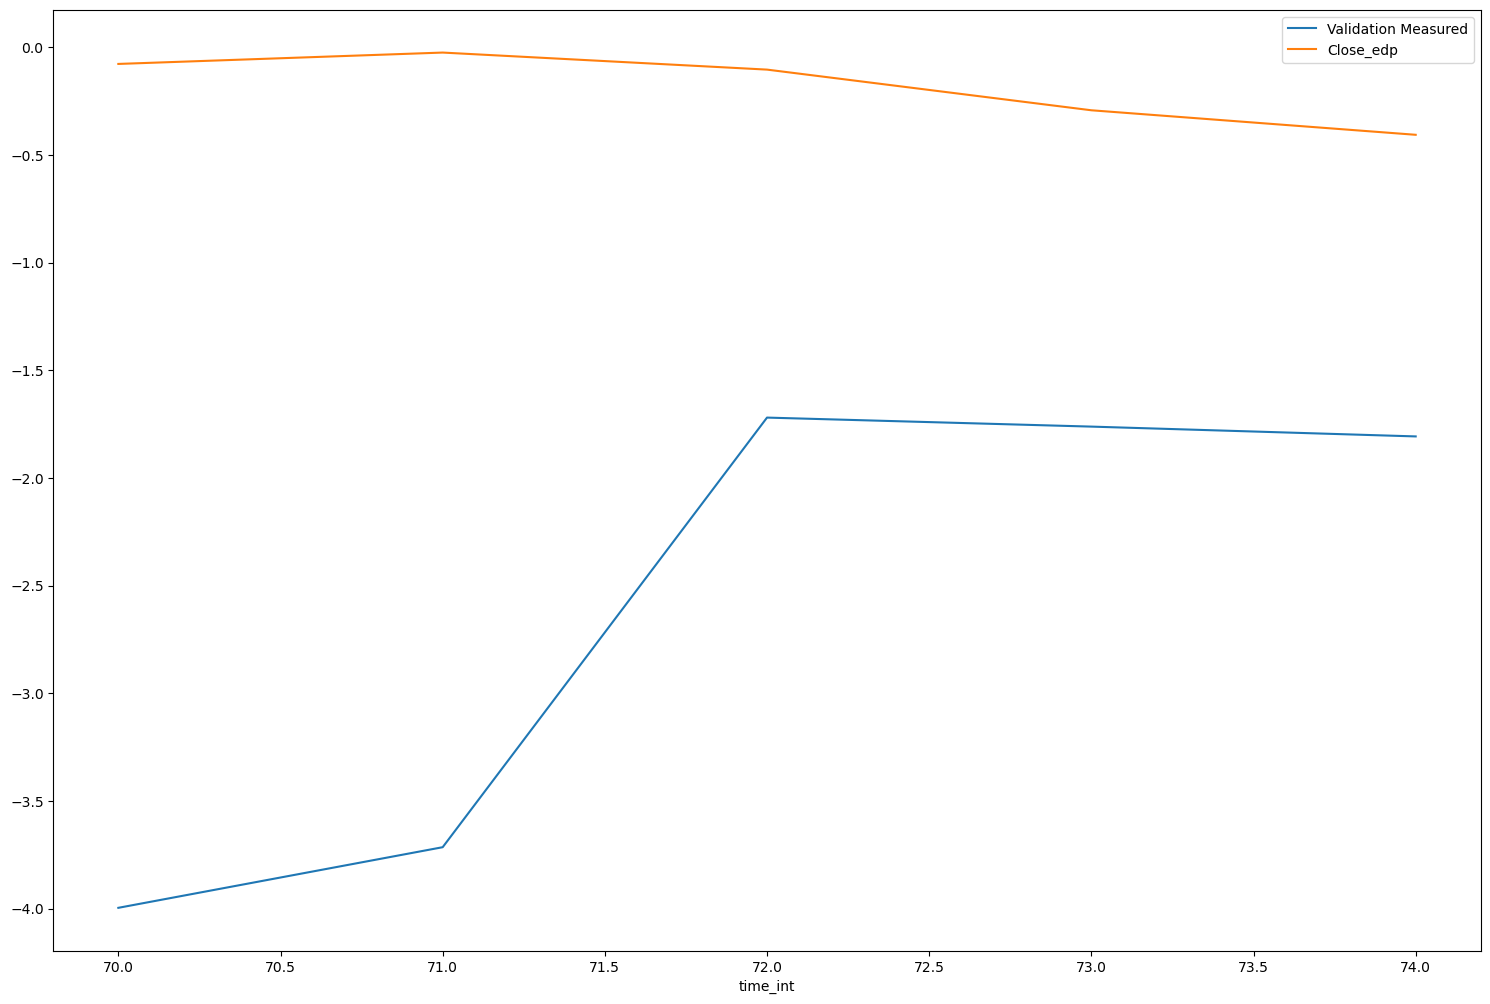

In [319]:
#Test several delay combinations
delays=[[[[1,5]],[1,2]],
        [[[1,5]],[1,3]],
        [[[1,3]],[1,5]],
        [[[2,3]],[1,2]],
        [[[2,3]],[2,3]],
        [[[2,3]],[4,5]],
        [[[4,5]],[4,5]],
        [[[1,2,5]],[1,2,5]],
        [[[1,2,5]],[1,2,5]],
        [[[1,2,5]],[1,2,5]],
        [[[1,2,3,4,5]],[1,2,3,4,5]],]

predicts=[]
rmses=[]
models=[]
for d in delays:
    maxdel=np.amax([np.amax(d[0]),np.amax(d[1])])#Get maximum delay for proper indexing
    #Generate input/output data
    dataDelTR=genIOData(outData=dataTR['Close_edp'],inData=dataTR['Close_edpr'],delayEndog=d[1],delayExog=d[0])
    dataInpTR=dataDelTR.iloc[:,0:-1].to_numpy()
    dataOutTR=dataDelTR.iloc[:,-1].to_numpy()
    dataTRTS=pd.Series(data=dataOutTR,index=outData.index[maxdel:],name='Training Data')
    
    #Validation data
    dataVLU=pd.DataFrame(pd.concat((dataTR.iloc[dataTR.shape[0]-maxdel:],dataVL)),columns=dataVL.columns)
    dataDelVL=genIOData(outData=dataVLU['Close_edp'],inData=dataVLU['Close_edpr'],delayEndog=d[1],delayExog=d[0])
    dataInpVL=dataDelVL.iloc[:,0:-1].to_numpy()
    dataOutVL=dataDelVL.iloc[:,-1].to_numpy()
    dataVLTS=pd.Series(data=dataOutVL,index=dataDelVL.index,name='Val Data')
    
    
    #Implement a MLP regressor
    regr = MLPRegressor(random_state=1, max_iter=5000,early_stopping=True,
                        hidden_layer_sizes=(10,)).fit(dataInpTR, dataOutTR)
    models.append(regr)
    #Evaluate Validation forecasting and error
    predictVLTS=pd.Series(data=regr.predict(dataInpVL),index=dataVLTS.index,name='Validation Measured')
    predicts.append(predictVLTS)
    resTS=dataVLTS-predictVLTS
    resTS.name='Validation Forecasting'                       
    rmses.append((np.sum((resTS.to_numpy())**2))/resTS.size)
    
ix=np.where(rmses==np.min(rmses))[0][0]
print('Minimum RMSE is :'+str(rmses[ix]))
print('Best Delay Combination:'+str(delays[ix]))
#Lets plot best Val error
fig, axs=plt.subplots(1,figsize=(15,10))
fig.tight_layout()
predicts[ix].plot(ax=axs,legend=True)
dataVL['Close_edp'].plot(ax=axs,legend=True)

In [320]:
#Testing performance
#Testing data preparation
d=delays[ix]
maxdel=np.amax([np.amax(d[0]),np.amax(d[1])])#Get maximum delay for proper indexing
dataTEU=pd.DataFrame(pd.concat((dataVL.iloc[dataVL.shape[0]-maxdel:],dataTE)),columns=dataTE.columns)
dataDelTE=genIOData(outData=dataTEU['Close_edp'],inData=dataTEU['Close_edpr'],delayEndog=d[1],delayExog=d[0])
dataDelTE

Close_edpr_lag1  Close_edpr_lag5  Close_edp_lag1  Close_edp_lag2  \
time_int                                                                     
432             -0.142438        -0.008811       -0.405556       -0.291667   
433             -3.602829         0.038179       -5.001317       -0.405556   
434             -3.850457        -0.029369       -5.721839       -5.001317   
435             -4.575438        -0.127753       -6.968656       -5.721839   
436             -4.518752        -0.142438       -7.031310       -6.968656   

          Close_edp  
time_int             
432       -5.001317  
433       -5.721839  
434       -6.968656  
435       -7.031310  
436       -6.718039

In [321]:
dataInpTE=dataDelTE.iloc[:,0:-1].to_numpy()
dataOutTE=dataDelTE.iloc[:,-1].to_numpy()
dataOutTE

array([-5.00131737, -5.72183931, -6.96865555, -7.03130963, -6.71803922])

In [322]:
dataTETS=pd.Series(data=dataOutTE,index=dataDelTE.index,name='Testing Measured')
dataTETS

time_int
432   -5.001317
433   -5.721839
434   -6.968656
435   -7.031310
436   -6.718039
Name: Testing Measured, dtype: float64

Forecast RMSE=2.9936062441821174


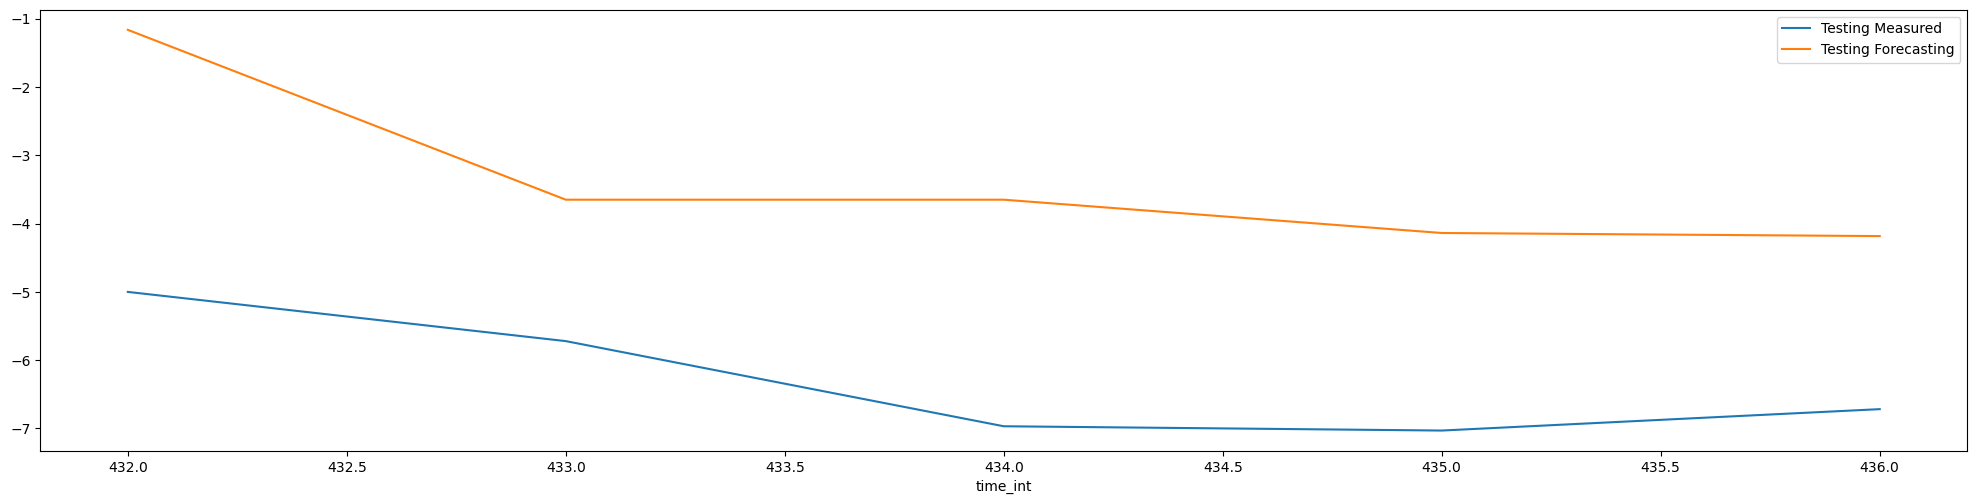

In [323]:
#Plot forecasting in testing
forecastTETS=pd.Series(data=models[ix].predict(dataInpTE),index=dataTETS.index,name='Testing Forecasting')
fig, axs=plt.subplots(1,figsize=(20,5))
fig.tight_layout()
#dataTRTS.plot(legend=True)
dataTETS.plot(ax=axs,legend=True)
forecastTETS.plot(ax=axs,legend=True)

print("Forecast RMSE="+str(np.sqrt(np.sum((dataTETS-forecastTETS)**2)/forecastTETS.size)))

    Valdiação de MLP com Close_Edpr e Close_Edp

In [325]:
list_RMSE = []
unTS=merged_data
list_MAFE = []
list_U2 = []

# Assuming regr is your trained MLPRegressor
for i in range(0, len(unTS)-75):

    lisDataTR=merged_data[0+i:70+i]
    lisDataTE=merged_data[70+i:75+i]

    lisDataTRnorm = pd.DataFrame(data=scaler.transform(lisDataTR),index=lisDataTR["time_int"],columns=lisDataTR.columns)
    lisDataTEnorm = pd.DataFrame(data=scaler.transform(lisDataTE),index=lisDataTE["time_int"],columns=lisDataTE.columns)

    dataTR=lisDataTRnorm.copy()
    dataTR=dataTR[['Close_edp','Close_edpr']]

    #Testing data
    dataTE=lisDataTEnorm.copy()
    dataTE=dataTE[['Close_edp','Close_edpr']]
    
    dataTEU=pd.DataFrame(pd.concat((dataVL.iloc[dataVL.shape[0]-maxdel:],dataTE)),columns=dataTE.columns)
    dataDelTE=genIOData(outData=dataTEU['Close_edp'],inData=dataTEU['Close_edpr'],delayEndog=d[1],delayExog=d[0])

    dataInpTE=dataDelTE.iloc[:,0:-1].to_numpy()
    dataOutTE=dataDelTE.iloc[:,-1].to_numpy()

    dataTETS=pd.Series(data=dataOutTE,index=dataDelTE.index,name='Testing Measured')

    forecastTETS=pd.Series(data=models[ix].predict(dataInpTE),index=dataTETS.index,name='Testing Forecasting')
    #print("Forecast RMSE="+str(np.sqrt(np.sum((dataTETS-forecastTETS)**2)/forecastTETS.size)))

    RMSE = np.sqrt(np.sum((dataTETS-forecastTETS)**2)/forecastTETS.size)
    print("Forecast RMSE="+str(RMSE))

    MAFE = np.mean(np.abs((dataTETS - forecastTETS) / dataTETS))
    print("Forecast MAFE="+str(MAFE))

    U2 = np.sqrt(np.sum((dataTETS - forecastTETS)**2) / np.sum((dataTETS - np.mean(dataTETS))**2))
    print("Forecast U2="+str(U2))

    list_RMSE.append(RMSE)
    list_MAFE.append(MAFE)
    list_U2.append(U2)

print("Em média o RMSE deste modelo é: ",statistics.mean(list_RMSE))
print("Em média o MAFE deste modelo é: ",statistics.mean(list_MAFE))
print("Em média o U2 deste modelo é: ",statistics.mean(list_U2))


/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/tensorflow-tes

Forecast RMSE=1.4591721717451371
Forecast MAFE=0.3687080941658141
Forecast U2=2.2374323982629094
Forecast RMSE=1.5151404967979984
Forecast MAFE=0.40019965080791897
Forecast U2=2.4094413288728727
Forecast RMSE=1.668015241291221
Forecast MAFE=0.42190198756929365
Forecast U2=3.76434324413235
Forecast RMSE=1.7861654544212853
Forecast MAFE=0.4090589771687971
Forecast U2=4.690043219796585
Forecast RMSE=2.118036510656485
Forecast MAFE=0.4332125888233113
Forecast U2=4.169104641138672
Forecast RMSE=2.4181614996108407
Forecast MAFE=0.4935889493849494
Forecast U2=3.270733722072261
Forecast RMSE=2.7559180896714137
Forecast MAFE=0.5415406575049596
Forecast U2=3.1246223813852643
Forecast RMSE=3.0719881296072358
Forecast MAFE=0.6049569987599199
Forecast U2=3.5622937789946283
Forecast RMSE=3.125682732442541
Forecast MAFE=0.5854090245908643
Forecast U2=6.185819471977945
Forecast RMSE=2.913155887769174
Forecast MAFE=0.5303521223503698
Forecast U2=3.184451243464287
Forecast RMSE=2.640585409711671
Forecas

/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/tensorflow-tes

# LSTM

In [ ]:
from keras.models import Model, Sequential
from keras.layers import GRU, Dense,LSTM,Dropout 
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
from tensorflow.keras.utils import plot_model


In [ ]:
lisDataTR=merged_data[0:70]
lisDataVL=merged_data[70:75]
lisDataTE=merged_data[75:80]
lisDataTRstd = pd.DataFrame(data=scaler.transform(lisDataTR),index=lisDataTR["time_int"],columns=lisDataTR.columns)
lisDataVLstd = pd.DataFrame(data=scaler.transform(lisDataVL),index=lisDataVL["time_int"],columns=lisDataVL.columns)
lisDataTEstd = pd.DataFrame(data=scaler.transform(lisDataTE),index=lisDataTE["time_int"],columns=lisDataTE.columns)

/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


    CLOSE_EDP + CLOSE_EDPR

<Axes: xlabel='time_int'>

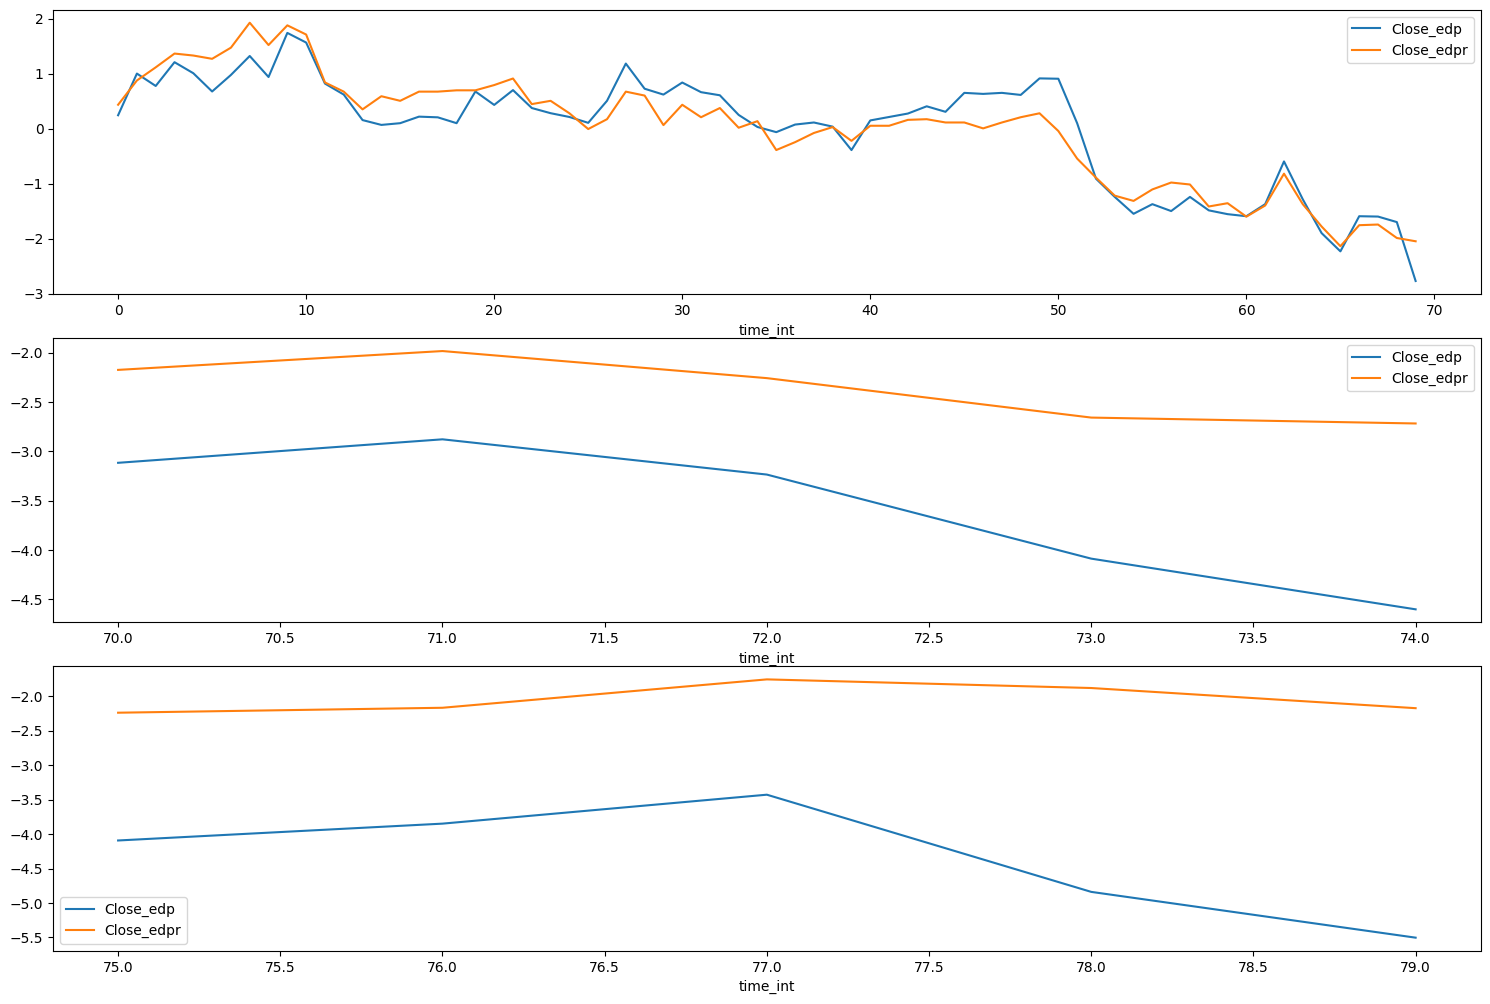

In [ ]:
#Training data previously normalized
dataTR=lisDataTRstd.copy()
dataTR=dataTR[['Close_edp','Close_edpr']]
#Validation data previously normalized
dataVL=lisDataVLstd.copy()
dataVL=dataVL[['Close_edp','Close_edpr']]
#Testing data previously normalized
dataTE=lisDataTEstd.copy()
dataTE=dataTE[['Close_edp','Close_edpr']]
fig, axs=plt.subplots(3,figsize=(15,10)) 
fig.tight_layout() 
dataTR.plot(ax=axs[0],legend=True) 
dataVL.plot(ax=axs[1],legend=True) 
dataTE.plot(ax=axs[2],legend=True)

In [ ]:
maxLag=5#Maximum delay
delays=range(1,maxLag+1)
#Generate input/output data 
dataDelTR=genIOData(outData=dataTR['Close_edp'],inData=dataTR['Close_edpr'],delayEndog=delays,delayExog=[delays])

In [ ]:
dataInpTR=dataDelTR.iloc[:,0:-1]
dataOutTR=dataDelTR.iloc[:,-1].to_numpy()
InpTensTR=genTensor(dataInpTR,maxLag,2)
OutTensTR=dataOutTR
#Validation data
dataVLU=pd.DataFrame(pd.concat((dataTR.iloc[dataTR.shape[0]-maxLag:],dataVL)), columns=dataVL.columns)
dataDelVL=genIOData(outData=dataVLU['Close_edp'],inData=dataVLU['Close_edpr'], delayEndog=delays,delayExog=[delays])
dataInpVL=dataDelVL.iloc[:,0:-1]
dataOutVL=dataDelVL.iloc[:,-1].to_numpy()
InpTensVL=genTensor(dataInpVL,maxLag,2)
OutTensVL=dataOutVL
#Testing data
dataTEU=pd.DataFrame(pd.concat((dataVL.iloc[dataVL.shape[0]-maxLag:],dataTE)), columns=dataTE.columns)
dataDelTE=genIOData(outData=dataTEU['Close_edp'],inData=dataTEU['Close_edpr'], delayEndog=delays,delayExog=[delays])
dataInpTE=dataDelTE.iloc[:,0:-1]
dataOutTE=dataDelTE.iloc[:,-1].to_numpy()
InpTensTE=genTensor(dataInpTE,maxLag,2)
OutTensTE=dataOutTE
dataTETS=pd.Series(data=dataOutTE,index=dataDelTE.index,name='Testing Measured')

(65, 5, 2)
(5, 5, 2)
(5, 5, 2)


In [ ]:
from keras.models import Model, Sequential
from keras.layers import GRU, Dense,LSTM,Dropout 
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
from keras.utils import plot_model
LATENT_DIM=50
BATCH_SIZE =8
EPOCHS = 100
HORIZON=1
regressorLSTM = Sequential()
regressorLSTM.add(LSTM(LATENT_DIM, input_shape=(maxLag, 2)))
regressorLSTM.add(Dense(HORIZON))
regressorLSTM.compile(optimizer='RMSprop', loss='mse') 

regressorLSTM.summary()
plot_model(regressorLSTM, to_file='model_plot.png', show_shapes=True,
show_layer_names=True,expand_nested=True,show_dtype=True,rankdir="TB", show_layer_activations=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50)                10600     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10651 (41.61 KB)
Trainable params: 10651 (41.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
LSTM_earlystop = EarlyStopping(monitor='val_loss', min_delta=0,patience=5)
model_history = regressorLSTM.fit(InpTensTR,OutTensTR,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(InpTensVL, OutTensVL),callbacks=[LSTM_earlystop],verbose=1)

Epoch 1/100
9/9 [==============================] - 2s 28ms/step - loss: 0.9376 - val_loss: 9.7700
Epoch 2/100
9/9 [==============================] - 0s 4ms/step - loss: 0.5233 - val_loss: 6.3087
Epoch 3/100
9/9 [==============================] - 0s 3ms/step - loss: 0.3101 - val_loss: 3.7280
Epoch 4/100
9/9 [==============================] - 0s 3ms/step - loss: 0.2146 - val_loss: 2.6889
Epoch 5/100
9/9 [==============================] - 0s 3ms/step - loss: 0.1972 - val_loss: 2.2820
Epoch 6/100
9/9 [==============================] - 0s 3ms/step - loss: 0.1925 - val_loss: 1.4694
Epoch 7/100
9/9 [==============================] - 0s 3ms/step - loss: 0.2039 - val_loss: 2.0864
Epoch 8/100
9/9 [==============================] - 0s 4ms/step - loss: 0.1913 - val_loss: 2.2985
Epoch 9/100
9/9 [==============================] - 0s 3ms/step - loss: 0.1876 - val_loss: 2.6310
Epoch 10/100
9/9 [==============================] - 0s 3ms/step - loss: 0.1793 - val_loss: 1.7137
Epoch 11/100
9/9 [==========

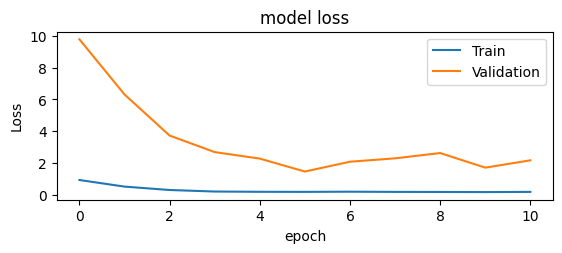

In [ ]:
plt.subplot(2,1,2)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

3/3 [==============================] - 0s 1ms/step


<Figure size 640x480 with 0 Axes>

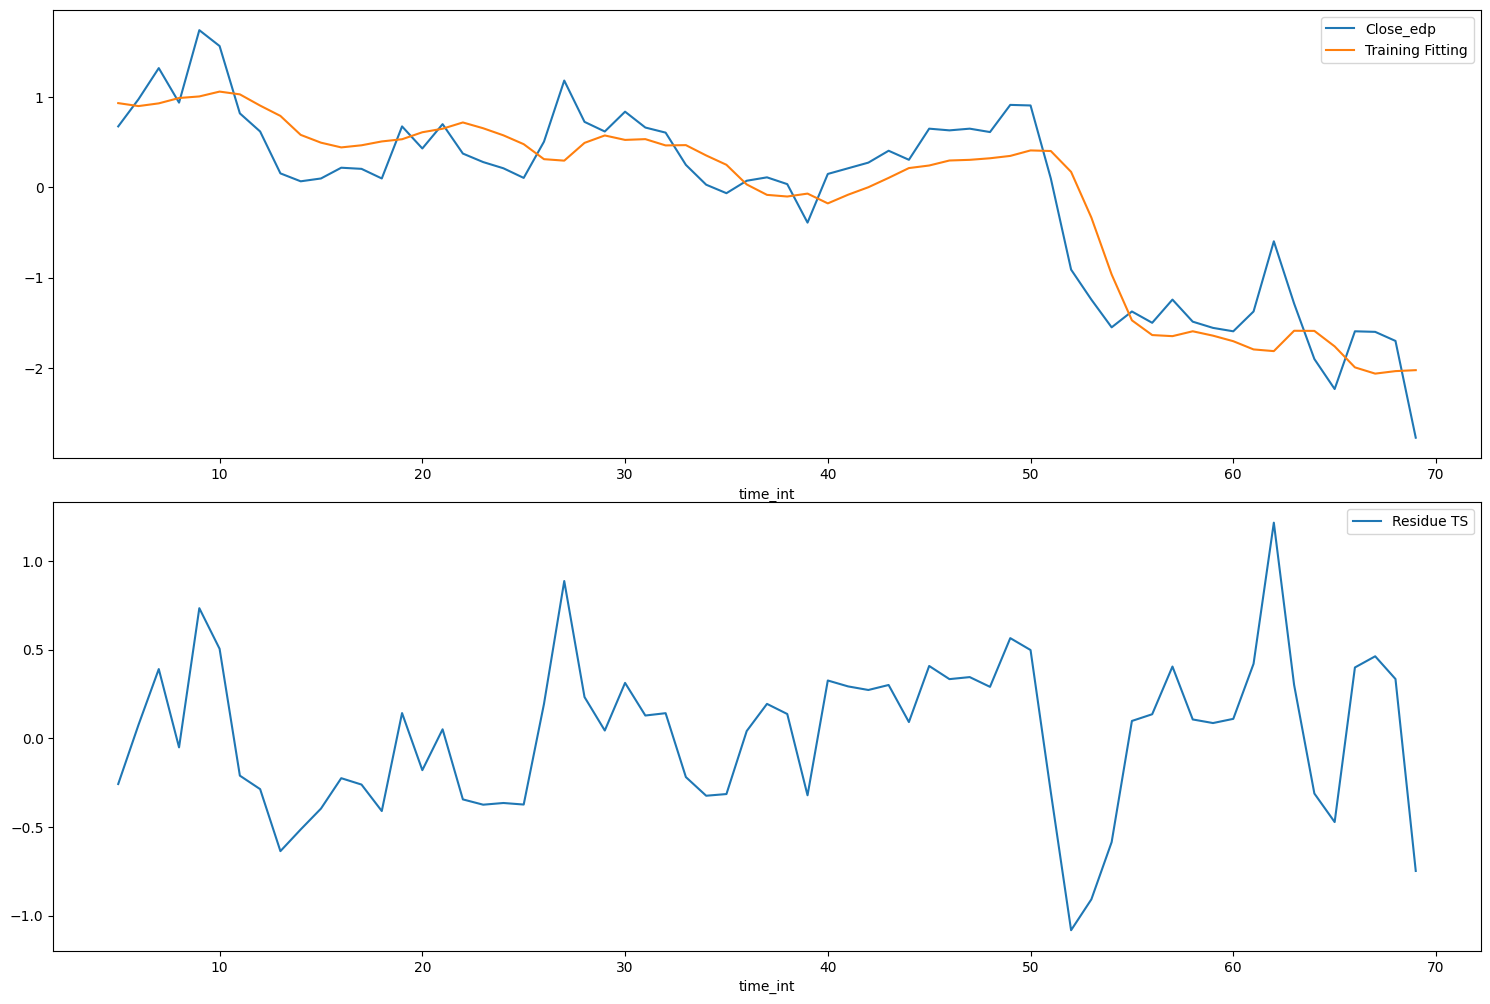

<Figure size 640x480 with 0 Axes>

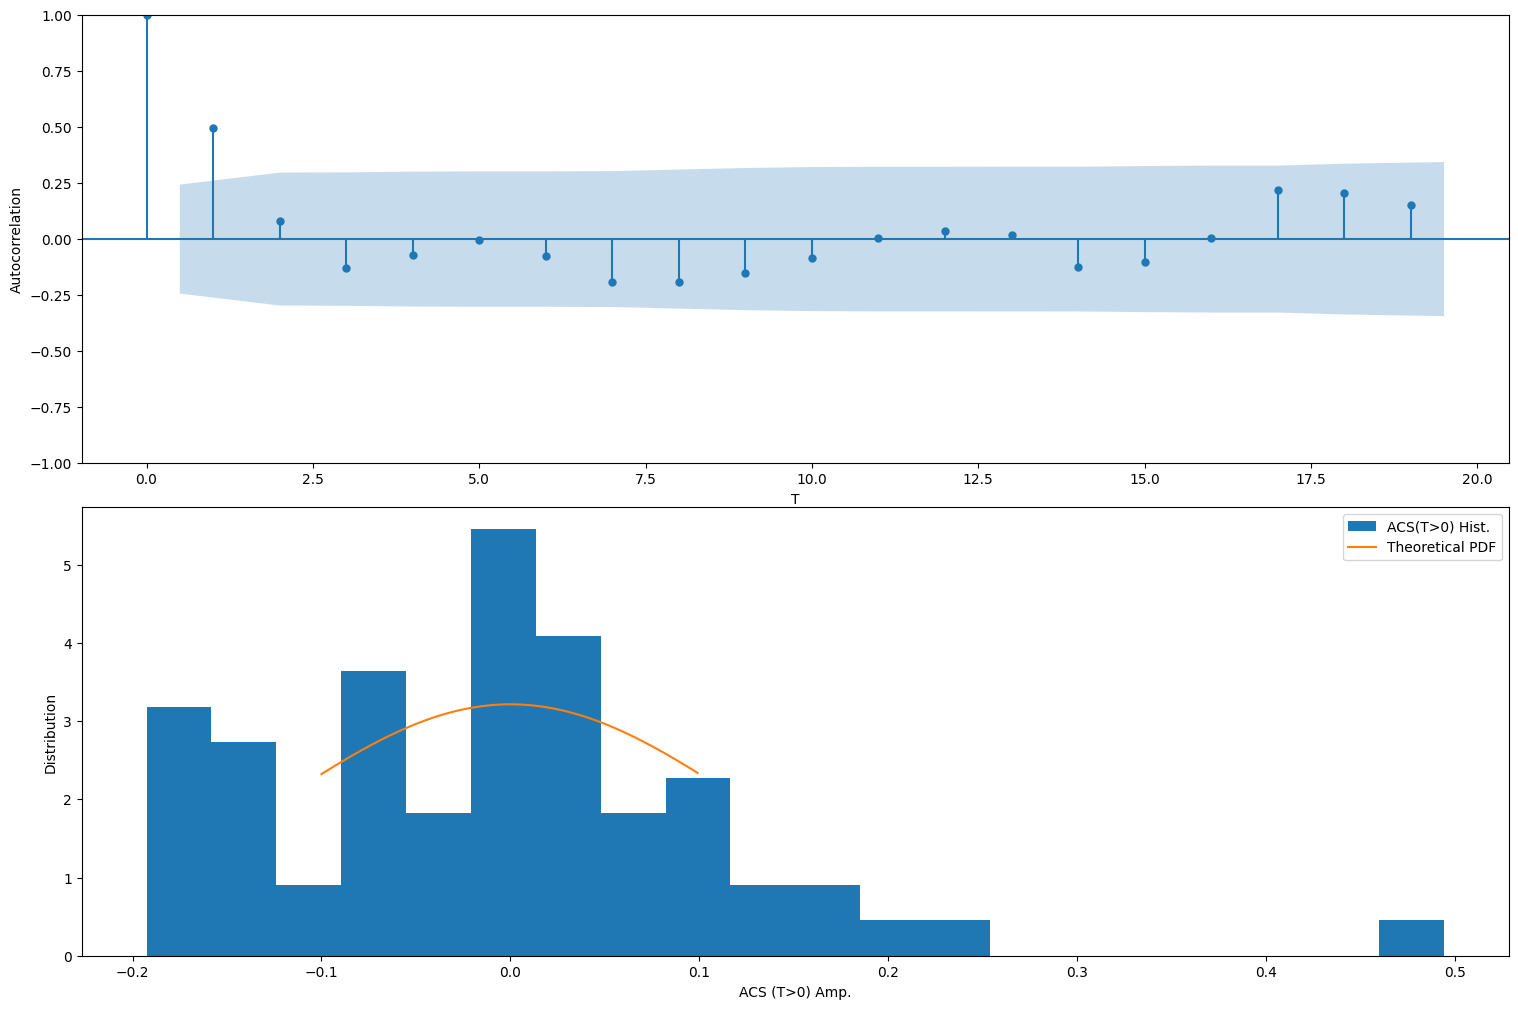

In [ ]:
TRPred=regressorLSTM.predict(InpTensTR)
predTS=pd.Series(data=TRPred[:,0],index=dataTR.index[maxLag:],name='Training Fitting')
resTS=dataTR['Close_edp'].iloc[maxLag:]-predTS
resTS.name='Residue TS'
plt.figure()
fig, axs=plt.subplots(2,figsize=(15,10)) 
fig.tight_layout() 
dataTR['Close_edp'][maxLag:].plot(ax=axs[0],legend=True) 
predTS.plot(ax=axs[0],legend=True) 
resTS.plot(ax=axs[1],legend=True)

#Evaluate fitting quality by inspecting residuals at two levels: ACS and ACS #distribution
plt.figure()
fig, axs=plt.subplots(2,figsize=(15,10))
fig.tight_layout()
plot_acf(resTS,ax=axs[0],title="")
axs[0].set_xlabel("T")
axs[0].set_ylabel("Autocorrelation")
ac=acf(resTS,nlags=500,fft=False) 
axs[1].hist(ac[1:],bins=20,density=True,label='ACS(T>0) Hist.')
N=resTS.size
rg=np.arange(-0.1,0.1,0.001)
pdf = spyst.norm.pdf(rg,0,1/np.sqrt(N))
plt.plot(rg,pdf,label='Theoretical PDF')
plt.xlabel("ACS (T>0) Amp.")
plt.ylabel("Distribution")
plt.legend()

1/1 [==============================] - 0s 19ms/step
Forecast RMSE=1.4743430526736556


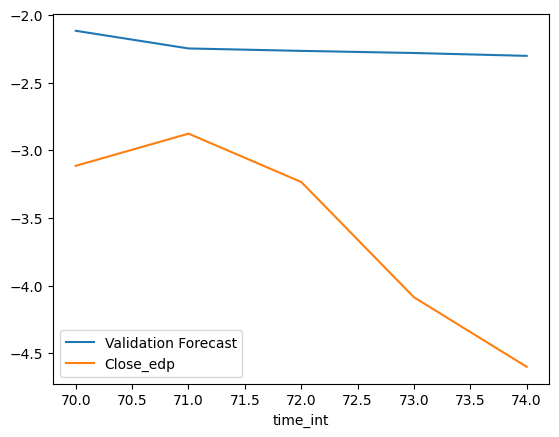

In [ ]:
plt.figure()
vl_predictions = regressorLSTM.predict(InpTensVL) #Lets back to the original domain by integrating
predTS=pd.Series(data=vl_predictions[:,0],index=dataVL.index,name='Validation Forecast')
predTS.plot(legend=True)
dataVL['Close_edp'].plot(legend=True)
print("Forecast RMSE="+str(np.sqrt(np.sum((dataVL['Close_edp']- predTS)**2)/predTS.size)))

## Validar LSTM

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Initialize lists to store metrics
rmse_values = []
u2_values = []
mafe_values = []

# Loop over the data
for i in range(0, len(merged_data) - 75):
    # Define the training and testing data
    lisDataTR = merged_data[i:i+75]
    lisDataTE = merged_data[i+70:i+75]
    
    # Normalize the data
    lisDataTRstd = pd.DataFrame(data=scaler.transform(lisDataTR),index=lisDataTR["time_int"],columns=lisDataTR.columns)
    lisDataTEstd = pd.DataFrame(data=scaler.transform(lisDataTE),index=lisDataTE["time_int"],columns=lisDataTE.columns)

    # Select the columns
    dataTR = lisDataTRstd[['Close_edp','Close_edpr']]
    dataTE = lisDataTEstd[['Close_edp','Close_edpr']]

    # Prepare the input tensors
    dataDelTR = genIOData(outData=dataTR['Close_edp'], inData=dataTR['Close_edpr'], delayEndog=delays, delayExog=[delays])
    dataInpTR = dataDelTR.iloc[:,0:-1]
    dataOutTR = dataDelTR.iloc[:,-1].to_numpy()
    InpTensTR = genTensor(dataInpTR, maxLag, 2)
    OutTensTR = dataOutTR
    
    # Make predictions on the next 5 data points of the training data
    predictions = regressorLSTM.predict(InpTensTR[-5:])
    #print("Predictions:", predictions,dataTE["Close_edp"])
    
    # Calculate the metrics
    rmse = np.sqrt(mean_squared_error(dataTE["Close_edp"], predictions))
    print("rmse: ",rmse)
    u2 = 1 - np.var(dataTE - predictions) / np.var(dataTE)
    mafe = np.mean(np.abs((dataTE - predictions) / dataTE))
    
    # Store the metrics
    rmse_values.append(rmse)
    u2_values.append(u2)
    mafe_values.append(mafe)

# Calculate the average metrics
avg_rmse = np.mean(rmse_values)
avg_u2 = np.mean(u2_values)
avg_mafe = np.mean(mafe_values)

print('Average RMSE:', avg_rmse)
print('Average U2:', avg_u2)
print('Average MAFE:', avg_mafe)


(70, 5, 2)
1/1 [==============================] - 0s 11ms/step


rmse:  3.1652025368590153
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  3.333022193217153
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  3.4783179774047164
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  3.495281713702379
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/b

rmse:  3.6490889269082043
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  3.859092787260922
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  4.1858754227717565
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  4.549253347723468
(70, 5, 2)
1/1 [==============================] - 0s 14ms/step
rmse:  4.692237239534264
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  4.458796689694172
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  4.107388267803146
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  3.579841738605297
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  2.814527740476065
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  2.413322436289196
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  2.257728046829192
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  2.022158063234022
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  2.0552060979323676
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  2.276599198418396
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  2.3118266702400634
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  2.303318005251315
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  2.2976972108146585
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  2.1602452594213335
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  2.1146191074790885
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  2.1494885168011577
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  2.2420658113259524
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  2.1669441109376737
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  2.0227207425368703
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.6990697995779345
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.3199247763233555
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.7956733859589668
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  0.41718372636240647
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.44113727528212177
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.4853557342339982
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.46190669669182405
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.4037000598826621
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.32556043399028917
(70, 5, 2)
1/1 [==============================] - ETA: 0s

/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  0.4069509842245512
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.4815826005046333
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.49727851702419174
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.9321369898927401
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.2153905297854892
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.3434832599505009
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.4993079283938695
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  1.7861474276112468
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  1.792022258940259
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.8825959399926866
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  2.0669396447431176
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  2.010570593835876
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.9729421337679298
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  1.935496801902398
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.7273220042249016
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.600917555980081
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.7237055054536248
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.5922046887493067
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.5194085933796186
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.495136313151225
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  1.225393356035463
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.8754448118749346
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.6225342346800409
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.35317631536248345
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.21517830129999274
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.24718322621008434
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 10ms/step
rmse:  0.25213738576972083
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.2599477112669596
(70, 5, 2)
1/1 [==============================] - 0s 14ms/step
rmse:  0.22999474080689025
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.1733378635027369
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.17273078441189482
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.3068516458227804
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 10ms/step
rmse:  0.5605158093976353
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.9176915870790548
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.0921756616946363
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.2899465822169682
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.4608425902321076
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.454173365473571
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.5025094615887733
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  1.6798763164255608
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.6838337592992239
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.605673932231846
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.5616661493959638
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.386602442808841
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.053063907397561
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.8036502632442596
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  0.6363124300068049
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.5915032589090425
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.45014118108784357
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.44959779087580487
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.7412175482205373
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.8103062514381875
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.8570534597998818
(70, 5, 2)

/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o


1/1 [==============================] - 0s 12ms/step
rmse:  0.8681842987487726
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.8150693765102499
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.6009762017410079
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.46287113860147416
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.35964635115577365
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.4066647892076394
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.502853229577989
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  0.625097211716613
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.7699362562170503
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.9314605907898592
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.9905934862492006
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.9662471305480678
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.9115200113161225
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.870777295491259
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 13ms/step
rmse:  0.9658226395917286
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.237505590821936
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.4127184069158216
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.5110020537792734
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.5076146794010217
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.4621934272249915
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.4035928080280355
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  1.5168488766003085
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.5713481600691492
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  1.7312896184506499
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.8702415635604583
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.8770695959001062
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.8232343944308635
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.8729896083759607


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.8570262181963848
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.6302316140897877
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.4388749779431267
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.2086794324197163
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.9077202204615061
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.5871961303439639
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 10ms/step
rmse:  0.7634798929135361
(70, 5, 2)
1/1 [==============================] - 0s 15ms/step
rmse:  0.8858645480695589
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.9466890277729947
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.9102688023784313
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.9515657499863959
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.8767873106891364
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  0.7636455238964717
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.7680769130588024
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.7356587016792462
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.6402591360372103
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.7459049112613119
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.9491757932324912
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.0661719407672965
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  1.2935671228661745
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.4762450697209297
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.4289554077760402
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.3238196340544364
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.2791434594601745
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.3071596089109776
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.3649369779904201
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  1.6796696383173635
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  2.084007465481748
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  2.581063400686428
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  2.986353204603907
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  3.2139140346690898
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  3.2584634038547104
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  3.162973465051885
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  2.930687827561229
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  2.644380072853577
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  2.5249975414629997
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  2.41605511750334
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  2.3066084281470367
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  2.0870445992256994
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.80185657803296
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 10ms/step
rmse:  1.5693129740570737
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.561945855316952
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.633613799505745
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.71977753537357
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.719593001525673
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.6701754795998112
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.5758120194769314
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  1.4935037432932172
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.4999215438220317
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.6593308144900143
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.6294837827066047
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.6491389779953944
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.5895322979879583
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.5158062137059487
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 10ms/step
rmse:  1.3613233323449345
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.314621469815839
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.0996437644929937
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.9882214243952604
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.8731064828739717
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.8411544130900074
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.7006628901421544
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  0.6929485951473716
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.6639534869059645
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.6014126883521287
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.4445084140619011
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.38267489297495944
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.39387466069092586
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.41196506715763687
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  0.40514251507323135
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.4048991205000537
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.31238219112672916
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.20580129136410927
(70, 5, 2)
1/1 [==============================] - 0s 15ms/step
rmse:  0.12750759278765506
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.13206159142189694
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  0.22255649220856852
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.22206157284657865
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.2106773203043443
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.4335571811424927
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.4488996520544386
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.441403571078676
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.454236803761622
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  0.47449402986628897
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.3745484784461359
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.6413518463553478
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.6678384838725218
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.6776957323717407
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.6699396373628086
(70, 5, 2)
1/1 [==============================] - ETA: 0s

/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 10ms/step
rmse:  0.6169178464909484
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.3166219201540427
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.19785482615848568
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.14092662454081778
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.19719635623263637
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.2560335658929238
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.25583754449366825
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  0.3022235937993446
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.33323257293526065
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.34558664436949205
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.39050433290297365
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.5130893463329119
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.5441055402742939
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.5521696367922813
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  0.5608647115801394
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.5216454831366315
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.42692075056226175
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.3525186291859363
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.3056198263894306
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.4179387635056165
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.41939775952346714
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 10ms/step
rmse:  0.4056426861938889
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.41653150509012465
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.427092733675584
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.2782613119737574
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.2418598234292738
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.22201675336604143
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.21614963704712975
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  0.1873914855143593
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.2462537616060487
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.2655535037545314
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.3652521495569746
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.36054652110108054
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.37358723088341755
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.36321110365704107


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  0.3565488432477964
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  0.31385846184575
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  0.3087306619156516
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.3615763418606661
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.3864394475255093
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.5014237098309188
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.7141650763074844
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  1.0640657184685904
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  1.2226083780145942
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.330130010722397
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.5128227871713218
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.6226953817229275
(70, 5, 2)
1/1 [==============================] - 0s 18ms/step
rmse:  1.596832094193759
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 12ms/step
rmse:  1.643065599304687
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  1.7472451236276958
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  1.6128143647217377
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.4898484810466126
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.4021005042721653
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.5311592881625486
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.6285058018995298


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.894389552242913
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  2.0572674961652
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  2.2288710772268994
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  2.2130755235814967
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  2.233917085175362
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  2.0330931220446695
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.8298223956226514
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 10ms/step
rmse:  1.5452011391010492
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.3230424533913823
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  0.8443910915574195
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  0.7240439900041163
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  0.6475744175644101
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  0.6344031285096946
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 13ms/step
rmse:  0.43764505561635464
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.5307539739955687
(70, 5, 2)
1/1 [==============================] - 0s 13ms/step
rmse:  0.6062228907176598
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  0.7025057666245259
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.7090609076769768
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.6963727656028846
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  0.5926688677955924
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.45812578146288363
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.2623536842583195
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.21644166008540744
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.4364591736057088
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.6302799857335398
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.646787104361947
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  0.6496310482720317
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.6629109930539318
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.5623336318476265
(70, 5, 2)
1/1 [==============================] - 0s 14ms/step
rmse:  0.3466425317064595
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.3045899646389734
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.34056561398797924
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 10ms/step
rmse:  0.34601339655345065
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.3513843026433928
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.3458419032273217
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.3898112780323983
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.3682998242821475
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.43937732980422184
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.6157656939123681
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  0.8366845981156459
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.9670600912672388
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.067195893785177
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.106174948553547
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.1611294101894059
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.1464938247029368
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.1427225049071534
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  1.1583970487916646
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.2146235138608892
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.3226662647912948
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.4904033366507743
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.6914237814175974
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.873653387195442
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.9950824128599656
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  1.9695083446370514
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.9763075655491305
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.9978378757134676
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  2.148577299985312
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  2.256481395099151
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  2.3721188025203306
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  2.424774178302625
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 10ms/step
rmse:  2.4495992302112652
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  2.3768463519271976
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  2.1967816097468034
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  2.1108151322233146
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  2.0932174809327164
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  2.3534280377208514
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  2.517123497947884
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  2.78782261138664
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  2.9300362970336447
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  3.046430695436959
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  2.9735044996338917
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  3.0049414690583434
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  3.0170473970492897
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  3.1788485253685024
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 10ms/step
rmse:  3.2329965395620435
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  3.2949114110489237
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  3.28615912883539
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  3.1926544967084234
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  2.9901390606888887
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  2.814925115964788
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  2.783315467496649
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 10ms/step
rmse:  2.842964812148412
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  2.9513911000805915
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  3.0692007208516805
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  3.177613948218519
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  3.1728288346868525
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  3.1819108870284643
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  3.2477103239789264
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  3.1365543487861682
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  3.098971307392769
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  3.0748801949210325
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  2.9707001044589396
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  2.7945056635746877
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  2.9048547674653555
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  2.976862952722433
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 10ms/step
rmse:  3.11416417951991
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  3.256918320992297
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  3.5795238787874752
(70, 5, 2)
1/1 [==============================] - 0s 15ms/step
rmse:  3.9060981361615132
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  4.166523675555252
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  4.473323522058271
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

rmse:  5.046176967786303
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  5.50064481379365
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  5.7913649538567995
Average RMSE: 1.4348691010308718
Average U2: -0.08367326747043895
Average MAFE: 1.648837766112117


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

## CLOSE_EDP + CRUDE

<Axes: xlabel='time_int'>

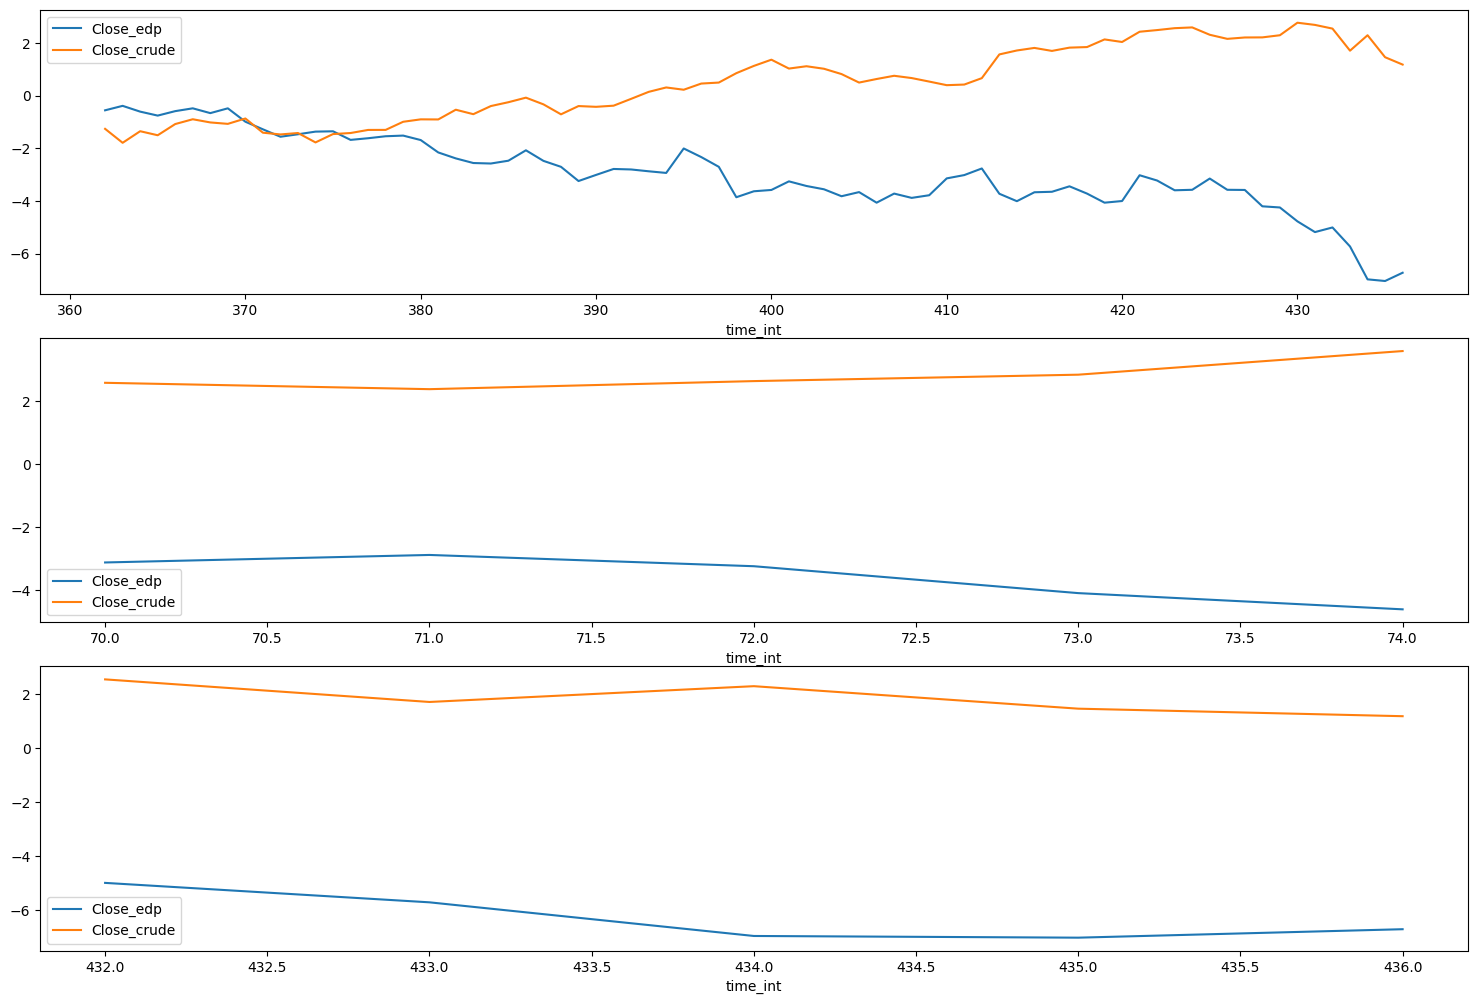

In [ ]:
#Training data previously normalized
dataTR=lisDataTRstd.copy()
dataTR=dataTR[['Close_edp','Close_crude']]
#Validation data previously normalized
dataVL=lisDataVLstd.copy()
dataVL=dataVL[['Close_edp','Close_crude']]
#Testing data previously normalized
dataTE=lisDataTEstd.copy()
dataTE=dataTE[['Close_edp','Close_crude']]
fig, axs=plt.subplots(3,figsize=(15,10)) 
fig.tight_layout() 
dataTR.plot(ax=axs[0],legend=True) 
dataVL.plot(ax=axs[1],legend=True) 
dataTE.plot(ax=axs[2],legend=True)

In [ ]:
maxLag=5#Maximum delay
delays=range(1,maxLag+1)
#Generate input/output data 
dataDelTR=genIOData(outData=dataTR['Close_edp'],inData=dataTR['Close_crude'],delayEndog=delays,delayExog=[delays])

In [ ]:
dataInpTR=dataDelTR.iloc[:,0:-1]
dataOutTR=dataDelTR.iloc[:,-1].to_numpy()
InpTensTR=genTensor(dataInpTR,maxLag,2)
OutTensTR=dataOutTR
#Validation data
dataVLU=pd.DataFrame(pd.concat((dataTR.iloc[dataTR.shape[0]-maxLag:],dataVL)), columns=dataVL.columns)
dataDelVL=genIOData(outData=dataVLU['Close_edp'],inData=dataVLU['Close_crude'], delayEndog=delays,delayExog=[delays])
dataInpVL=dataDelVL.iloc[:,0:-1]
dataOutVL=dataDelVL.iloc[:,-1].to_numpy()
InpTensVL=genTensor(dataInpVL,maxLag,2)
OutTensVL=dataOutVL
#Testing data
dataTEU=pd.DataFrame(pd.concat((dataVL.iloc[dataVL.shape[0]-maxLag:],dataTE)), columns=dataTE.columns)
dataDelTE=genIOData(outData=dataTEU['Close_edp'],inData=dataTEU['Close_crude'], delayEndog=delays,delayExog=[delays])
dataInpTE=dataDelTE.iloc[:,0:-1]
dataOutTE=dataDelTE.iloc[:,-1].to_numpy()
InpTensTE=genTensor(dataInpTE,maxLag,2)
OutTensTE=dataOutTE
dataTETS=pd.Series(data=dataOutTE,index=dataDelTE.index,name='Testing Measured')

(70, 5, 2)
(5, 5, 2)
(5, 5, 2)


In [ ]:
from keras.models import Model, Sequential
from keras.layers import GRU, Dense,LSTM,Dropout 
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
from keras.utils import plot_model
LATENT_DIM=50
BATCH_SIZE =8
EPOCHS = 100
HORIZON=1
regressorLSTM = Sequential()
regressorLSTM.add(LSTM(LATENT_DIM, input_shape=(maxLag, 2)))
regressorLSTM.add(Dense(HORIZON))
regressorLSTM.compile(optimizer='RMSprop', loss='mse') 

regressorLSTM.summary()
plot_model(regressorLSTM, to_file='model_plot.png', show_shapes=True,
show_layer_names=True,expand_nested=True,show_dtype=True,rankdir="TB", show_layer_activations=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50)                10600     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10651 (41.61 KB)
Trainable params: 10651 (41.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
LSTM_earlystop = EarlyStopping(monitor='val_loss', min_delta=0,patience=5)
model_history = regressorLSTM.fit(InpTensTR,OutTensTR,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(InpTensVL, OutTensVL),callbacks=[LSTM_earlystop],verbose=1)

Epoch 1/100
9/9 [==============================] - 1s 27ms/step - loss: 7.6552 - val_loss: 3.3584
Epoch 2/100
9/9 [==============================] - 0s 4ms/step - loss: 2.6670 - val_loss: 0.8047
Epoch 3/100
9/9 [==============================] - 0s 3ms/step - loss: 0.8184 - val_loss: 1.0115
Epoch 4/100
9/9 [==============================] - 0s 3ms/step - loss: 0.4726 - val_loss: 1.3521
Epoch 5/100
9/9 [==============================] - 0s 3ms/step - loss: 0.4347 - val_loss: 1.2704
Epoch 6/100
9/9 [==============================] - 0s 3ms/step - loss: 0.4337 - val_loss: 1.3930
Epoch 7/100
9/9 [==============================] - 0s 3ms/step - loss: 0.4169 - val_loss: 1.3803


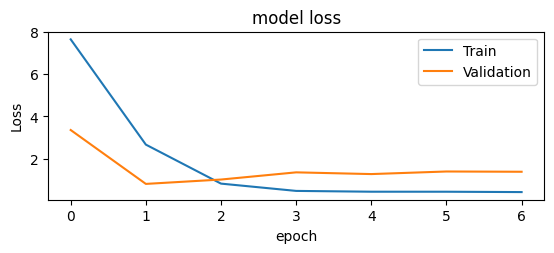

In [ ]:
plt.subplot(2,1,2)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

3/3 [==============================] - 0s 1ms/step


<Figure size 640x480 with 0 Axes>

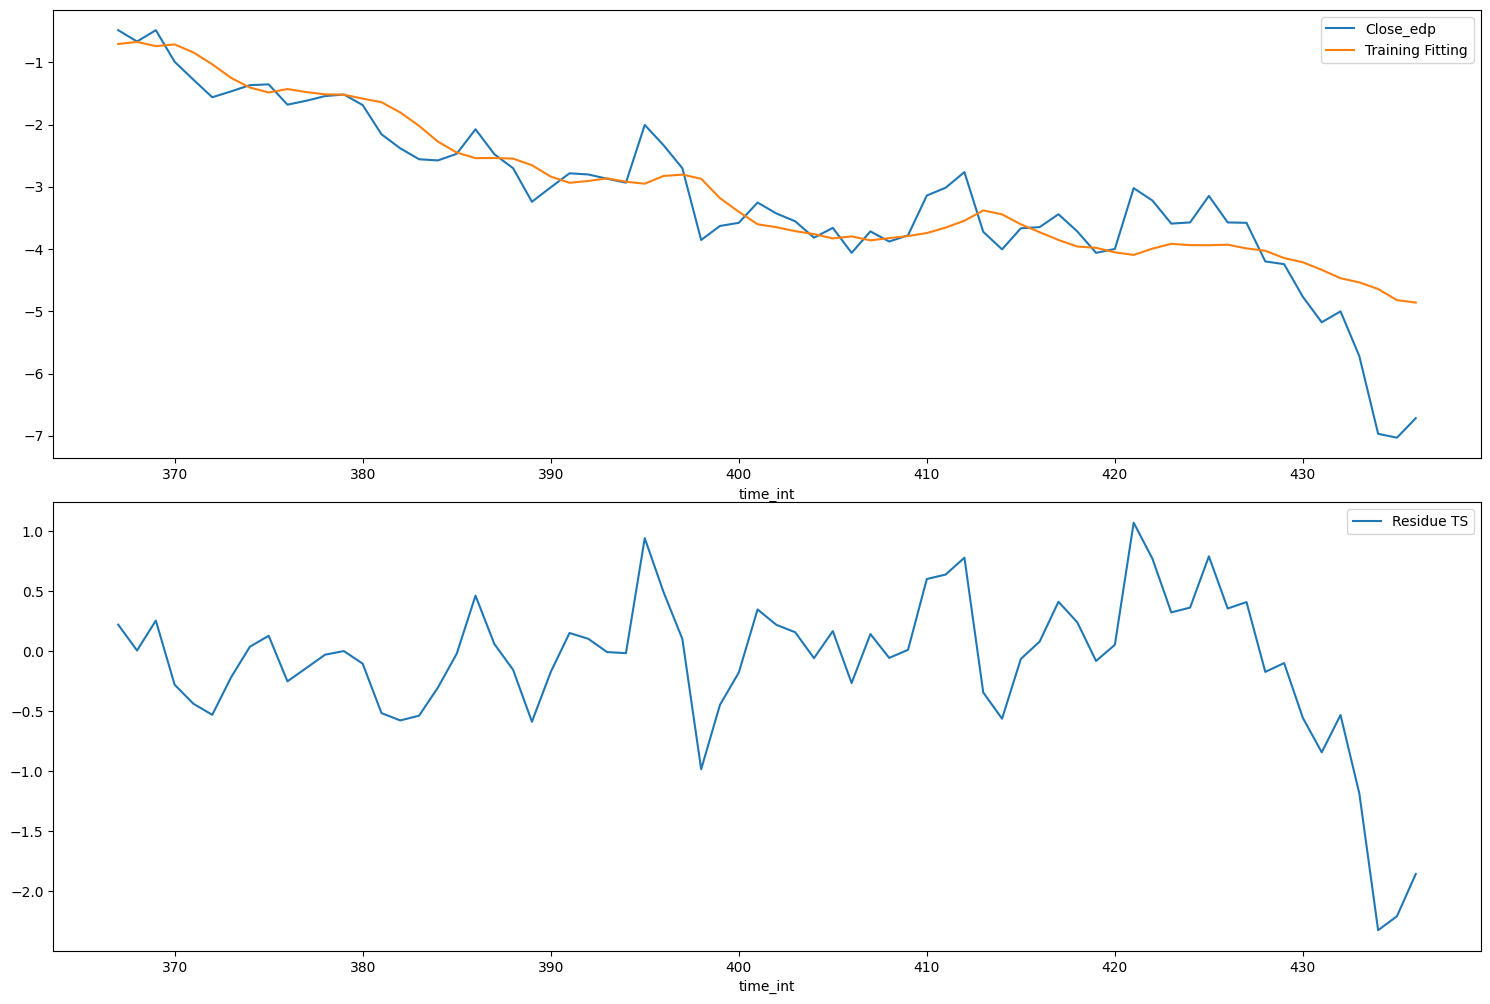

<Figure size 640x480 with 0 Axes>

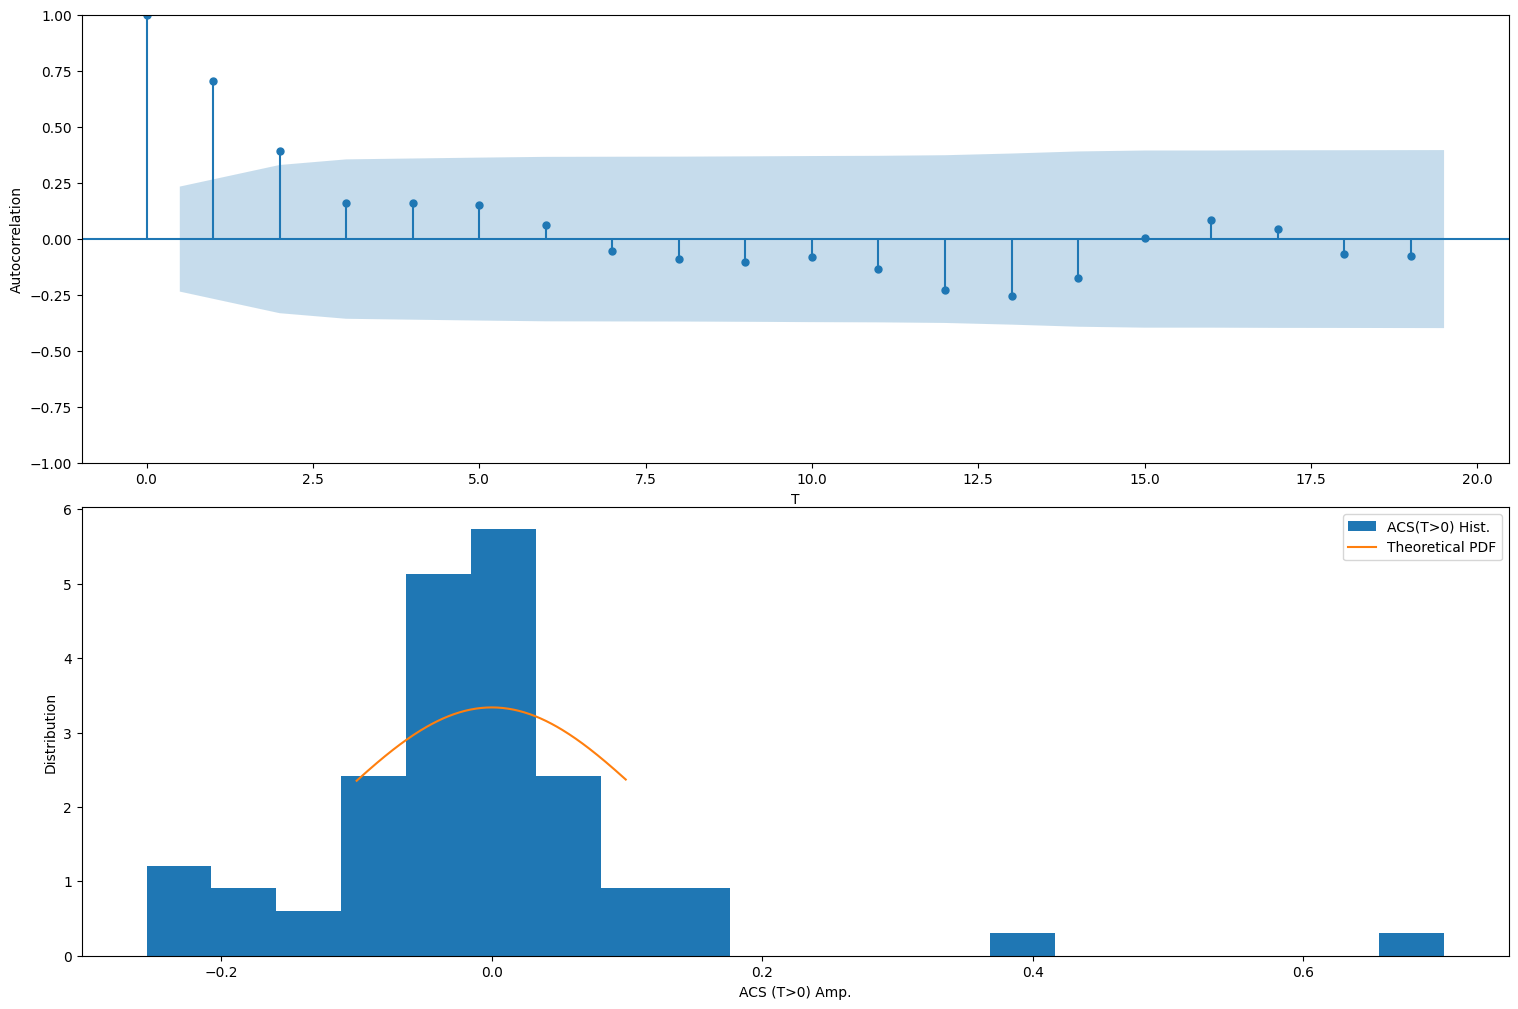

In [ ]:
TRPred=regressorLSTM.predict(InpTensTR)
predTS=pd.Series(data=TRPred[:,0],index=dataTR.index[maxLag:],name='Training Fitting')
resTS=dataTR['Close_edp'].iloc[maxLag:]-predTS
resTS.name='Residue TS'
plt.figure()
fig, axs=plt.subplots(2,figsize=(15,10)) 
fig.tight_layout() 
dataTR['Close_edp'][maxLag:].plot(ax=axs[0],legend=True) 
predTS.plot(ax=axs[0],legend=True) 
resTS.plot(ax=axs[1],legend=True)

#Evaluate fitting quality by inspecting residuals at two levels: ACS and ACS #distribution
plt.figure()
fig, axs=plt.subplots(2,figsize=(15,10))
fig.tight_layout()
plot_acf(resTS,ax=axs[0],title="")
axs[0].set_xlabel("T")
axs[0].set_ylabel("Autocorrelation")
ac=acf(resTS,nlags=500,fft=False) 
axs[1].hist(ac[1:],bins=20,density=True,label='ACS(T>0) Hist.')
N=resTS.size
rg=np.arange(-0.1,0.1,0.001)
pdf = spyst.norm.pdf(rg,0,1/np.sqrt(N))
plt.plot(rg,pdf,label='Theoretical PDF')
plt.xlabel("ACS (T>0) Amp.")
plt.ylabel("Distribution")
plt.legend()

1/1 [==============================] - 0s 13ms/step
Forecast RMSE=1.174868863718847


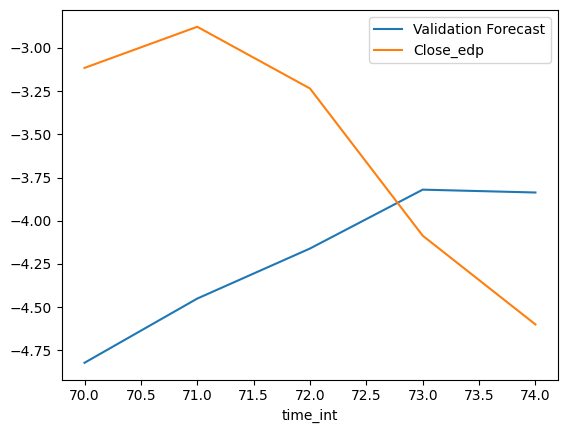

In [ ]:
plt.figure()
vl_predictions = regressorLSTM.predict(InpTensVL) #Lets back to the original domain by integrating
predTS=pd.Series(data=vl_predictions[:,0],index=dataVL.index,name='Validation Forecast')
predTS.plot(legend=True)
dataVL['Close_edp'].plot(legend=True)
print("Forecast RMSE="+str(np.sqrt(np.sum((dataVL['Close_edp']- predTS)**2)/predTS.size)))

## Validar LSTM

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Initialize lists to store metrics
rmse_values = []
u2_values = []
mafe_values = []

# Loop over the data
for i in range(0, len(merged_data) - 75):
    # Define the training and testing data
    lisDataTR = merged_data[i:i+75]
    lisDataTE = merged_data[i+70:i+75]
    
    # Normalize the data
    lisDataTRstd = pd.DataFrame(data=scaler.transform(lisDataTR),index=lisDataTR["time_int"],columns=lisDataTR.columns)
    lisDataTEstd = pd.DataFrame(data=scaler.transform(lisDataTE),index=lisDataTE["time_int"],columns=lisDataTE.columns)

    # Select the columns
    dataTR = lisDataTRstd[['Close_edp','Close_edpr']]
    dataTE = lisDataTEstd[['Close_edp','Close_edpr']]

    # Prepare the input tensors
    dataDelTR = genIOData(outData=dataTR['Close_edp'], inData=dataTR['Close_edpr'], delayEndog=delays, delayExog=[delays])
    dataInpTR = dataDelTR.iloc[:,0:-1]
    dataOutTR = dataDelTR.iloc[:,-1].to_numpy()
    InpTensTR = genTensor(dataInpTR, maxLag, 2)
    OutTensTR = dataOutTR
    
    # Make predictions on the next 5 data points of the training data
    predictions = regressorLSTM.predict(InpTensTR[-5:])
    #print("Predictions:", predictions,dataTE["Close_edp"])
    
    # Calculate the metrics
    rmse = np.sqrt(mean_squared_error(dataTE["Close_edp"], predictions))
    print("rmse: ",rmse)
    u2 = 1 - np.var(dataTE - predictions) / np.var(dataTE)
    mafe = np.mean(np.abs((dataTE - predictions) / dataTE))
    
    # Store the metrics
    rmse_values.append(rmse)
    u2_values.append(u2)
    mafe_values.append(mafe)

# Calculate the average metrics
avg_rmse = np.mean(rmse_values)
avg_u2 = np.mean(u2_values)
avg_mafe = np.mean(mafe_values)

print('Average RMSE:', avg_rmse)
print('Average U2:', avg_u2)
print('Average MAFE:', avg_mafe)


(70, 5, 2)
1/1 [==============================] - 0s 19ms/step
rmse:  1.5455907741280348
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.5772218734757901
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  1.6246922466737215
(70, 5, 2)
1/1 [==============================] - 0s 13ms/step


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/b

rmse:  1.5981610539998312
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  1.731296197045398
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  1.9297948348133502
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  2.1970251292758434
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  2.461061356268029
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  2.5046883591594726
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  2.2776325281256224
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  1.9053700742858701
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.4305008216881432
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.7957476515904431
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  0.5291748620916741
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  0.5330351780871128
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.44474307998522605
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 12ms/step
rmse:  0.44691186708775255
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  0.27919031678013567
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.33461365754586353
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  0.44737982423042943
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.46662527753919064
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.5828360636325046
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 12ms/step
rmse:  0.5821341397831021
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.5465398508735553
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  0.4470686189803751
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.6188767525159654
(70, 5, 2)
1/1 [==============================] - 0s 13ms/step
rmse:  1.1449535567785143
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.430615641606702
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 12ms/step
rmse:  1.5456095679401265
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.5885681190017615
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.5546639811450669
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.234093785363904
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.9414778798708333
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.8396432610832112
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  0.811003478552779
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.8290688935481508
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  0.7272627334908714
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.6555682329123816
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.5739437464474336
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.6168386609276532
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 12ms/step
rmse:  0.5106098890121599
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  0.5149224560099255
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.5185201806596078
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.4570387903456908
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  0.29771157483574934
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.22468328027312826
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 13ms/step
rmse:  0.21459875212278423
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.5521617984741426
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.5511330865844449
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.5737605585366675
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.7402552051922684
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.7443234250074765
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  0.5420704648975956
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.5706289031085753
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.5867178483572163
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  0.5683378387534272
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.8679150309948473
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.9870395328371718
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  1.0500816623207867
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.097837817907301
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.0749800034390145
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.9034312184381144
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.7772021887546255
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.6762358919172643
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.5944148646043937
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  0.47803457088683937
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.3858722149290394
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.3710929404246985
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.377342001729031
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.3878039473409832
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.35362085240284696
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.32852833573329465
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 10ms/step
rmse:  0.32926035461293035
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.4536223327370038
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  0.3552296698698118
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.3782174707815151
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.43602900840803027
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.616623896313792
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 10ms/step
rmse:  0.8624603156018138
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.9513954281504152
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.0211830488132816
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.1136196723936054
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.107264390339937
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.0990772127622008
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.0831571842901324
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  1.0140818715917432
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.899300604452066
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.8188274907818713
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.5688236592161995
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.6345200082161776
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.7644932974273257
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.7732532450498972
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  0.9085900947835557
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  0.9699177203222988
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.0438420088255749
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.1077890464180493
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.2570746370951378
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.283104858515032
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.3432252181508308
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  1.3070321061702663
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.2232387587520845
(70, 5, 2)
1/1 [==============================] - 0s 17ms/step
rmse:  1.1579978555565704
(70, 5, 2)
1/1 [==============================] - 0s 13ms/step
rmse:  1.1273600414574683
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.2500751779438584
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  1.5147628304446807
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  1.6758373846232972
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.7578402153754995
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.7414260421528907
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.6924184924820118
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.6622861978097405
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.8034321580913175
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.868207009067233


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  2.027055898565095
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  2.158925904441758
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  2.154661769710037
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  2.1033841736277763
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  2.159369133257282
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  2.156798972639124
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.8933869579154248
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  1.6462999438704715
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.4144500535151807
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.1528853608945766
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.87766276292328
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.0649788120326917
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.2076885573534928
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.2305951190269477
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 10ms/step
rmse:  1.1440071703270538
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.169071036754632
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.1102657222471106
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.0183256146205717
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.0186859972228062
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.965652749612099
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.7984647312404229
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 10ms/step
rmse:  0.7387313673574897
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.7440098746743485
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.5843034733791396
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.6070950276458175
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.6028902287802398
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.5808554193729687
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.5531081848277176
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 12ms/step
rmse:  0.5276527483284471
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.5112379086750152
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.51343319213246
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.43172289219123544
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.41162241436555413
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.6793792989023293
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.8641902419214207
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 10ms/step
rmse:  0.9033969989951033
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.8841294250309248
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.8345989909240559
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.6348231426193438
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.34484363474850743
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.301500003509726
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 10ms/step
rmse:  0.319885159176826
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.42879177964616977
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.6287070779466922
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.7488996066337195
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.7211016008477906
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.7219171881835452
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.6599427458233322
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  0.5285253505581224
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.6283732671920154
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  0.6250016037326707
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.6283606623390187
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.6537945083769044
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.6302638622125135
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.3365221540617088
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 10ms/step
rmse:  0.4204215035211612
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  0.4355899363031319
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.5728925980301462
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  0.6527780212881747
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  0.7530878973276036
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.7461226100310335
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  0.9211474978985724
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.9546877297009493
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.9582123589297481
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  0.8907141881945698
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.882758564438866
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.7458979193081473
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.6708345705297075
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 10ms/step
rmse:  0.7628269341736084
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.7955682039581354
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.7648200508992427
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.7000631219972289
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.6210347183416677
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.4919513526702938
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.4721906070338832
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  0.5397875488444155
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.5506030658891758
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.5348134390575113
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.4600088536591775
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  0.3784361796170341
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.34179317112743596
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.36663704749045417
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  0.659149611601153
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.6509042759867708
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.6812812231900119
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.6617063518390922
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.6538389772983085
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.45358916711371455
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.6689525355937784
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  0.6684679802043205
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.6659947962459088
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.653054487961183
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.58488525276703
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.2451879320024214
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.17651520380930222
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.2347942842882719


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  0.3482226635653615
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.4153596328927857
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.4267210796121836
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.4334655962593541
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.3957731693953516
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.29444526719548847
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.19434157850975767
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 10ms/step
rmse:  0.19202497926250514
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.14825165416431973
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.1686283975633705
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.1788777702795744
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.23677401294434924
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.24064542783394102
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.36437190743302034
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 10ms/step
rmse:  0.42978255785081787
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.657237983128907
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.6681277085525834
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.6774979589235695
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.6279683396317147
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.5870987565405044
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.3437508401435227
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 10ms/step
rmse:  0.27758844615439743
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.25498102928768185
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.26632739071073486
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.2408274800163361
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.3471756436177556
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.37587508075777215
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.46944857075505153
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 14ms/step
rmse:  0.45531616587069573
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.4686345603274842
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.42873534266119845
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.4123664956934121
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.36097831871595254
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.35507641237238013
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

rmse:  0.4101257622551336
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.42241838890856875
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  0.5221963092144088
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.6958217694566418
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.983871388007785
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.0813047028134366
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.1375959129760052
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.2788481830527885
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  1.361323953308913
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.3307348728846062
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.3850287715748655
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.5020532181391972
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.388345801099545
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.2825211847015523
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.2080998857672154
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  1.3630543046581407
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.4622608858856643
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.6881927077303402
(70, 5, 2)
1/1 [==============================] - 0s 13ms/step
rmse:  1.8212915879452294
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  1.977049669475387
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.964683118439299
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  2.0053878524082562
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.8428023806899536
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.6780492742206035
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.4313679438571014
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.2190085482959379
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.7380471546981596
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 10ms/step
rmse:  0.6094772656746333
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.5367189602105554
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.5162817274187164
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.2896493613092621
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  0.4088668371561003
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.49686032346118736
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

rmse:  0.5736350982417827
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.5729947522372855
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  0.5684987248111296
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.46352443456232245
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.34335988857599825
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.19340629340824853
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 10ms/step
rmse:  0.18245606058675382
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.3361807847577007
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.43836547467083065
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.4357696707651879
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.48645754315851336
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.4715580607311806
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 10ms/step
rmse:  0.38310064861020066
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.2685287641939378
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.29177970327265174
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  0.19167610416489134
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.1929326264013782
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.18055241545759348
(70, 5, 2)
1/1 [==============================] - ETA: 0s

/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  0.19728017825885222
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.1391592493051207
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.18024649261048592
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.21864811575308649
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.3069216219062462
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.3946770789938092
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.4161218822607444
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 13ms/step
rmse:  0.3992004651465297
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.37832448066905777
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.3323682358038695
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.2109509568136944
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.17069002767945468
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.1745911550976652
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  0.20574435145552428
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.3588636745876854
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.5115125259185112
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.646317684219465
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.7356073986855265
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.7794733598223047
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.7162433408027686
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  0.6761944469793968
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.6645833975593927
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.8132165547614019
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.8679562423140696
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.903111576797312
(70, 5, 2)
1/1 [==============================] - 0s 14ms/step
rmse:  0.8968246973594226
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  0.8720130417729299
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.7395858511478782
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.6157316154436725
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  0.573139545406657
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.6038315638578343
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  0.9878901794902304
(70, 5, 2)
1/1 [==============================] - ETA: 0s

/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  1.1345621788661437
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.2681002157796384
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.3251269572841111
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.3791317308332682
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  1.2362454378690884
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  1.251288235381981
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 12ms/step
rmse:  1.270819539068692
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  1.4373793786856095
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.4807972609053215
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.533828399021848
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.5228255950327854
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.4474044185846253
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 12ms/step
rmse:  1.2688026175720464
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.1405066463893643
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.154036071988636
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.2533748286926414
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.3469962347205182
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  1.4245964384403904
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  1.4833061330141777
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  1.4519236675492175
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.448482351797154
(70, 5, 2)
1/1 [==============================] - 0s 18ms/step
rmse:  1.5183046895677408
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  1.4352798631775665
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.4197374080190353
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  1.4132946940939286
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.32393815236965
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.1700128431989347
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.301363471271646
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.3868961630960293
(70, 5, 2)
1/1 [==============================] - 0s 12ms/step
rmse:  1.5472199317824402
(70, 5, 2)


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

1/1 [==============================] - 0s 11ms/step
rmse:  1.6864982694480812
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  1.985135005164282
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  2.287542153313863
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  2.502718575323003
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step
rmse:  2.779163017496584
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  3.330295386823313
(70, 5, 2)
1/1 [==============================] - 0s 10ms/step


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o

rmse:  3.7493355919328937
(70, 5, 2)
1/1 [==============================] - 0s 11ms/step
rmse:  3.9999217061476133
Average RMSE: 0.8797693824831796
Average U2: -0.6884816786702302
Average MAFE: 4.706287334729307


/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/pedrocarrasco/.venvs/astp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the o